In [1]:
%matplotlib inline
#import ipywidgets as widgets
#from ipywidgets import interact
import numpy as np
import matplotlib.pyplot as plt
#from scipy.spatial.distance import cdist
#from numpy.linalg import inv
import george
from george.kernels import ExpSine2Kernel, ExpSquaredKernel, Matern32Kernel
import astropy
from astropy.io import fits
import lightkurve
from scipy.signal import savgol_filter, peak_widths, find_peaks, peak_prominences
#import celerite
#from celerite import terms
import copy
import warnings
warnings.filterwarnings("ignore")

### 1) Inspect the data

Downloaded directly from https://archive.stsci.edu/k2/preview.php?dsn=ktwo246301900-c12&type=lc

Metadata

In [2]:
import pandas as pd

filename = '/Users/chrislam/Desktop/epic-246301900/ktwo246301900-c12_llc.fits'
hdul = fits.open(filename)
hdul.info()

Filename: /Users/chrislam/Desktop/epic-246301900/ktwo246301900-c12_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   ()      
  1  LIGHTCURVE    1 BinTableHDU    155   3862R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        48   (10, 8)   int32   


In [3]:
data = fits.getdata(filename,header=True,ext=1)
df = pd.DataFrame(np.array(data[0]).byteswap().newbyteorder()) # to avoid big-endian/little-endian mixup: https://stackoverflow.com/questions/30283836/creating-pandas-dataframe-from-numpy-array-leads-to-strange-errors
print(df.head())

          TIME  TIMECORR  CADENCENO     SAP_FLUX  SAP_FLUX_ERR       SAP_BKG  \
0  2905.377230  0.005332     136855  614164.8125     22.716827  19529.195312   
1  2905.397662  0.005331     136856  614196.0000     22.708811  19530.005859   
2  2905.418095  0.005329     136857  614179.6250     22.713530  19541.736328   
3  2905.438527  0.005328     136858  614099.5000     22.717106  19533.994141   
4  2905.458959  0.005327     136859  614238.1875     22.723835  19532.445312   

   SAP_BKG_ERR  PDCSAP_FLUX  PDCSAP_FLUX_ERR  SAP_QUALITY  PSF_CENTR1  \
0     7.201994          NaN              NaN       524288         NaN   
1     7.175916  612915.2500        22.353420            0         NaN   
2     7.180060  612892.8125        22.366695            0         NaN   
3     7.191803  612824.8125        22.378389            0         NaN   
4     7.191343  612975.3750        22.391329            0         NaN   

   PSF_CENTR1_ERR  PSF_CENTR2  PSF_CENTR2_ERR  MOM_CENTR1  MOM_CENTR1_ERR  \
0  

Download light curve from MAST

In [ ]:
flc = lightkurve.search_lightcurve("EPIC 246301900", cadence="long", campaign=12, mission="K2")
print(flc)

In [ ]:
download = flc[2].download()

In [ ]:
plt.scatter(download.time.value, download.flux.value, s=2)
plt.show()

In [ ]:
plt.scatter(df.TIME, df.PDCSAP_FLUX, s=2)
plt.show()

In [ ]:
plt.plot(df.TIME, df.PDCSAP_FLUX/np.nanmedian(df.PDCSAP_FLUX) - 1)
plt.xlabel('Barycentric Julain Date')
plt.ylabel('Normalized PDCSAP Flux')
plt.savefig('normalized_lightcurve.png', format='png')
plt.show()

In [ ]:
# examine the gap
plt.plot(df.TIME, df.PDCSAP_FLUX)
plt.xlim([2935,2985])
plt.ylim([590000,700000])
plt.show()

In [ ]:
# examine spike/possible flare shortly after 2970 BJD
plt.plot(df.TIME, df.PDCSAP_FLUX)
plt.xlim([2971,2973])
plt.ylim([590000,700000])
plt.show()

print(df.loc[(df.TIME>2971.9) & (df.TIME<2972.1)].PDCSAP_FLUX)

3255


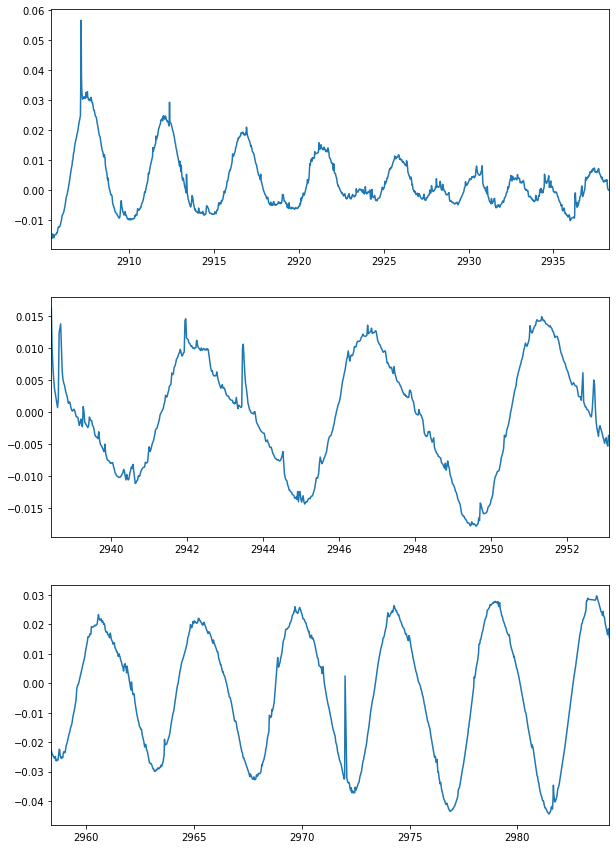

In [6]:
# divide data into pre-flare, post-flare/pre-gap, and post-flare/post-gap
df = pd.DataFrame(np.array(data[0]).byteswap().newbyteorder())
df = df.dropna(subset=['TIME','PDCSAP_FLUX','PDCSAP_FLUX_ERR']) # toss NaNs since they'll create matrices of NaNs
print(len(df))

pre = df.loc[:1611] # next record is the beginning of the flare, so stop here
post = df.loc[1614:2336] # start from after the flare until beginning of the gap in time series data
postgap = df.loc[2337:] # start from end of the gap in data until end of time series data

plt.figure(figsize=(10,15))
plt.subplot(311)
xobs = np.array(pre["TIME"])
yobs = np.array(pre["PDCSAP_FLUX"])
plt.xlim(min(pre.TIME),max(pre.TIME))
#plt.ylim(590000,660000)
plt.plot(xobs,yobs/np.median(yobs)-1)

plt.subplot(312)
xobs = np.array(post["TIME"])
yobs = np.array(post["PDCSAP_FLUX"])
plt.xlim(min(post.TIME),max(post.TIME))
#plt.ylim(590000,660000)
plt.plot(xobs,yobs/np.median(yobs)-1)

plt.subplot(313)
xobs = np.array(postgap["TIME"])
yobs = np.array(postgap["PDCSAP_FLUX"])
plt.xlim(min(postgap.TIME),max(postgap.TIME))
#plt.ylim(590000,660000)
plt.plot(xobs,yobs/np.median(yobs)-1)
plt.show()

### 2) GP Modeling

Model with GP in order to get a baby-smooth light curve on which I can inject artificial flares for injection recovery.

Pre-super-flare

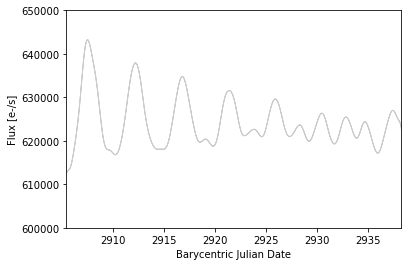

[612915.25 612892.8  612824.8  ... 622910.75 622810.2  622744.44]
[612843.0178797  612963.33290786 613059.09891857 ... 623112.17550293
 622799.29855908 622437.74863554]


In [7]:
lhs_pre = min(pre.TIME)
rhs_pre = max(pre.TIME)
xobs_pre = np.array(pre["TIME"])
yobs_pre = np.array(pre["PDCSAP_FLUX"])
eobs_pre = np.array(pre["PDCSAP_FLUX_ERR"])

kernel_pre = np.var(yobs_pre) * ExpSquaredKernel(0.8)
gp_pre = george.GP(kernel_pre)
gp_pre.compute(xobs_pre, eobs_pre)

pred_pre, pred_var_pre = gp_pre.predict(yobs_pre, xobs_pre, return_var=True)

plt.fill_between(xobs_pre, pred_pre - np.sqrt(pred_var_pre), pred_pre + np.sqrt(pred_var_pre),
                color="k", alpha=0.2)
#plt.plot(xobs, pred, "k", lw=1.5, alpha=0.5)
#plt.errorbar(xobs, yobs, yerr=eobs, fmt=".k", capsize=0)
plt.xlim(lhs_pre, rhs_pre)
#plt.xlim(lhs,2910)
plt.ylim(600000,650000)
plt.xlabel(r'Barycentric Julian Date')
plt.ylabel(r'Flux [e-/s]')
#plt.scatter(xobs_pre, yobs_pre, s=2)
plt.show()

print(yobs_pre)
print(pred_pre)

Same for post and postgap

In [8]:
def alias(df, normalized_flag, method, segment):
    """
    Params:
    - df: Pandas DataFrame representing light curve from MAST
    - normalized_flag: to normalize or not to normalize (Boolean)
    - method: 'gp' or 'savgol'
    - segment: 'pre', 'post', or 'postgap' (really only needed for savgol)
    
    Returns:
    - George-GP-smoothed predicted light curve (list of floats)
    """
    lhs = min(df.TIME)
    rhs = max(df.TIME)
    xobs = np.array(df["TIME"])
    yobs = np.array(df["PDCSAP_FLUX"])
    eobs = np.array(df["PDCSAP_FLUX_ERR"])
    
    kernel = np.var(yobs) * ExpSquaredKernel(0.5) # 0.8
    gp = george.GP(kernel)
    gp.compute(xobs, eobs)

    if normalized_flag==False:
        if method=='gp':
            pred, pred_var = gp.predict(yobs, xobs, return_var=True)
            return pred, pred_var
        elif method=='savgol':
            if segment=='pre':
                pred = savgol_filter(yobs, 109, polyorder=3)
            elif segment=='post':
                pred = savgol_filter(yobs, 129, polyorder=3)
            elif segment=='postgap':
                pred = savgol_filter(yobs, 129, polyorder=3)
            return pred
    
    elif normalized_flag==True:
        yobs_norm = yobs/np.median(yobs) - 1
        pred, pred_var = gp.predict(yobs_norm, xobs, return_var=True)
        if method=='gp':
            pred, pred_var = gp.predict(yobs_norm, xobs, return_var=True)
            return pred, pred_var
        elif method=='savgol':
            if segment=='pre':
                pred = savgol_filter(yobs_norm, 109, polyorder=3)
            elif segment=='post':
                pred = savgol_filter(yobs_norm, 149, polyorder=3)
            elif segment=='postgap':
                pred = savgol_filter(yobs_norm, 129, polyorder=3)
            return pred

#pred_pre, pred_var_pre = alias(pre, normalized_flag=True, method='gp', segment='pre')
#pred_post, pred_var_post = alias(post, normalized_flag=True, method='gp', segment='post')
pred_pre = alias(pre, normalized_flag=True, method='savgol', segment='pre')
pred_post = alias(post, normalized_flag=True, method='savgol', segment='post')
pred_postgap, pred_var_postgap = alias(postgap, normalized_flag=True, method='gp', segment='postgap')


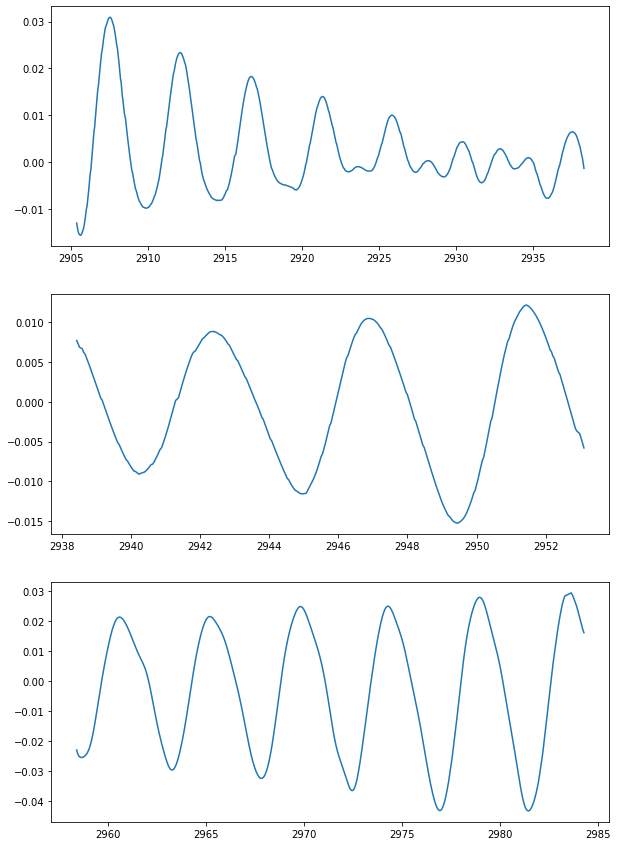

In [9]:
plt.figure(figsize=(10,15))
plt.subplot(311)
plt.plot(pre.TIME, pred_pre)

plt.subplot(312)
plt.plot(post.TIME, pred_post)

plt.subplot(313)
plt.plot(postgap.TIME, pred_postgap)
plt.show()

### 3) Inject flares

Pieces taken from Ekaterina Ilin's Altaipony: https://github.com/ekaterinailin/AltaiPony/blob/037bd76c8ed09ed6340cf2105d1e83bc302168eb/altaipony/flarelc.py

In [10]:
from altaipony.fakeflares import generate_fake_flare_distribution, mod_random, aflare

def inject_fakes(flux, df, num_flares):
    
    def _equivalent_duration(time, flux):
            '''
            Compute the Equivalent Duration of a fake flare.
            This is the area under the flare, in relative flux units.
            Parameters:
            -------------
            time : numpy array
                units of DAYS
            flux : numpy array
                relative flux units
            Return:
            ------------
            p : float
                equivalent duration of a single event in units of seconds
            '''
            x = time * 60.0 * 60.0 * 24.0
            integral = np.sum(np.diff(x) * flux[:-1])
            return integral
        
    # Init arrays for the synthetic flare parameters
    nfake = num_flares # 20 flares per time chunk for a total of 60 fake flares
    t0_fake = np.zeros(nfake, dtype='float') # peak times
    ed_fake = np.zeros(nfake, dtype='float') # ED
    #dur_fake = np.zeros(nfake, dtype='float') # duration
    #ampl_fake = np.zeros(nfake, dtype='float') # amplitude

    # Init the synthetic flare counter to allow to point to the right
    # places in the arrays above (XXX_fake etc.)
    ckm = 0

    # Pick flux, time, and flux error arrays 
    #error = error # pred_var_pre
    flux = flux # pred_pre
    time = np.array(df.TIME)
    #print(np.array(time))
    #print(download.time.value)
    
    # generate the time constraints for the flares you want to inject
    mintime, maxtime = np.min(time), np.max(time)
    dtime = maxtime - mintime

    # generate a distribution of durations and amplitudes
    d = False
    seed = 23 # mashed keyboard idk
    #default: ampl=[1e-4, 5], dur=[0.005, 0.012]
    distribution  = generate_fake_flare_distribution(nfake, d=d,
                                            seed=seed)
    dur_fake = distribution[0]
    ampl_fake = distribution[1]    
    
    for k in range(nfake):
        # add the peak time to the list and note the index
        t0 = (mod_random(1, d=d) * dtime + mintime)[0]
        t0_fake[k] = t0
    
        # generate the flare flux from the Davenport 2014 model
        fl_flux = aflare(time, t0, dur_fake[k], ampl_fake[k])

        # calculate the injected ED
        ed_fake[k] = _equivalent_duration(time, fl_flux)
        
        # inject flare into light curve by adding the flare flux
        flux = flux + fl_flux
        #fake_lc[typ].value[le:ri] = (fake_lc[typ][le:ri].value +
        #                            fl_flux * fake_lc.it_med[le:ri].value)
    
    return dur_fake, ampl_fake, t0_fake, ed_fake, flux

dur_fake_pre, ampl_fake_pre, t0_fake_pre, ed_fake_pre, flux_pre = inject_fakes(pred_pre, pre, num_flares=20)
dur_fake_post, ampl_fake_post, t0_fake_post, ed_fake_post, flux_post = inject_fakes(pred_post, post, num_flares=10)
dur_fake_postgap, ampl_fake_postgap, t0_fake_postgap, ed_fake_postgap, flux_postgap = inject_fakes(pred_postgap, postgap, num_flares=20)


In [ ]:
ampl_fake_pre

In [5]:
print(dur_fake_pre)
print(ampl_fake_pre)
print(t0_fake_pre)
print(ed_fake_pre)
print(flux_pre)

NameError: name 'dur_fake_pre' is not defined

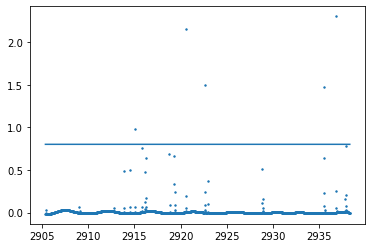

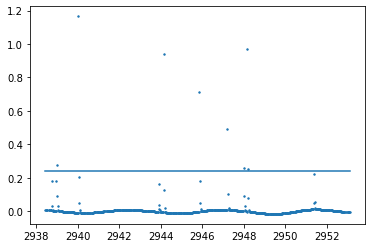

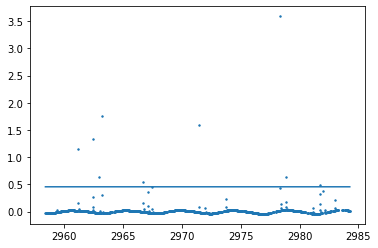

In [18]:
### did I do it?
plt.scatter(pre.TIME, flux_pre, s=2)
plt.plot(pre.TIME, np.ones(len(pre))*np.median(flux_pre)+7*np.std(flux_pre))
#plt.xlim(2908, 2911)
plt.show()

plt.scatter(post.TIME, flux_post, s=2)
plt.plot(post.TIME, np.ones(len(post))*np.median(flux_post)+3*np.std(flux_post))
plt.show()

plt.scatter(postgap.TIME, flux_postgap, s=2)
plt.plot(postgap.TIME, np.ones(len(postgap))*np.median(flux_postgap)+3*np.std(flux_postgap))
plt.show()
### yes I did!

### 4) Recover fake flares

In [19]:
print(np.abs(flux_pre))
print(np.abs(flux_pre) / np.sqrt(pred_var_pre))
print(np.abs(flux_pre) / pred_var_pre)
print(np.median(flux_pre))
print(np.median(flux_pre)+3*np.std(flux_pre))

[0.01298546 0.0134594  0.03538883 ... 0.00035522 0.00083042 0.00132385]
[9.75379496e-04 1.24952424e-03 3.96967252e-03 ... 3.84927501e-05
 7.47103913e-05 9.66678078e-05]
[7.32639020e-05 1.16001539e-04 4.45290224e-04 ... 4.17124984e-06
 6.72143133e-06 7.05870947e-06]
0.0005253717536106706
0.3439135198031284


In [11]:
flux = flux_pre
var = pred_var_pre
#var = pre.PDCSAP_FLUX_ERR
T0 = flux # excursion should be positive #"N0"
T1 = np.abs(flux) / np.std(flux) #N1
T2 = np.abs(flux - np.sqrt(var)) / np.std(flux) #N2
print("T1: ", T1)
print("T2: ", T2)
minsep = 3
N1 = 7
N2 = 3
N3 = 1
istart = np.array([], dtype='int')
istop = np.array([], dtype='int')

pass_thresholds = np.where((T0 > 0) & (T1 > N1) & (T2 > N2))
print("pass thresholds: ", pass_thresholds)

#array of indices where thresholds are exceeded:
is_pass_thresholds = np.zeros_like(flux)
is_pass_thresholds[pass_thresholds] = 1

# test based on consecutive points
reverse_counts = np.zeros_like(flux, dtype='int')
for k in range(2, len(flux)):
    reverse_counts[-k] = (is_pass_thresholds[-k]
                            * (reverse_counts[-(k-1)]
                            + is_pass_thresholds[-k]))

# find flare start where values in reverse_counts switch from 0 to >=N3
istart_i = np.where((reverse_counts[1:] >= N3) &
                    (reverse_counts[:-1] - reverse_counts[1:] < 0))[0] + 1

# use the value of reverse_counts to determine how many points away stop is
istop_i = istart_i + (reverse_counts[istart_i])

# Create boolean flare mask
isflare = np.zeros_like(flux, dtype='bool')

for (l,r) in list(zip(istart_i, istop_i)):
    isflare[l:r+1] = True
    
print("is flare? ", isflare)

### 

# now pick out final flare candidate indices
candidates = np.where( isflare > 0)[0]
print("candidates: ", candidates)
if (len(candidates) < 1): # no candidates = no indices
    istart_gap = np.array([])
    istop_gap = np.array([])
else:
    # find start and stop index, combine neighboring candidates
    # in to same events
    separated_candidates = np.where( (np.diff(candidates)) > minsep )[0]
    istart_gap = candidates[ np.append([0], separated_candidates + 1) ]
    istop_gap = candidates[ np.append(separated_candidates,
                            [len(candidates) - 1]) ]

print(istart_gap)
print(istop_gap)
#stitch indices back into the original light curve
#istart = np.array(np.append(istart, istart_gap + le), dtype='int')
#istop = np.array(np.append(istop, istop_gap + le), dtype='int')

print(len(istart_gap))

T1:  [0.0802271  0.08315522 0.0857739  ... 0.00219462 0.00513056 0.00817904]
T2:  [82.33241495 66.63265828 55.163424   ... 57.0155524  68.67767317
 84.61793556]
pass thresholds:  (array([ 320,  422,  710, 1256, 1290]),)
is flare?  [False False False ... False False False]
candidates:  [ 320  321  422  423  710  711 1256 1257 1290 1291]
[ 320  422  710 1256 1290]
[ 321  423  711 1257 1291]
5


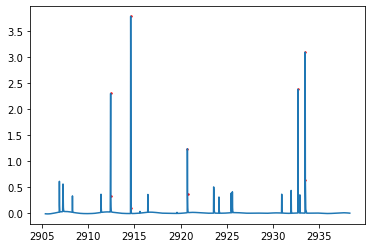

In [12]:
#for xc in pre.TIME[istart_gap]:
#    plt.axvline(x=xc, c='r')
#for xc in t0_fake_pre:
#    plt.axvline(x=xc, c='r', linestyle='--')
#plt.scatter(pre.TIME, flux_pre, s=2)
plt.plot(pre.TIME, flux_pre)
#plt.scatter(np.array(pre.TIME)[candidates], flux_pre[candidates], c='r', s=2)
plt.scatter(np.array(pre.TIME)[candidates], flux_pre[candidates], c='r', s=2)
#plt.xlim(2932, 2933)
#plt.xlim(2911, 2913)
plt.show()

### 5) Evaluate recovery

Compare istart_gaps and t0s to calculate TPs, FPs, and FNs. 

In [17]:
print(istart_gap)
print(np.array(pre.TIME)[istart_gap])

[ 320  422  710 1256 1290]
[2912.44676961 2914.61256961 2920.74216299 2932.69476248 2933.47116645]


In [18]:
t0_fake_pre

array([2911.39265358, 2906.89758574, 2908.31064142, 2907.27802179,
       2919.60743396, 2915.5984265 , 2924.14887909, 2932.88623106,
       2912.44471911, 2930.93505048, 2925.59531287, 2933.58090732,
       2923.58536206, 2932.69338411, 2916.45815701, 2925.47404961,
       2933.4723583 , 2914.61207524, 2920.74389107, 2931.95124207])

In [19]:
pred_flares_pre = pd.DataFrame({'istart': np.array(pre.TIME)[istart_gap], 
                                'istop': np.array(pre.TIME)[istop_gap],
                               'gap': np.array(pre.TIME)[istop_gap]-np.array(pre.TIME)[istart_gap]})
print(pred_flares_pre)

tps = 0
for i in t0_fake_pre:
    # exploit the shape of the flare for some breathing room: if t0 is within max(istop-istart) of istart, then it's a TP
    if (np.abs(i - pred_flares_pre['istart']) < np.max(pred_flares_pre['gap'])).any():
        tps += 1
fps = len(istart_gap) - tps      
fns = len(t0_fake_pre) - tps
print("TPs: ", tps)
print("FPs: ", fps)
print("FNs: ", fns)

        istart        istop       gap
0  2912.446770  2912.467202  0.020432
1  2914.612570  2914.653434  0.040864
2  2920.742163  2920.762595  0.020432
3  2932.694762  2932.715194  0.020432
4  2933.471166  2933.491598  0.020432
TPs:  5
FPs:  0
FNs:  15


In [20]:
print(np.abs(pre.PDCSAP_FLUX - np.median(pre.PDCSAP_FLUX)))
print(np.abs(pre.PDCSAP_FLUX - np.median(pre.PDCSAP_FLUX) - pre.PDCSAP_FLUX_ERR))
print(np.std(pre.PDCSAP_FLUX))
print(np.median(pre.PDCSAP_FLUX))
print(pred_pre)
print(pred_var_pre)

1        9925.3750
2        9947.8125
3       10015.8125
4        9865.2500
5        9091.9375
           ...    
1607      292.0625
1608       66.0000
1609       70.1250
1610       30.4375
1611       96.1875
Name: PDCSAP_FLUX, Length: 1511, dtype: float32
1        9947.728516
2        9970.178711
3       10038.190430
4        9887.641602
5        9114.365234
            ...     
1607      269.120148
1608       43.062344
1609       47.187157
1610       53.378136
1611      119.137451
Length: 1511, dtype: float32
5889.1313
622840.6
[-0.01298546 -0.0134594  -0.01388325 ... -0.00035522 -0.00083043
 -0.00132385]
[177.24220854 116.02774964  79.47362831 ...  85.15800413 123.54878833
 187.54829747]


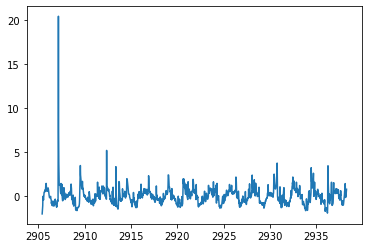

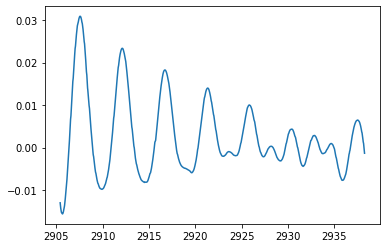

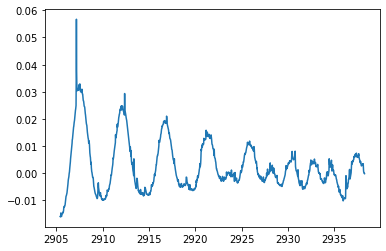

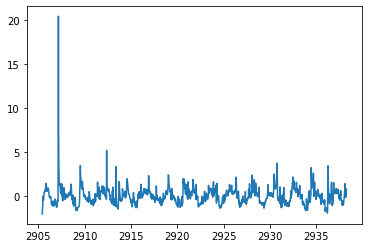

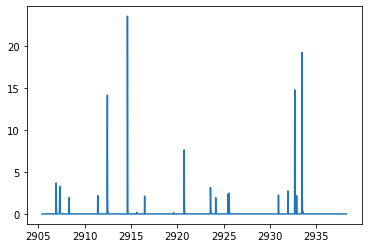

23.55299261075101


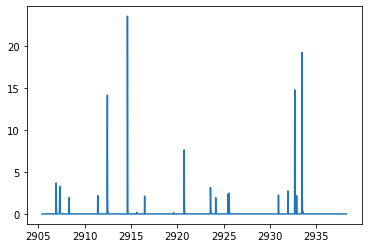

23.552766871267842


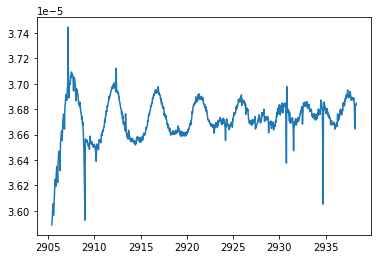

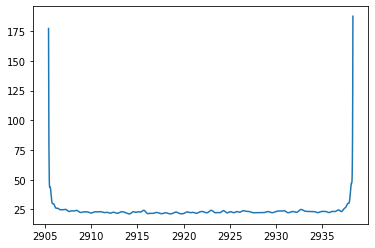

In [21]:
"""
plt.plot(pre.TIME, pre.PDCSAP_FLUX - np.median(pre.PDCSAP_FLUX))
plt.show()

plt.plot(pre.TIME, np.abs(pre.PDCSAP_FLUX - np.median(pre.PDCSAP_FLUX)) / np.std(pre.PDCSAP_FLUX))
plt.show()

plt.plot(pre.TIME, np.abs(pre.PDCSAP_FLUX - np.median(pre.PDCSAP_FLUX) - pre.PDCSAP_FLUX_ERR) / np.std(pre.PDCSAP_FLUX))
plt.show()

plt.plot(pre.TIME, (pre.PDCSAP_FLUX/np.median(pre.PDCSAP_FLUX) - 1)/np.std(pre.PDCSAP_FLUX))
plt.show()
"""

### what I end up using
# data detrended
norm_flux_pre = pre.PDCSAP_FLUX/np.median(pre.PDCSAP_FLUX) - 1 
plt.plot(pre.TIME, (norm_flux_pre-pred_pre)/np.std(norm_flux_pre-pred_pre))
plt.show()

plt.plot(pre.TIME, pred_pre)
plt.show()

plt.plot(pre.TIME, norm_flux_pre)
plt.show()

# data detrended minus error, with detrending propagated
plt.plot(pre.TIME, (norm_flux_pre-pred_pre-pre.PDCSAP_FLUX_ERR/np.median(pre.PDCSAP_FLUX))/np.std(norm_flux_pre-pred_pre))
plt.show()

# GP model detrended
plt.plot(pre.TIME, (flux_pre-pred_pre)/np.std(flux_pre-pred_pre))
plt.show()
print(np.max((flux_pre-pred_pre)/np.std(flux_pre-pred_pre)))

# GP model detrended minus error, with detrending propagated
plt.plot(pre.TIME, (flux_pre-pred_pre-pre.PDCSAP_FLUX_ERR/np.median(pre.PDCSAP_FLUX))/np.std(flux_pre-pred_pre-pre.PDCSAP_FLUX_ERR/np.median(pre.PDCSAP_FLUX)))
plt.show()
print(np.max((flux_pre-pred_pre-pre.PDCSAP_FLUX_ERR/np.median(pre.PDCSAP_FLUX))/np.std(flux_pre-pred_pre-pre.PDCSAP_FLUX_ERR/np.median(pre.PDCSAP_FLUX))))

# data error with detrending propagated
plt.plot(pre.TIME, pre.PDCSAP_FLUX_ERR/np.median(pre.PDCSAP_FLUX))
plt.show()

# GP model variance
plt.plot(pre.TIME, pred_var_pre)
plt.show()


Functionalize everything

In [22]:
def recover_flares(df, flux, pred, N1, N2, N3, minsep, norm_flag):
    """
    Params:
    - df: DataFrame from which error comes (PDCSAP_FLUX_ERR), as well as real flux (PDCSAP_FLUX) for median division
    - flux: normalized GP-predicted flux with flares injected OR normalized flux data
    - pred: GP-predicted flux
    - N1: int or float (default is 3)
        How many times above sigma is required.
    - N2: int or float (Default is 3)
        How many times above sigma and detrended_flux_err is required
    - N3: int or float (Default is 2)
        The number of consecutive points required to flag as a flare.
    - minsep: 1 or int
        minimum distance between two candidate start times in datapoints
    - norm_flag: True or False
        Are you feeding in normalized flux or unnormalized flux?
    Returns:
    - candidates: flare points
    - istart_gap: flare start indices
    - istop_gap: flare stop indices
    """

    error = df.PDCSAP_FLUX_ERR
    real_flux = df.PDCSAP_FLUX
    
    if norm_flag==True:
        """
        the old way
        #var = pre.PDCSAP_FLUX_ERR
        T0 = flux 
        T1 = np.abs(flux) / np.std(flux) #N1
        T2 = np.abs(flux - np.sqrt(var)) / np.std(flux) #N2
        """
        T0 = flux - pred # flux data minus the GP-smoothed quiescent, flare-pared flux
        T1 = T0/np.std(T0)
        T2_numerator = T0-(error/np.median(real_flux)) # whether flux is real_flux or not, since error is real, so is median(flux)
        T2 = T2_numerator/np.std(T2_numerator)
        
    elif norm_flag=='Altaipony': # this was just for testing
        median = np.median(flux)
        sigma = np.std(flux)
        T0 = flux - median # excursion should be positive #"N0"
        T1 = np.abs(flux - median) / sigma #N1
        T2 = np.abs(flux - median - error) / sigma #N2
        #print("T0: ", T0)
        #print("T1: ", T1)
        #print("T2: ", T2)
        # hold on, this doesn't seem to get me what I'd expect (see plots in cell above)
        
    minsep = 3
    istart = np.array([], dtype='int')
    istop = np.array([], dtype='int')

    pass_thresholds = np.where((T0 > 0) & (T1 > N1) & (T2 > N2))
    #print("pass thresholds: ", pass_thresholds)
    
    #array of indices where thresholds are exceeded:
    is_pass_thresholds = np.zeros_like(flux)
    is_pass_thresholds[pass_thresholds] = 1

    # test based on consecutive points
    reverse_counts = np.zeros_like(flux, dtype='int')
    for k in range(2, len(flux)):
        reverse_counts[-k] = (is_pass_thresholds[-k]
                                * (reverse_counts[-(k-1)]
                                + is_pass_thresholds[-k]))

    # find flare start where values in reverse_counts switch from 0 to >=N3
    istart_i = np.where((reverse_counts[1:] >= N3) &
                        (reverse_counts[:-1] - reverse_counts[1:] < 0))[0] + 1

    # use the value of reverse_counts to determine how many points away stop is
    istop_i = istart_i + (reverse_counts[istart_i])

    # Create boolean flare mask
    isflare = np.zeros_like(flux, dtype='bool')

    for (l,r) in list(zip(istart_i, istop_i)):
        isflare[l:r+1] = True

    # now pick out final flare candidate indices
    candidates = np.where( isflare > 0)[0]
    #print("candidates: ", candidates)
    if (len(candidates) < 1): # no candidates = no indices
        istart_gap = np.array([])
        istop_gap = np.array([])
    else:
        # find start and stop index, combine neighboring candidates
        # in to same events
        separated_candidates = np.where( (np.diff(candidates)) > minsep )[0]
        istart_gap = candidates[ np.append([0], separated_candidates + 1) ]
        istop_gap = candidates[ np.append(separated_candidates,
                                [len(candidates) - 1]) ]

    #print(istart_gap)
    #print(istop_gap)
    #stitch indices back into the original light curve
    #istart = np.array(np.append(istart, istart_gap + le), dtype='int')
    #istop = np.array(np.append(istop, istop_gap + le), dtype='int')

    #print(len(istart_gap))
    
    return candidates, istart_gap, istop_gap

def analyze_recovery(df, t0_fake, istart_gap, istop_gap):
    # analyze_recovery(pre, t0_fake_pre, istart_gap_pre, istop_gap_pre)
    """
    Calculate TPs, FPs, and FNs
    Params: 
    - df: original DataFrame cut into pre/post/postgap/whatever
    - t0_fake: one of the outputs of inject_fakes(); all of the ground truth flare start times
    - istart_gap: one of the outputs of recover_flares(); all the flare start time indices
    - istop_gap: one of the outputs of recover_flares(); all the flare stop time indices
    Returns:
    - TPs: true positives (int)
    - FPs: false positives (int)
    - FNs: false negatives (int)
    """
    try:
        pred_flares = pd.DataFrame({'istart': np.array(df.TIME)[istart_gap], 
                                    'istop': np.array(df.TIME)[istop_gap],
                                   'gap': np.array(df.TIME)[istop_gap]-np.array(df.TIME)[istart_gap]})
    except:
        print("no true positives")
        return 
    
    tps = 0
    for i in t0_fake:
        # exploit the shape of the flare for some breathing room: if t0 is within max(istop-istart) of istart, then it's a TP
        if (np.abs(i - pred_flares['istart']) < np.max(pred_flares['gap'])).any():
            tps += 1
    
    fps = np.abs(len(istart_gap) - tps)    
    fns = len(t0_fake) - tps
    
    return tps, fps, fns

N1 = 1.7
N2 = 1.7
N3 = 1
norm_var_pre = pre.PDCSAP_FLUX_ERR/np.median(pre.PDCSAP_FLUX) # propagate error through normalization

#candidates_pre, istart_gap_pre, istop_gap_pre = recover_flares(flux_pre, pred_var_pre, N1=N1, N2=N2, N3=N3, minsep=3)
#candidates_post, istart_gap_post, istop_gap_post = recover_flares(flux_post, pred_var_post, N1=N1, N2=N2, N3=N3, minsep=3)
#candidates_postgap, istart_gap_postgap, istop_gap_postgap = recover_flares(flux_postgap, pred_var_postgap, N1=N1, N2=N2, N3=N3, minsep=3)
candidates_pre, istart_gap_pre, istop_gap_pre = recover_flares(pre, flux_pre, pred_pre, N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=True)
candidates_post, istart_gap_post, istop_gap_post = recover_flares(post, flux_post, pred_post, N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=True)
candidates_postgap, istart_gap_postgap, istop_gap_postgap = recover_flares(postgap, flux_postgap, pred_postgap, N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=True)

print(analyze_recovery(pre, t0_fake_pre, istart_gap_pre, istop_gap_pre))
print(analyze_recovery(post, t0_fake_post, istart_gap_post, istop_gap_post))
print(analyze_recovery(postgap, t0_fake_postgap, istart_gap_postgap, istop_gap_postgap))

"""
candidates_pre, istart_gap_pre, istop_gap_pre = recover_flares(pre.PDCSAP_FLUX, pre.PDCSAP_FLUX_ERR, N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=False)
candidates_post, istart_gap_post, istop_gap_post = recover_flares(post.PDCSAP_FLUX, post.PDCSAP_FLUX_ERR, N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=False)
candidates_postgap, istart_gap_postgap, istop_gap_postgap = recover_flares(postgap.PDCSAP_FLUX, postgap.PDCSAP_FLUX_ERR, N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=False)
print(analyze_recovery(pre, t0_fake_pre, istart_gap_pre, istop_gap_pre))
print(analyze_recovery(post, t0_fake_post, istart_gap_post, istop_gap_post))
print(analyze_recovery(postgap, t0_fake_postgap, istart_gap_postgap, istop_gap_postgap))
"""

(17, 0, 3)
(4, 0, 6)
(17, 2, 3)


'\ncandidates_pre, istart_gap_pre, istop_gap_pre = recover_flares(pre.PDCSAP_FLUX, pre.PDCSAP_FLUX_ERR, N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=False)\ncandidates_post, istart_gap_post, istop_gap_post = recover_flares(post.PDCSAP_FLUX, post.PDCSAP_FLUX_ERR, N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=False)\ncandidates_postgap, istart_gap_postgap, istop_gap_postgap = recover_flares(postgap.PDCSAP_FLUX, postgap.PDCSAP_FLUX_ERR, N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=False)\nprint(analyze_recovery(pre, t0_fake_pre, istart_gap_pre, istop_gap_pre))\nprint(analyze_recovery(post, t0_fake_post, istart_gap_post, istop_gap_post))\nprint(analyze_recovery(postgap, t0_fake_postgap, istart_gap_postgap, istop_gap_postgap))\n'

In [23]:
print(pre.PDCSAP_FLUX_ERR)
print(pred_var_pre)
print(pre.PDCSAP_FLUX_ERR/np.median(pre.PDCSAP_FLUX_ERR) - 1)
print(pred_var_pre/np.median(pred_var_pre) - 1)
print((pre.PDCSAP_FLUX_ERR/np.median(pre.PDCSAP_FLUX))**2)
#properly normalize this!!!

1       22.353420
2       22.366695
3       22.378389
4       22.391329
5       22.427473
          ...    
1607    22.942354
1608    22.937656
1609    22.937845
1610    22.940638
1611    22.949953
Name: PDCSAP_FLUX_ERR, Length: 1511, dtype: float32
[177.24220854 116.02774964  79.47362831 ...  85.15800413 123.54878833
 187.54829747]
1      -0.022793
2      -0.022212
3      -0.021701
4      -0.021135
5      -0.019555
          ...   
1607    0.002953
1608    0.002748
1609    0.002756
1610    0.002878
1611    0.003286
Name: PDCSAP_FLUX_ERR, Length: 1511, dtype: float32
[6.7620043  4.08122698 2.48040487 ... 2.7293419  4.41059737 7.21334096]
1       1.288054e-09
2       1.289584e-09
3       1.290933e-09
4       1.292427e-09
5       1.296602e-09
            ...     
1607    1.356819e-09
1608    1.356264e-09
1609    1.356286e-09
1610    1.356617e-09
1611    1.357718e-09
Name: PDCSAP_FLUX_ERR, Length: 1511, dtype: float32


So our flare identification threshold is {1.7, 1.7, 1}.

### 6) Flare identification: Altaipony

In [24]:
norm_flux_pre = pre.PDCSAP_FLUX/np.median(pre.PDCSAP_FLUX) - 1 
norm_flux_post = post.PDCSAP_FLUX/np.median(post.PDCSAP_FLUX) - 1 
norm_flux_postgap = postgap.PDCSAP_FLUX/np.median(postgap.PDCSAP_FLUX) - 1 
N1 = 1.3
N2 = 1.3
N3 = 2

candidates_pre, istart_gap_pre, istop_gap_pre = recover_flares(pre, norm_flux_pre, pred_pre, N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=True)
candidates_post, istart_gap_post, istop_gap_post = recover_flares(post, norm_flux_post, pred_post, N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=True)
candidates_postgap, istart_gap_postgap, istop_gap_postgap = recover_flares(postgap, norm_flux_postgap, pred_postgap, N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=True)
print(len(istart_gap_pre))
print(len(istart_gap_post))
print(len(istart_gap_postgap))
print(istart_gap_pre)
print(istart_gap_post)
print(istart_gap_postgap)

17
9
6
[  78  184  378  420  528  630  705  756  968 1064 1154 1166 1246 1335
 1344 1417 1435]
[  7 147 157 225 351 474 568 575 653]
[ 17 229 440 547 722 990]


Check how predictions match up

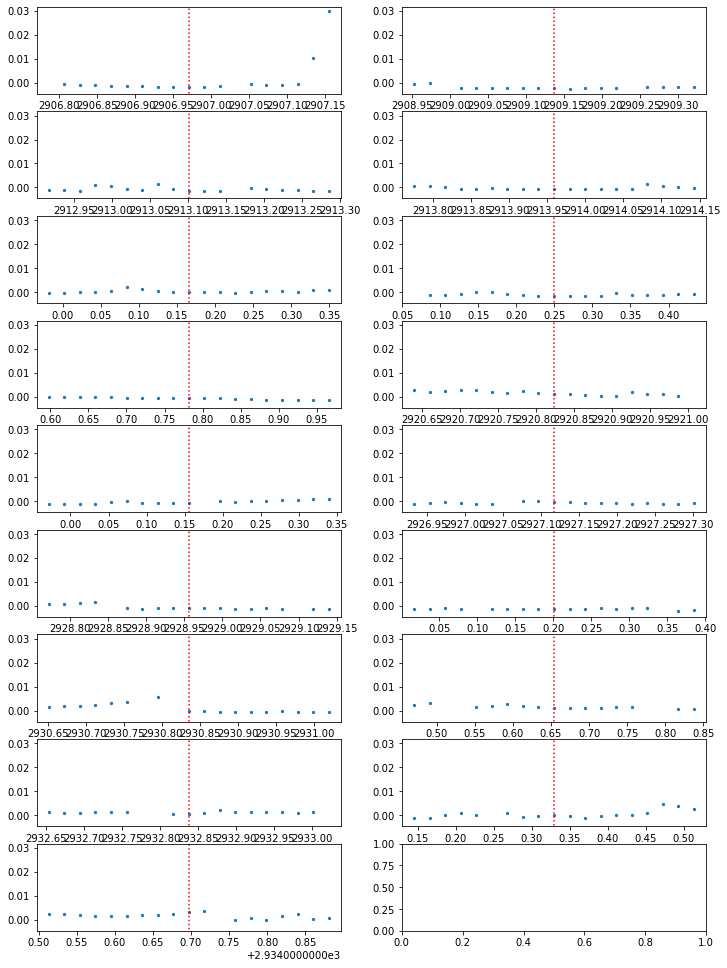

In [25]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(len(istart_gap_pre)/2).astype(int), figsize=[12,len(istart_gap_pre)])
axes = axes.flatten()
for i in range(len(istart_gap_pre)):
    ax = axes[i]
    ax.scatter(pre.TIME, norm_flux_pre-pred_pre, s=5)
    #ax.axvline(tpeaks[i], np.min(y), np.max(y), color='r', linestyle=':')
    ax.axvline(pre.TIME[istart_gap_pre[i]], -1, 1, color='r', linestyle=':')
    ax.set_xlim(pre.TIME[istart_gap_pre[i]]-0.2, pre.TIME[istart_gap_pre[i]]+0.2)
    #ax.set_ylim(np.min(y), np.max(ampls[i]+3))

Uh...not good. 

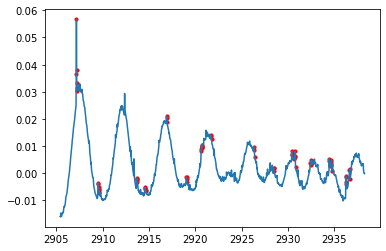

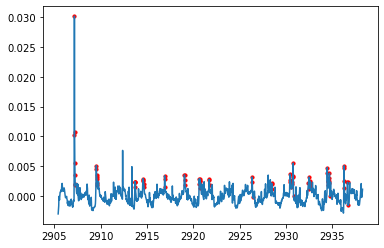

In [26]:
plt.plot(pre.TIME, norm_flux_pre)
plt.scatter(np.array(pre.TIME)[candidates_pre], np.array(norm_flux_pre)[candidates_pre], c='r', s=10)
#plt.xlim(2932, 2933)
#plt.xlim(2911, 2913)
plt.show()

plt.plot(pre.TIME, norm_flux_pre-pred_pre)
plt.scatter(np.array(pre.TIME)[candidates_pre], np.array(norm_flux_pre-pred_pre)[candidates_pre], c='r', s=10)
#plt.xlim(2932, 2933)
#plt.xlim(2911, 2913)
plt.show()



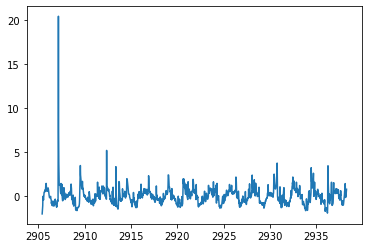

In [27]:
norm_flux_pre = pre.PDCSAP_FLUX/np.median(pre.PDCSAP_FLUX) - 1 
plt.plot(pre.TIME, (norm_flux_pre-pred_pre)/np.std(norm_flux_pre-pred_pre))
plt.show()

Amend recover_flares() to also return pass_thresholds. So it seems that legitimate flares get thrown out during the N3 check.

In [28]:
def recover_flares(df, flux, pred, N1, N2, N3, minsep, norm_flag):
    """
    Params:
    - df: DataFrame from which error comes (PDCSAP_FLUX_ERR), as well as real flux (PDCSAP_FLUX) for median division
    - flux: normalized GP-predicted flux with flares injected OR normalized flux data
    - pred: GP-predicted flux
    - N1: int or float (default is 3)
        How many times above sigma is required.
    - N2: int or float (Default is 3)
        How many times above sigma and detrended_flux_err is required
    - N3: int or float (Default is 2)
        The number of consecutive points required to flag as a flare.
    - minsep: 1 or int
        minimum distance between two candidate start times in datapoints
    - norm_flag: True or False
        Are you feeding in normalized flux or unnormalized flux?
    Returns:
    - candidates: flare points
    - istart_gap: flare start indices
    - istop_gap: flare stop indices
    """

    error = df.PDCSAP_FLUX_ERR
    real_flux = df.PDCSAP_FLUX
    
    if norm_flag==True:
        """
        the old way
        #var = pre.PDCSAP_FLUX_ERR
        T0 = flux 
        T1 = np.abs(flux) / np.std(flux) #N1
        T2 = np.abs(flux - np.sqrt(var)) / np.std(flux) #N2
        """
        T0 = flux - pred # flux data minus the GP-smoothed quiescent, flare-pared flux
        T1 = T0/np.std(T0)
        T2_numerator = T0-(error/np.median(real_flux)) # whether flux is real_flux or not, since error is real, so is median(flux)
        T2 = T2_numerator/np.std(T2_numerator)
        
    elif norm_flag=='Altaipony': # this was just for testing
        median = np.median(flux)
        sigma = np.std(flux)
        T0 = flux - median # excursion should be positive #"N0"
        T1 = np.abs(flux - median) / sigma #N1
        T2 = np.abs(flux - median - error) / sigma #N2
        #print("T0: ", T0)
        #print("T1: ", T1)
        #print("T2: ", T2)
        # hold on, this doesn't seem to get me what I'd expect (see plots in cell above)
        
    minsep = 3
    istart = np.array([], dtype='int')
    istop = np.array([], dtype='int')

    pass_thresholds = np.where((T0 > 0) & (T1 > N1) & (T2 > N2))
    #print("pass thresholds: ", pass_thresholds)
    
    #array of indices where thresholds are exceeded:
    is_pass_thresholds = np.zeros_like(flux)
    is_pass_thresholds[pass_thresholds] = 1

    # test based on consecutive points
    reverse_counts = np.zeros_like(flux, dtype='int')
    for k in range(2, len(flux)):
        reverse_counts[-k] = (is_pass_thresholds[-k]
                                * (reverse_counts[-(k-1)]
                                + is_pass_thresholds[-k]))

    # find flare start where values in reverse_counts switch from 0 to >=N3
    istart_i = np.where((reverse_counts[1:] >= N3) &
                        (reverse_counts[:-1] - reverse_counts[1:] < 0))[0] + 1

    # use the value of reverse_counts to determine how many points away stop is
    istop_i = istart_i + (reverse_counts[istart_i])

    # Create boolean flare mask
    isflare = np.zeros_like(flux, dtype='bool')

    for (l,r) in list(zip(istart_i, istop_i)):
        isflare[l:r+1] = True

    # now pick out final flare candidate indices
    candidates = np.where( isflare > 0)[0]
    #print("candidates: ", candidates)
    if (len(candidates) < 1): # no candidates = no indices
        istart_gap = np.array([])
        istop_gap = np.array([])
    else:
        # find start and stop index, combine neighboring candidates
        # in to same events
        separated_candidates = np.where( (np.diff(candidates)) > minsep )[0]
        istart_gap = candidates[ np.append([0], separated_candidates + 1) ]
        istop_gap = candidates[ np.append(separated_candidates,
                                [len(candidates) - 1]) ]

    #print(istart_gap)
    #print(istop_gap)
    #stitch indices back into the original light curve
    #istart = np.array(np.append(istart, istart_gap + le), dtype='int')
    #istop = np.array(np.append(istop, istop_gap + le), dtype='int')

    #print(len(istart_gap))
    
    return candidates, istart_gap, istop_gap, pass_thresholds

N1 = 1.3
N2 = 1.3
N3 = 2
candidates_pre, istart_gap_pre, istop_gap_pre, pass_thresholds_pre = recover_flares(pre, norm_flux_pre, pred_pre, 
                                                               N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=True)
candidates_post, istart_gap_post, istop_gap_post, pass_thresholds_post = recover_flares(pre, norm_flux_pre, pred_pre, 
                                                               N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=True)
candidates_postgap, istart_gap_postgap, istop_gap_postgap, pass_thresholds_postgap = recover_flares(pre, norm_flux_pre, pred_pre, 
                                                               N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=True)


In [29]:
def recover_flares_scipy(df, flux, pred, N1, N3, minsep, norm_flag):
    """
    Params:
    - df: DataFrame from which error comes (PDCSAP_FLUX_ERR), as well as real flux (PDCSAP_FLUX) for median division
    - flux: normalized GP-predicted flux with flares injected OR normalized flux data
    - pred: GP-predicted flux
    - N1: int or float (default is 3)
        How many times above sigma is required.
    - N3: int or float (Default is 2)
        The number of consecutive points required to flag as a flare.

    Returns:
    - peaks: tpeaks
    - prominences: prominences
    - left_bases: istart_gap
    - right_bases: istop_gap
    """

    norm = flux - pred
    norm_std = norm/np.std(norm)
    
    peaks, _ = find_peaks((norm_flux_pre-pred_pre)/np.std(norm_flux_pre-pred_pre), height=N1, distance=N3)
    prominences, left_bases, right_bases = peak_prominences((norm_flux_pre-pred_pre)/np.std(norm_flux_pre-pred_pre), peaks)
    
    return peaks, prominences, left_bases, right_bases

def analyze_recovery_scipy(df, t0_fake, istart_gap, istop_gap):
    # analyze_recovery(pre, t0_fake_pre, istart_gap_pre, istop_gap_pre)
    """
    Calculate TPs, FPs, and FNs
    Params: 
    - df: original DataFrame cut into pre/post/postgap/whatever
    - t0_fake: one of the outputs of inject_fakes(); all of the ground truth flare start times
    - istart_gap: one of the outputs of recover_flares(); all the flare start time indices
    - istop_gap: one of the outputs of recover_flares(); all the flare stop time indices
    Returns:
    - TPs: true positives (int)
    - FPs: false positives (int)
    - FNs: false negatives (int)
    """
    try:
        pred_flares = pd.DataFrame({'istart': np.array(df.TIME)[istart_gap], 
                                    'istop': np.array(df.TIME)[istop_gap],
                                   'gap': np.array(df.TIME)[istop_gap]-np.array(df.TIME)[istart_gap]})
    except:
        print("no true positives")
        return 
    
    tps = 0
    for i in t0_fake:
        # exploit the shape of the flare for some breathing room: if t0 is within max(istop-istart) of istart, then it's a TP
        if (np.abs(i - pred_flares['istart']) < np.max(pred_flares['gap'])).any():
            tps += 1
    
    fps = np.abs(len(istart_gap) - tps)    
    fns = len(t0_fake) - tps
    
    return tps, fps, fns

### 6.5 Good 'ol scipy.signal.find_peaks

Before I do any injection-recovery analysis, I need to find find_peaks() and peak_prominences() parameters that don't lead to repetitive left_bases or right_bases.

In [30]:
height = 1.3
distance = 10
wlen = 10
width_left = 1
width_right = 8
peaks, _ = find_peaks((norm_flux_pre-pred_pre)/np.std(norm_flux_pre-pred_pre), height=height, distance=distance, 
                      width=(width_left,width_right), wlen=wlen)
#print(peaks, len(peaks))
prominences, left_bases, right_bases = peak_prominences((norm_flux_pre-pred_pre)/np.std(norm_flux_pre-pred_pre), peaks)
print(prominences, len(prominences), len(left_bases), len(right_bases))
#print(left_bases)
#print(right_bases)

flares_scipy = pd.DataFrame({'peaks': peaks, 'left_bases': left_bases, 'right_bases': right_bases})
print(flares_scipy)

[ 2.68045247 22.32562149  1.12818053  1.88961768  4.56634605  0.86078721
  1.94070092  4.49113667  2.2304281   3.2772193   1.55840087  3.40310764
  3.77234685  1.12827656  1.93533987  2.28110993  1.70241931  2.84926844
  2.23138994  1.08694056  3.3994838   1.6009994   3.75001144  1.45654547
  1.42019384  1.68328005  5.2192564   3.46781921  1.18820602  4.87065947
  1.67637718  4.48897779  2.43762922  2.55427194  1.57429652] 35 35 35
    peaks  left_bases  right_bases
0      19           0           70
1      79           0         1415
2      91          89          169
3     140          99          169
4     185         169          250
5     195         193          250
6     270         250          282
7     364         363          374
8     378         374          389
9     420         374          468
10    488         468          495
11    528         374          593
12    630         374          887
13    719         718          728
14    730         728          742
15  

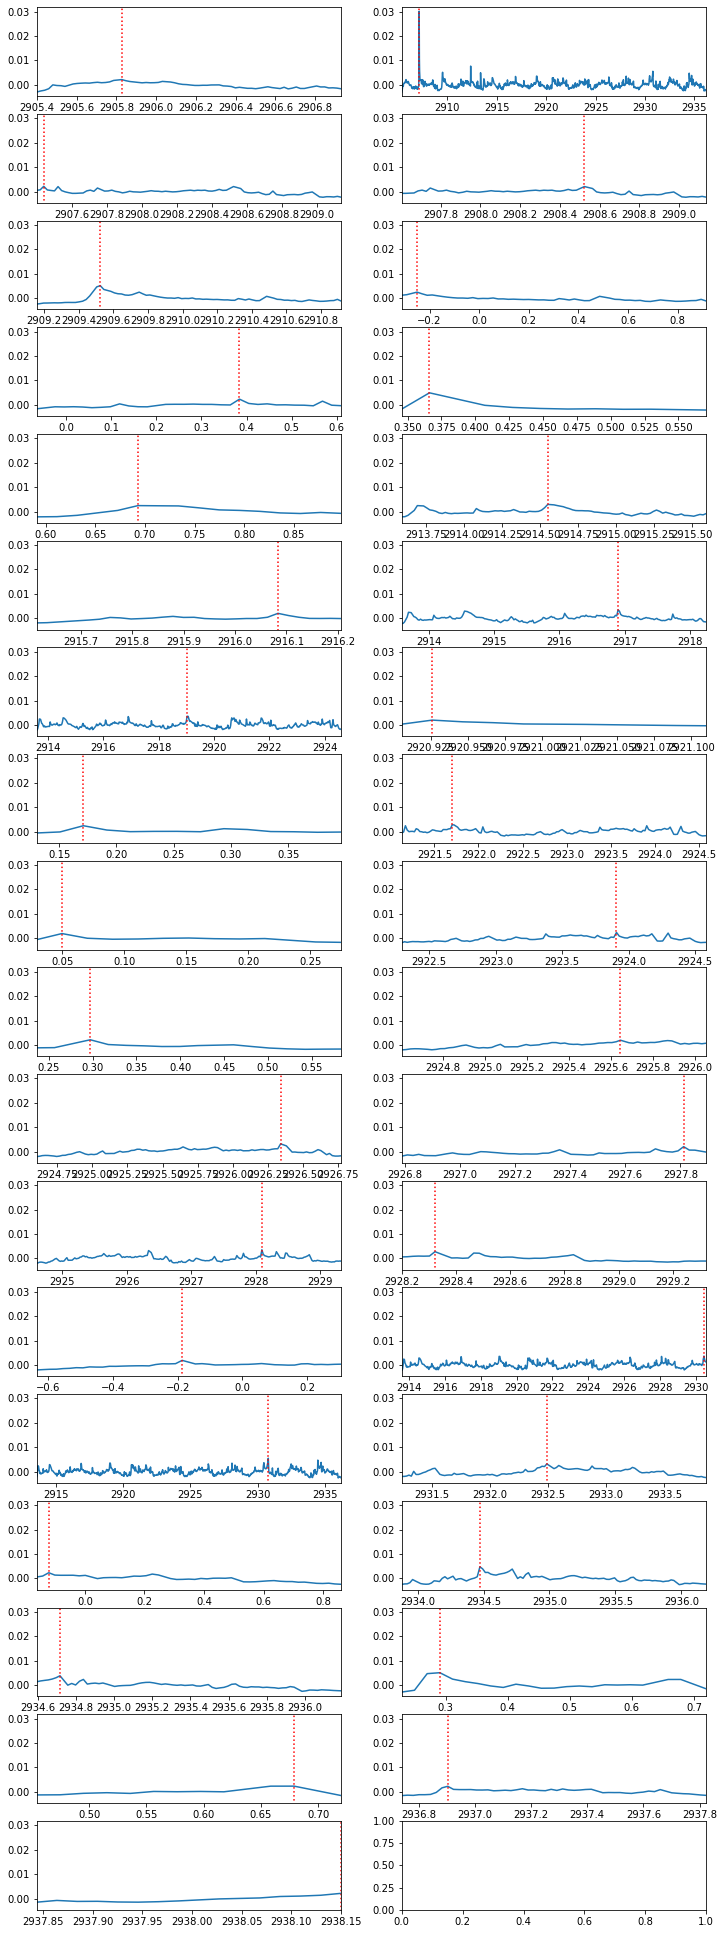

In [31]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(len(peaks)/2).astype(int), figsize=[12,len(peaks)])
axes = axes.flatten()

for i in range(len(peaks)):    
    snapshot = (norm_flux_pre-pred_pre).iloc[left_bases[i]:right_bases[i]]
    """
    tpeak = pre.TIME[snapshot.idxmax()]
    ampl = snapshot.max()
    #half_max_left = snapshot.loc[(snapshot >= 0.5*ampl) & ()
    #fwhm = np.asarray(npts) * (2/1440)
    peaks, _ = find_peaks(snapshot.array)
    fwhm = get_fwhm(snapshot)
    fwhms.append(fwhm)
    tpeaks.append(tpeak)
    ampls.append(ampl)
    """
    ax = axes[i]
    ax.plot(pre.TIME, norm_flux_pre-pred_pre)
    ax.axvline(pre.TIME.iloc[peaks[i]], -1, 1, color='r', linestyle=':')
    ax.set_xlim(pre.TIME[snapshot.index].min(), pre.TIME[snapshot.index].max())
    #ax.set_xlim(pre.TIME[istart_gap_pre[i]]-0.2, pre.TIME[istart_gap_pre[i]]+0.2)
    #ax.set_ylim(np.min(y), np.max(ampls[i]+3))
plt.show()

#### Calculate ampls and fwhms

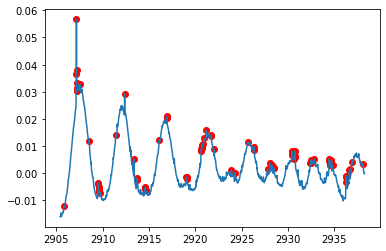

In [32]:
plt.plot(pre.TIME, norm_flux_pre)
plt.scatter(np.array(pre.TIME)[pass_thresholds_pre], np.array(norm_flux_pre)[pass_thresholds_pre], c='r')

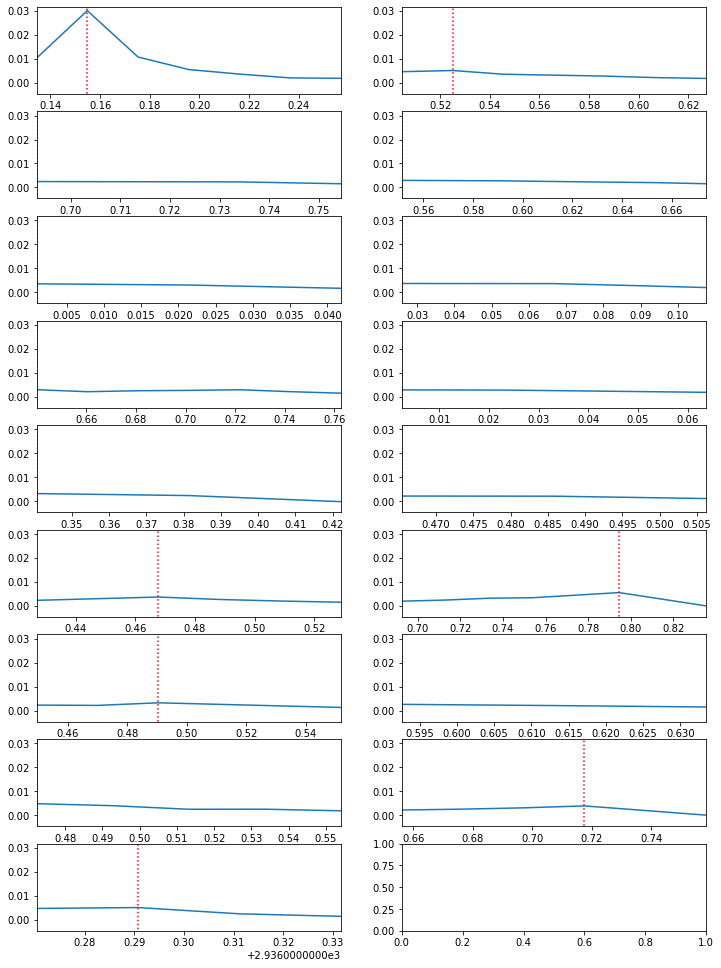

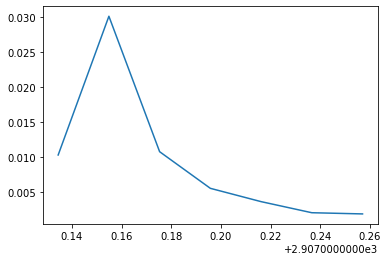

In [33]:
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

def get_fwhm(snapshot): # eh, let's use scipy.signal.peak_prominences instead 
    """
    snapshot: a single pd.Series chunk that's the output of consecutive(data), where data is the output of recover_flares()
    """
    fwhm = peak_widths(snapshot.array, [snapshot.argmax()], rel_height=0.5)[0][0]*30*60 # 30 min cadence in seconds 
    # ie. if the snapshot is too narrow for peak_widths to work
    if fwhm == 0: 
        # assert that the equivalent duration is just half of istop-istart
        fwhm = (snapshot.index.max()-snapshot.index.min())*30*60*0.5
        
    return fwhm

"""
print(candidates_pre)
print(consecutive(candidates_pre))
print(consecutive(candidates_pre)[0])
print(pre.TIME.iloc[consecutive(candidates_pre)[0]])
print((norm_flux_pre-pred_pre))
"""

fig, axes = plt.subplots(ncols=2, nrows=np.ceil(len(istart_gap_pre)/2).astype(int), figsize=[12,len(istart_gap_pre)])
axes = axes.flatten()
tpeaks = []
ampls = []
fwhms = []
for i in range(len(istart_gap_pre)):    
    snapshot = (norm_flux_pre-pred_pre).iloc[consecutive(candidates_pre)[i]]
    tpeak = pre.TIME[snapshot.idxmax()]
    ampl = snapshot.max()
    #half_max_left = snapshot.loc[(snapshot >= 0.5*ampl) & ()
    #fwhm = np.asarray(npts) * (2/1440)
    peaks, _ = find_peaks(snapshot.array)
    fwhm = get_fwhm(snapshot)
    fwhms.append(fwhm)
    tpeaks.append(tpeak)
    ampls.append(ampl)
    
    ax = axes[i]
    ax.plot(pre.TIME, norm_flux_pre-pred_pre)
    ax.axvline(tpeak, -1, 1, color='r', linestyle=':')
    ax.set_xlim(pre.TIME[snapshot.index].min(), pre.TIME[snapshot.index].max())
    #ax.set_xlim(pre.TIME[istart_gap_pre[i]]-0.2, pre.TIME[istart_gap_pre[i]]+0.2)
    #ax.set_ylim(np.min(y), np.max(ampls[i]+3))
plt.show()

#print((norm_flux_pre-pred_pre).iloc[consecutive(candidates_pre)[0]])
#print(np.argmax((norm_flux_pre-pred_pre).iloc[consecutive(candidates_pre)[0]]))

flares = pd.DataFrame({'istart': istart_gap_pre, 'istop': istop_gap_pre, 'tpeak': tpeaks, 'ampls': ampls, 'fwhms': fwhms})
plt.plot(pre.TIME.iloc[consecutive(candidates_pre)[0]], (norm_flux_pre-pred_pre).iloc[consecutive(candidates_pre)[0]])
#plt.axvline(pre.TIME[consecutive
plt.show()

In [34]:
flares

istart  istop        tpeak     ampls        fwhms
0       78     84  2907.154837  0.030113  1821.957585
1      184    190  2909.524974  0.005143  1191.823462
2      378    381  2913.693127  0.002454  2700.000000
3      420    424  2914.551273  0.002944  5400.000000
4      528    530  2916.900956  0.003435  1800.000000
5      630    633  2919.025881  0.003574  3600.000000
6      705    711  2920.640003  0.002917  5400.000000
7      756    758  2921.702462  0.002827  2700.000000
8      968    970  2926.340490  0.003218  3600.000000
9     1064   1066  2928.465395  0.002188  1800.000000
10    1154   1158  2930.467706  0.003709  2127.645487
11    1166   1171  2930.794614  0.005553  2082.129567
12    1246   1253  2932.490445  0.003222  1404.057865
13    1335   1339  2932.592604  0.002578  1800.000000
14    1344   1348  2934.472318  0.004779  3600.000000
15    1417   1420  2934.717498  0.003853  2364.461507
16    1435   1437  2936.290736  0.005099  1031.419047

#### What if I combined find_peaks() with xoflares find_flares()? Either way, I need to add find_peaks() to recover_flares() to analyze its injection-recovery effectiveness. We can see if that enables better models from pymc3. Otherwise, I may have to craft a bootstrap from scratch to do manually flare by flare.

Instead of GPs, how about savgol?

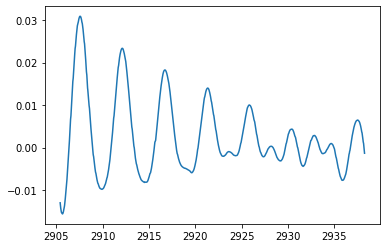

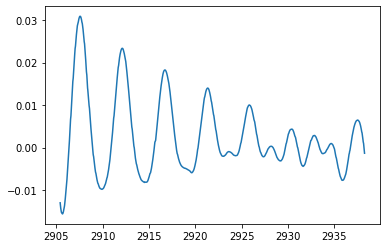

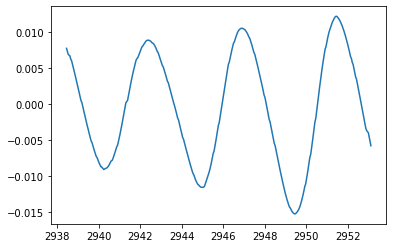

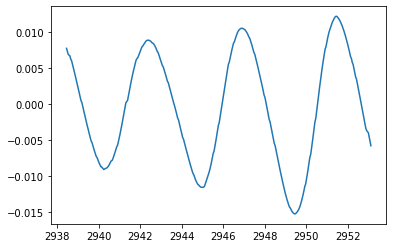

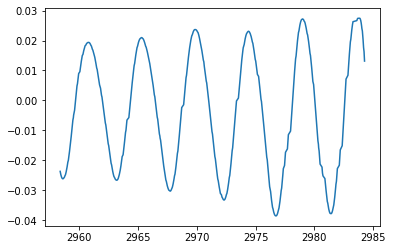

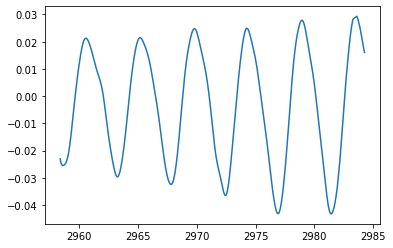

In [35]:
from scipy.signal import savgol_filter

def normalize_flux(flux):
    return flux/np.median(flux) - 1

norm_pre = normalize_flux(pre.PDCSAP_FLUX)
norm_post = normalize_flux(post.PDCSAP_FLUX)
norm_postgap = normalize_flux(postgap.PDCSAP_FLUX)

savgol_pre = savgol_filter(norm_pre, 109, polyorder=3)
savgol_post = savgol_filter(norm_post, 149, polyorder=3)
savgol_postgap = savgol_filter(norm_postgap, 129, polyorder=3)

plt.plot(pre.TIME, savgol_pre)
plt.show()

plt.plot(pre.TIME, pred_pre) # oops, was previously the GP model
plt.show()


plt.plot(post.TIME, savgol_post)
plt.show()

plt.plot(post.TIME, pred_post) # oops, was previously the GP model
plt.show()


plt.plot(postgap.TIME, savgol_postgap)
plt.show()

plt.plot(postgap.TIME, pred_postgap)
plt.show()

Looks like savgol has GPs beat for pre and post, but GP is a better detrending for postgap. So we'll use savgol_pre, savgol_post, and pred_postgap.

### 7) Flare recovery and identification: xoflares

I'm going to switch to xoflares because that already has fwhm calculations built in. The only thing I need to do is adapt it to allow for injection recovery.

In [36]:
# calculate reference (average) time
def calculate_ref_time(lc):
    return 0.5 * (np.min(lc.TIME) + np.max(lc.TIME))

def find_flares(lc, flux, pred, N1, N2):
    """
    Adapted from Tom Barclay's xoflares: https://github.com/mrtommyb/xoflares
    Params:
    - lc: DataFrame with PDCSAP_FLUX_ERR, PDCSAP_FLUX, and CADENCENO fields
    - flux:  GP-predicted flux with flares injected
    - pred: GP-predicted spot modulation flux
    - N1: int or float (default is 3)
        How many times above sigma is required.
    - N2: int or float (Default is 3)
        How many times above sigma and detrended_flux_err is required
        
    Returns:
    - x: lc.TIME - ref_time
    - y: flux param
    - tpeaks: start time of flares (corresponds to lc.TIME)
    - tpeaks_norm: start time of flares (normalized to correspond to x)
    - ampls: flare amplitudes
    - fwhms: full-width half-maxes of flares
    - npeaks: number of flares identified
    """
    
    # find some flares
    #mflare = flux < N1 * np.sqrt(np.mean(flux**2))
    unnorm_flux = flux-pred # save this for ampls
    flux = (flux-pred)/np.std(flux-pred) # subtract out GP-modeled spot modulation flux
    mflare = (flux < N1) & (flux - lc.PDCSAP_FLUX_ERR/np.median(lc.PDCSAP_FLUX) < N2)

    """
    # this part is from Altaipony/Appaloosa
    is_pass_thresholds = np.array(mflare)
    # test based on consecutive points
    reverse_counts = np.zeros_like(flux, dtype='int')
    for k in range(2, len(flux)):
        reverse_counts[-k] = (is_pass_thresholds[-k]
                                * (reverse_counts[-(k-1)]
                                + is_pass_thresholds[-k]))

    N3 = 2
    # find flare start where values in reverse_counts switch from 0 to >=N3
    istart_i = np.where((reverse_counts[1:] >= N3) &
                        (reverse_counts[:-1] - reverse_counts[1:] < 0))[0] + 1

    # use the value of reverse_counts to determine how many points away stop is
    istop_i = istart_i + (reverse_counts[istart_i])

    # Create boolean flare mask
    isflare = np.zeros_like(flux, dtype='bool')

    for (l,r) in list(zip(istart_i, istop_i)):
        isflare[l:r+1] = True

    # now pick out final flare candidate indices
    candidates = np.where( isflare > 0)[0]
    #print("candidates: ", candidates)
    if (len(candidates) < 1): # no candidates = no indices
        istart_gap = np.array([])
        istop_gap = np.array([])
    else:
        # find start and stop index, combine neighboring candidates
        # in to same events
        separated_candidates = np.where( (np.diff(candidates)) > minsep )[0]
        istart_gap = candidates[ np.append([0], separated_candidates + 1) ]
        istop_gap = candidates[ np.append(separated_candidates,
                                [len(candidates) - 1]) ]
    print(candidates)
    print(istart_gap)
    print(istop_gap)
    print(len(istart_gap), len(candidates))
    """
    
    # resume flare identification code from xoflares
    cads = lc.CADENCENO - list(lc.CADENCENO)[0] # index CADENCENO at 0
    ref_time = calculate_ref_time(lc)
    x = lc.TIME - ref_time # subtract time by average time
    y = flux # data with savgol subtracted OR normalized data

    fidx = cads.loc[~mflare][:-1]#[np.diff(cads[~mflare]) < 1]
    fidx = list(fidx) # address indexing errors
    npts = np.array([])
    i = 0
    n = 1
    while True:
        try:
            if fidx[i + 1] == fidx[i] + n:
                # measure flare: keep track of number of points (fatness) of a flare
                # if I care about consecutive points, this is where I'd deal with it
                fidx = np.delete(fidx, i + 1)
                n += 1
            else:
                # count flare: concatenate to array, advance, and reset count
                npts = np.r_[npts, n+1] 
                i += 1
                n = 1
        except IndexError:
            npts = np.r_[npts, n+1]
            break
    tpeaks = np.array([lc.TIME.loc[cads == fidx[i]].values for i in range(len(fidx))]).T[0]
    tpeaks_norm = np.array([x.loc[cads == fidx[i]].values for i in range(len(fidx))]).T[0]
    try: # if flux given is a DataFrame (eg. norm_flux_pre)
        unnorm_ampls = np.array([unnorm_flux.loc[cads == fidx[i]].values for i in range(len(fidx))]).T[0]
        ampls = np.array([flux.loc[cads == fidx[i]].values for i in range(len(fidx))]).T[0]
    except: # if flux given is a np.array (eg. flux_pre)
        unnorm_ampls = np.array([unnorm_flux[cads == fidx[i]] for i in range(len(fidx))]).T[0]
        ampls = np.array([flux[cads == fidx[i]] for i in range(len(fidx))]).T[0]
    fwhms = np.asarray(npts) * (2/1440) 
    npeaks = np.shape(tpeaks)[0]
    #print(tpeaks, ampls, fwhms, npeaks)
    #print(fidx)
    return x, y, tpeaks, tpeaks_norm, ampls, unnorm_ampls, fwhms, npeaks

def analyze_recovery_for_xoflares(tpeaks, t0_fake, tol):
    # analyze_recovery(pre, t0_fake_pre, istart_gap_pre, istop_gap_pre)
    """
    Calculate TPs, FPs, and FNs
    Params: 
    - tpeaks: recovered tpeaks (so not really start times, but we'll use a tolerance to get around that
    - t0_fake: one of the outputs of inject_fakes(); all of the ground truth flare start times
    - tol: tolerance [days]
    Returns:
    - TPs: true positives (int)
    - FPs: false positives (int)
    - FNs: false negatives (int)
    """
    tps = 0
    print(len(tpeaks))
    for i in t0_fake:
        if (np.abs(i - tpeaks) < tol).any():
            tps += 1
    
    fps = np.abs(len(tpeaks) - tps)    
    fns = len(t0_fake) - fps - tps
    
    return tps, fps, fns

N1 = 1.3
N2 = 1.3
#x, y, tpeaks, tpeaks_norm, ampls, fwhms, npeaks = find_flares(pre, norm_flux_pre, pred_pre, N1, N2)
#_, _, tpeaks_pre, _, _, _, _ = find_flares(pre, flux_pre, pred_pre, N1, N2) 
#_, _, tpeaks_post, _, _, _, _ = find_flares(post, flux_post, pred_post, N1, N2)
_, _, tpeaks_pre, _, _, _, _, _ = find_flares(pre, flux_pre, savgol_pre, N1, N2)
_, _, tpeaks_post, _, _, _, _, _ = find_flares(post, flux_post, savgol_post, N1, N2)
_, _, tpeaks_postgap, _, _, _, _, _ = find_flares(postgap, flux_postgap, pred_postgap, N1, N2)

idx_interval = pre.TIME[2] - pre.TIME[1] # time spanned by one index
tol = 3 # reminiscent of minsep from altaipony        
tps_pre, fps_pre, fns_pre = analyze_recovery_for_xoflares(tpeaks_pre, t0_fake_pre, tol=tol*idx_interval)
tps_post, fps_post, fns_post = analyze_recovery_for_xoflares(tpeaks_post, t0_fake_post, tol=tol*idx_interval)
tps_postgap, fps_postgap, fns_postgap = analyze_recovery_for_xoflares(tpeaks_postgap, 
                                                                      t0_fake_postgap, tol=tol*idx_interval)

print(tps_pre, fps_pre, fns_pre)
print(tps_post, fps_post, fns_post)
print(tps_postgap, fps_postgap, fns_postgap)


17
5
17
17 0 3
5 0 5
17 0 3


Note that my assessment of TPs is not perfect. For example, I've only predicted 16 flares in pre; yet, I have 18 TPs (another sign is that 16+2+2 is not 20). But most likely, pre is 16 TP, 0 FP, and 4 FN.

Okay, so savgol vs GP makes no difference with my light curve (toggle between first two and second two find_flares() runs in cell above).

Let's identify some real flares and hope they're finally right.

In [37]:
x_pre, y_pre, tpeaks_pre, tpeaks_norm_pre, ampls_pre, unnorm_ampls_pre, fwhms_pre, npeaks_pre = find_flares(pre, norm_flux_pre, 
                                                                                          savgol_pre, N1, N2)
x_post, y_post, tpeaks_post, tpeaks_norm_post, ampls_post, unnorm_ampls_post, fwhms_post, npeaks_post = find_flares(post, norm_flux_post, 
                                                                                          savgol_post, N1, N2)
x_postgap, y_postgap, tpeaks_postgap, tpeaks_norm_postgap, ampls_postgap, unnorm_ampls_postgap, fwhms_postgap, npeaks_postgap = find_flares(postgap,
                                                                        norm_flux_postgap, pred_postgap, N1, N2)
print(npeaks_pre, npeaks_post, npeaks_postgap)

48 16 23


In [38]:
print(len(x_pre), len(y_pre), len(tpeaks_pre), len(tpeaks_norm_pre), len(ampls_pre), len(fwhms_pre))
out_pre = pd.DataFrame({'tpeak': tpeaks_pre, 'tpeaks_norm': tpeaks_norm_pre, 'ampls': ampls_pre, 'unnorm_ampls': unnorm_ampls_pre, 'fwhms': fwhms_pre})
out_post = pd.DataFrame({'tpeak': tpeaks_post, 'tpeaks_norm': tpeaks_norm_post, 'ampls': ampls_post, 'unnorm_ampls': unnorm_ampls_post, 'fwhms': fwhms_post})
out_postgap = pd.DataFrame({'tpeak': tpeaks_postgap, 'tpeaks_norm': tpeaks_norm_postgap, 'ampls': ampls_postgap, 'unnorm_ampls': unnorm_ampls_postgap,
                            'fwhms': fwhms_postgap})
out = pd.concat([out_pre, out_post, out_postgap]).reset_index()
print(out)
print(out.loc[out.ampls>0])
#out.to_csv('identified_flares.csv', index=False)

1511 1511 48 48 48 48
    index        tpeak  tpeaks_norm     ampls  unnorm_ampls     fwhms
0       0  2905.826740   -16.018609  1.458995      0.002152  0.002778
1       1  2907.134405   -14.710944  6.983271      0.010299  0.009722
2       2  2907.297863   -14.547486  1.309872      0.001932  0.002778
3       3  2907.440889   -14.404460  1.451282      0.002140  0.002778
4       4  2907.522618   -14.322731  1.368187      0.002018  0.002778
..    ...          ...          ...       ...           ...       ...
82     18  2977.991542     6.670886  1.682145      0.002124  0.002778
83     19  2978.216291     6.895634  1.356167      0.001713  0.002778
84     20  2979.176580     7.855923  1.439159      0.001818  0.002778
85     21  2979.626077     8.305420  1.309828      0.001654  0.002778
86     22  2981.669248    10.348591  4.987364      0.006299  0.004167

[87 rows x 6 columns]
    index        tpeak  tpeaks_norm     ampls  unnorm_ampls     fwhms
0       0  2905.826740   -16.018609  1.458995

In [39]:
pred_pre_df = pd.DataFrame(savgol_pre, columns=['flux_norm'])
pred_post_df = pd.DataFrame(savgol_post, columns=['flux_norm'])
pred_postgap_df = pd.DataFrame(pred_postgap, columns=['flux_norm'])
pred_df = pd.concat([pred_pre_df, pred_post_df, pred_postgap_df])
print(pred_df)
#pred_df.to_csv('preds.csv',index=False)

      flux_norm
0     -0.012985
1     -0.013459
2     -0.013883
3     -0.014258
4     -0.014585
...         ...
1066   0.018153
1067   0.017673
1068   0.016795
1069   0.016409
1070   0.016069

[3253 rows x 1 columns]


### 7.5 xoflares + scipy.signal.find_peaks()

Take flares identified by xoflares and get tpeaks, istart, and istop using find_peaks(), as well as prune identified flares that don't actually have a peak.

#### Recovery analysis on fake flares

In [40]:
# calculate reference (average) time
def calculate_ref_time(lc):
    return 0.5 * (np.min(lc.TIME) + np.max(lc.TIME))

def find_flares(lc, flux, pred, N1, N2):
    """
    Adapted from Tom Barclay's xoflares: https://github.com/mrtommyb/xoflares
    Params:
    - lc: DataFrame with PDCSAP_FLUX_ERR, PDCSAP_FLUX, and CADENCENO fields
    - flux:  GP-predicted flux with flares injected
    - pred: GP-predicted spot modulation flux
    - N1: int or float (default is 3)
        How many times above sigma is required.
    - N2: int or float (Default is 3)
        How many times above sigma and detrended_flux_err is required
        
    Returns:
    - x: lc.TIME - ref_time
    - y: flux param
    - tpeaks: start time of flares (corresponds to lc.TIME)
    - tpeaks_norm: start time of flares (normalized to correspond to x)
    - ampls: flare amplitudes
    - fwhms: full-width half-maxes of flares
    - npeaks: number of flares identified
    """
    
    # find some flares
    #mflare = flux < N1 * np.sqrt(np.mean(flux**2))
    unnorm_flux = flux-pred # save this for ampls
    flux = (flux-pred)/np.std(flux-pred) # subtract out GP-modeled spot modulation flux
    mflare = (flux < N1) & (flux - lc.PDCSAP_FLUX_ERR/np.median(lc.PDCSAP_FLUX) < N2)

    """
    # this part is from Altaipony/Appaloosa
    is_pass_thresholds = np.array(mflare)
    # test based on consecutive points
    reverse_counts = np.zeros_like(flux, dtype='int')
    for k in range(2, len(flux)):
        reverse_counts[-k] = (is_pass_thresholds[-k]
                                * (reverse_counts[-(k-1)]
                                + is_pass_thresholds[-k]))

    N3 = 2
    # find flare start where values in reverse_counts switch from 0 to >=N3
    istart_i = np.where((reverse_counts[1:] >= N3) &
                        (reverse_counts[:-1] - reverse_counts[1:] < 0))[0] + 1

    # use the value of reverse_counts to determine how many points away stop is
    istop_i = istart_i + (reverse_counts[istart_i])

    # Create boolean flare mask
    isflare = np.zeros_like(flux, dtype='bool')

    for (l,r) in list(zip(istart_i, istop_i)):
        isflare[l:r+1] = True

    # now pick out final flare candidate indices
    candidates = np.where( isflare > 0)[0]
    #print("candidates: ", candidates)
    if (len(candidates) < 1): # no candidates = no indices
        istart_gap = np.array([])
        istop_gap = np.array([])
    else:
        # find start and stop index, combine neighboring candidates
        # in to same events
        separated_candidates = np.where( (np.diff(candidates)) > minsep )[0]
        istart_gap = candidates[ np.append([0], separated_candidates + 1) ]
        istop_gap = candidates[ np.append(separated_candidates,
                                [len(candidates) - 1]) ]
    print(candidates)
    print(istart_gap)
    print(istop_gap)
    print(len(istart_gap), len(candidates))
    """
    
    # resume flare identification code from xoflares
    cads = lc.CADENCENO - list(lc.CADENCENO)[0] # index CADENCENO at 0
    ref_time = calculate_ref_time(lc)
    x = lc.TIME - ref_time # subtract time by average time
    y = flux # data with savgol subtracted OR normalized data

    fidx = cads.loc[~mflare][:-1]#[np.diff(cads[~mflare]) < 1]
    fidx = list(fidx) # address indexing errors
    npts = np.array([])
    i = 0
    n = 1
    while True:
        try:
            if fidx[i + 1] == fidx[i] + n:
                # measure flare: keep track of number of points (fatness) of a flare
                # if I care about consecutive points, this is where I'd deal with it
                fidx = np.delete(fidx, i + 1)
                n += 1
            else:
                # count flare: concatenate to array, advance, and reset count
                npts = np.r_[npts, n+1] 
                i += 1
                n = 1
        except IndexError:
            npts = np.r_[npts, n+1]
            break
            
    tpeaks = np.array([lc.TIME.loc[cads == fidx[i]].values for i in range(len(fidx))]).T[0]
    tpeaks_norm = np.array([x.loc[cads == fidx[i]].values for i in range(len(fidx))]).T[0]
    try: # if flux given is a DataFrame (eg. norm_flux_pre)
        unnorm_ampls = np.array([unnorm_flux.loc[cads == fidx[i]].values for i in range(len(fidx))]).T[0]
        ampls = np.array([flux.loc[cads == fidx[i]].values for i in range(len(fidx))]).T[0]
    except: # if flux given is a np.array (eg. flux_pre)
        unnorm_ampls = np.array([unnorm_flux[cads == fidx[i]] for i in range(len(fidx))]).T[0]
        ampls = np.array([flux[cads == fidx[i]] for i in range(len(fidx))]).T[0]
    fwhms = np.asarray(npts) * (2/1440) 
    npeaks = np.shape(tpeaks)[0]
    #print(tpeaks, ampls, fwhms, npeaks)
    #print(fidx)
    
    ### enter: scipy.signal.find_peaks() for cleanup duty
    height = 1.1
    distance = 10
    wlen = 5
    width_left = None
    width_right = 10
    buffer = 0.1 # essentially the wlen for find_peaks()
    for i in range(npeaks):
        ### take snapshot of time and flux around identified flare
        snapshot_time = lc.TIME[(lc.TIME > tpeaks[i]-buffer) & (lc.TIME < tpeaks[i]+buffer)] 
        snapshot = unnorm_flux[(lc.TIME > tpeaks[i]-buffer) & (lc.TIME < tpeaks[i]+buffer)] 
        snapshot_std = flux[(lc.TIME > tpeaks[i]-buffer) & (lc.TIME < tpeaks[i]+buffer)] 
        
        ### run scipy.signal.find_peaks() to identify actual peak
        peaks, _ = find_peaks(snapshot_std, height=height, distance=distance, width=(width_left,width_right))
        prominences, left_bases, right_bases = peak_prominences(snapshot_std, peaks)
        #tpeaks = np.array(snapshot_time)[peaks]
        #print(peaks)
    
    return x, y, tpeaks, tpeaks_norm, ampls, unnorm_ampls, fwhms, npeaks

def analyze_recovery_for_xoflares(tpeaks, t0_fake, tol):
    # analyze_recovery(pre, t0_fake_pre, istart_gap_pre, istop_gap_pre)
    """
    Calculate TPs, FPs, and FNs
    Params: 
    - tpeaks: recovered tpeaks (so not really start times, but we'll use a tolerance to get around that
    - t0_fake: one of the outputs of inject_fakes(); all of the ground truth flare start times
    - tol: tolerance [days]
    Returns:
    - TPs: true positives (int)
    - FPs: false positives (int)
    - FNs: false negatives (int)
    """
    tps = 0
    #print(len(tpeaks))
    for i in t0_fake:
        if (np.abs(i - tpeaks) < tol).any():
            tps += 1
    
    fps = np.abs(len(tpeaks) - tps)    
    fns = len(t0_fake) - fps - tps
    
    return tps, fps, fns

N1 = 1.3
N2 = 1.3
#x, y, tpeaks, tpeaks_norm, ampls, fwhms, npeaks = find_flares(pre, norm_flux_pre, pred_pre, N1, N2)
#_, _, tpeaks_pre, _, _, _, _ = find_flares(pre, flux_pre, pred_pre, N1, N2) 
#_, _, tpeaks_post, _, _, _, _ = find_flares(post, flux_post, pred_post, N1, N2)
_, _, tpeaks_pre, _, _, _, _, _ = find_flares(pre, flux_pre, savgol_pre, N1, N2)
_, _, tpeaks_post, _, _, _, _, _ = find_flares(post, flux_post, savgol_post, N1, N2)
_, _, tpeaks_postgap, _, _, _, _, _ = find_flares(postgap, flux_postgap, pred_postgap, N1, N2)

idx_interval = pre.TIME[2] - pre.TIME[1] # time spanned by one index
tol = 3 # reminiscent of minsep from altaipony        
tps_pre, fps_pre, fns_pre = analyze_recovery_for_xoflares(tpeaks_pre, t0_fake_pre, tol=tol*idx_interval)
tps_post, fps_post, fns_post = analyze_recovery_for_xoflares(tpeaks_post, t0_fake_post, tol=tol*idx_interval)
tps_postgap, fps_postgap, fns_postgap = analyze_recovery_for_xoflares(tpeaks_postgap, t0_fake_postgap, tol=tol*idx_interval)

print(tps_pre, fps_pre, fns_pre)
print(tps_post, fps_post, fns_post)
print(tps_postgap, fps_postgap, fns_postgap)


17 0 3
5 0 5
17 0 3


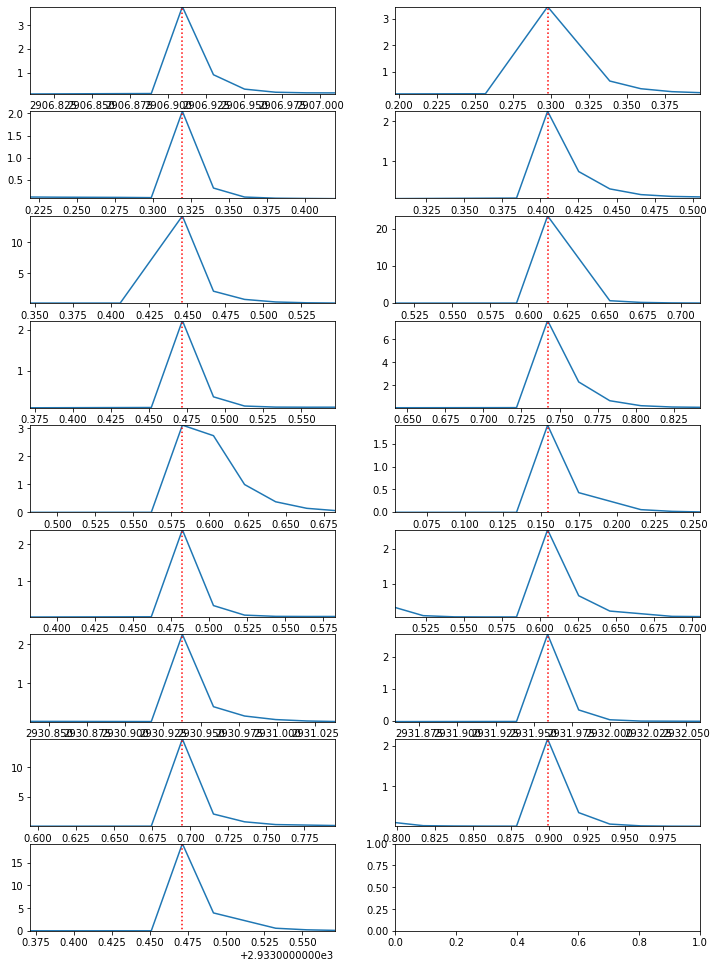

In [41]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(len(tpeaks_pre)/2).astype(int), figsize=[12,len(tpeaks_pre)])
axes = axes.flatten()
flux_pre_std = flux_pre/np.std(flux_pre)
buffer = 0.1
for i in range(len(tpeaks_pre)):
    ### take snapshot of time and flux around identified flare
    snapshot_time = pre.TIME[(pre.TIME > tpeaks_pre[i]-buffer) & (pre.TIME < tpeaks_pre[i]+buffer)] 
    snapshot = flux_pre[(pre.TIME > tpeaks_pre[i]-buffer) & (pre.TIME < tpeaks_pre[i]+buffer)] 
    snapshot_std = flux_pre_std[(pre.TIME > tpeaks_pre[i]-buffer) & (pre.TIME < tpeaks_pre[i]+buffer)]
    
    ax = axes[i]
    ax.plot(pre.TIME, flux_pre_std)
    ax.axvline(tpeaks_pre[i], -1, 1, color='r', linestyle=':')
    ax.set_xlim(tpeaks_pre[i]-buffer, tpeaks_pre[i]+buffer)
    ax.set_ylim(np.min(snapshot_std), np.max(snapshot_std))
    
plt.show()

Great! Using find_peaks() doesn't remove flares. Just fixes their tpeaks. 

Actually, if I lower the N1 and N2 thresholds for xoflares' find_flares(), I can recover more TPs and then use find_peaks() to prune FPs.

So it's settled: we're going with a more generous N1, N2 = 1.1, N3 = 2, and then impose a harsher threshold of height = 1.4 (plus associated width, etc parameters for find_peaks()).

#### Actual flare identification using xoflares + find_peaks()

In [42]:
N1 = 1.3
N2 = 1.3
N3 = 2
x_pre, y_pre, tpeaks_pre, tpeaks_norm_pre, ampls_pre, unnorm_ampls_pre, fwhms_pre, npeaks_pre = find_flares(pre, norm_flux_pre, 
                                                                                          savgol_pre, N1, N2)
x_post, y_post, tpeaks_post, tpeaks_norm_post, ampls_post, unnorm_ampls_post, fwhms_post, npeaks_post = find_flares(post, norm_flux_post, 
                                                                                          savgol_post, N1, N2)
x_postgap, y_postgap, tpeaks_postgap, tpeaks_norm_postgap, ampls_postgap, unnorm_ampls_postgap, fwhms_postgap, npeaks_postgap = find_flares(postgap,
                                                                        norm_flux_postgap, pred_postgap, N1, N2)
print(npeaks_pre, npeaks_post, npeaks_postgap)


48 16 23


In [43]:
print(len(x_pre), len(y_pre), len(tpeaks_pre), len(tpeaks_norm_pre), len(ampls_pre), len(fwhms_pre))
out_pre = pd.DataFrame({'tpeak': tpeaks_pre, 'tpeaks_norm': tpeaks_norm_pre, 'ampls': ampls_pre, 'unnorm_ampls': unnorm_ampls_pre, 'fwhms': fwhms_pre})
out_post = pd.DataFrame({'tpeak': tpeaks_post, 'tpeaks_norm': tpeaks_norm_post, 'ampls': ampls_post, 'unnorm_ampls': unnorm_ampls_post, 'fwhms': fwhms_post})
out_postgap = pd.DataFrame({'tpeak': tpeaks_postgap, 'tpeaks_norm': tpeaks_norm_postgap, 'ampls': ampls_postgap, 'unnorm_ampls': unnorm_ampls_postgap,
                            'fwhms': fwhms_postgap})
out = pd.concat([out_pre, out_post, out_postgap]).reset_index()
print(out)
print(out.loc[out.ampls>0])
#out.to_csv('identified_flares.csv', index=False)



1511 1511 48 48 48 48
    index        tpeak  tpeaks_norm     ampls  unnorm_ampls     fwhms
0       0  2905.826740   -16.018609  1.458995      0.002152  0.002778
1       1  2907.134405   -14.710944  6.983271      0.010299  0.009722
2       2  2907.297863   -14.547486  1.309872      0.001932  0.002778
3       3  2907.440889   -14.404460  1.451282      0.002140  0.002778
4       4  2907.522618   -14.322731  1.368187      0.002018  0.002778
..    ...          ...          ...       ...           ...       ...
82     18  2977.991542     6.670886  1.682145      0.002124  0.002778
83     19  2978.216291     6.895634  1.356167      0.001713  0.002778
84     20  2979.176580     7.855923  1.439159      0.001818  0.002778
85     21  2979.626077     8.305420  1.309828      0.001654  0.002778
86     22  2981.669248    10.348591  4.987364      0.006299  0.004167

[87 rows x 6 columns]
    index        tpeak  tpeaks_norm     ampls  unnorm_ampls     fwhms
0       0  2905.826740   -16.018609  1.458995

#### Use find_peaks() to prune xoflares flare identification outputs across all three data chunks.

pre

In [44]:
out

index        tpeak  tpeaks_norm     ampls  unnorm_ampls     fwhms
0       0  2905.826740   -16.018609  1.458995      0.002152  0.002778
1       1  2907.134405   -14.710944  6.983271      0.010299  0.009722
2       2  2907.297863   -14.547486  1.309872      0.001932  0.002778
3       3  2907.440889   -14.404460  1.451282      0.002140  0.002778
4       4  2907.522618   -14.322731  1.368187      0.002018  0.002778
..    ...          ...          ...       ...           ...       ...
82     18  2977.991542     6.670886  1.682145      0.002124  0.002778
83     19  2978.216291     6.895634  1.356167      0.001713  0.002778
84     20  2979.176580     7.855923  1.439159      0.001818  0.002778
85     21  2979.626077     8.305420  1.309828      0.001654  0.002778
86     22  2981.669248    10.348591  4.987364      0.006299  0.004167

[87 rows x 6 columns]

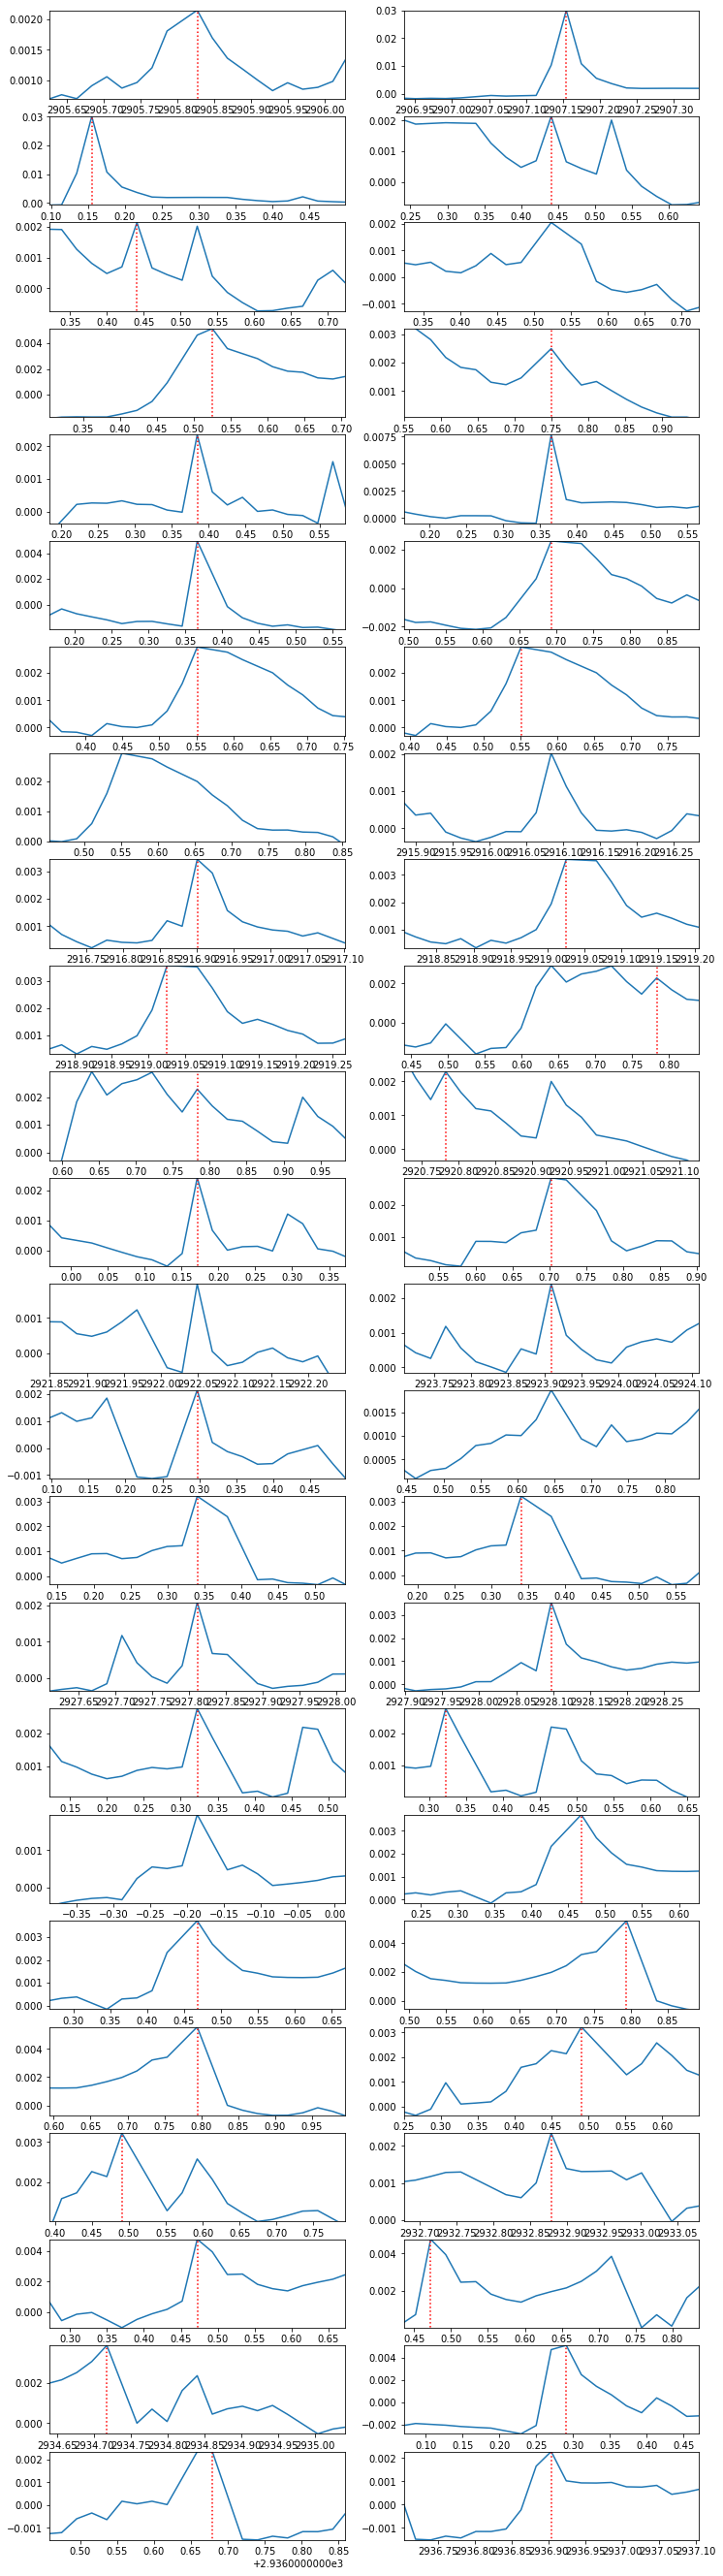

before:  48
after:  42


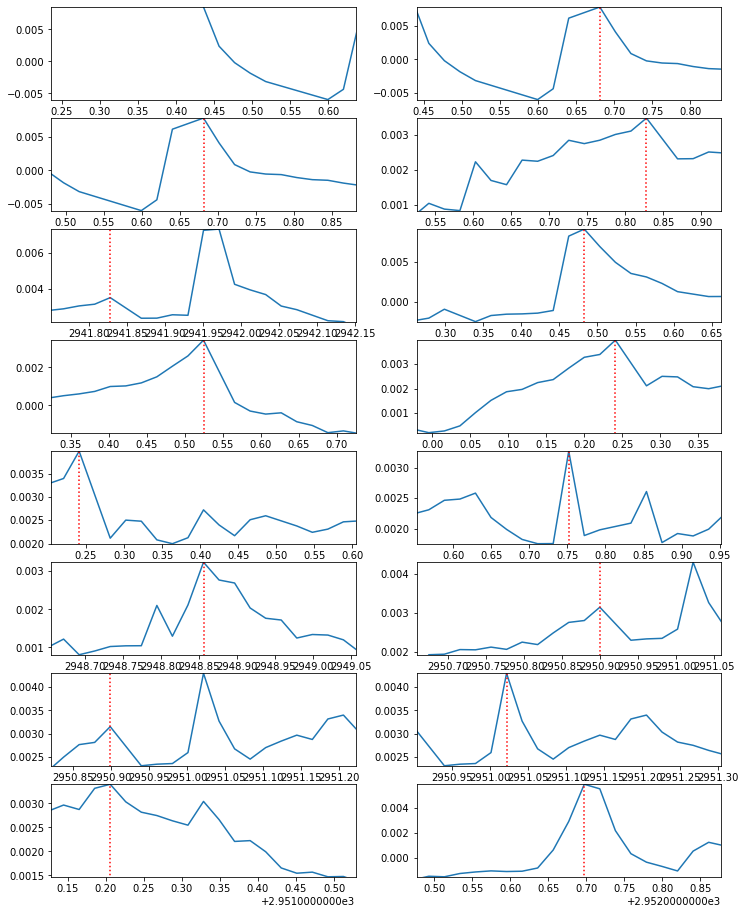

before:  16
after:  15


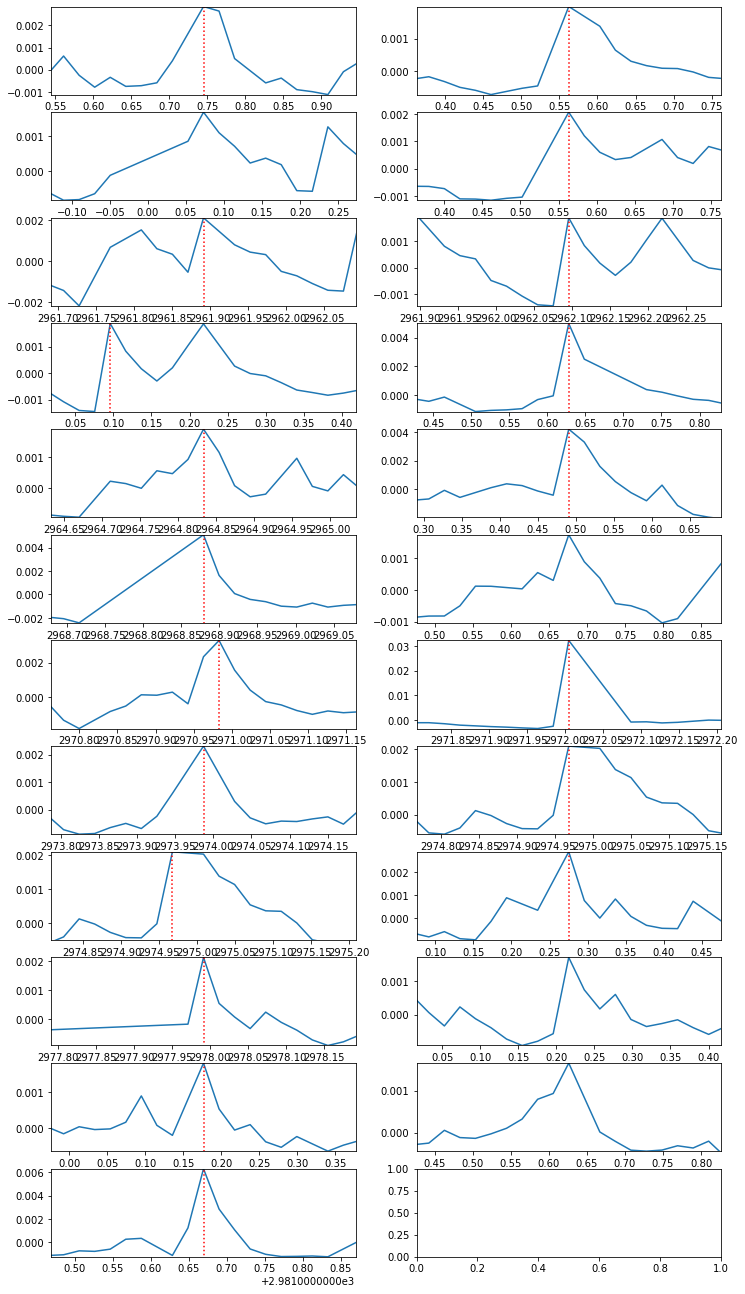

before:  23
after:  19
    index        tpeak  tpeaks_norm     ampls  unnorm_ampls     fwhms  \
0       0  2905.826740   -16.018609  1.458995      0.002152  0.002778   
1       1  2907.134405   -14.710944  6.983271      0.010299  0.009722   
2       2  2907.297863   -14.547486  1.309872      0.001932  0.002778   
3       3  2907.440889   -14.404460  1.451282      0.002140  0.002778   
4       4  2907.522618   -14.322731  1.368187      0.002018  0.002778   
..    ...          ...          ...       ...           ...       ...   
71     16  2975.008522     3.687865  1.603894      0.002026  0.002778   
72     17  2976.275283     4.954627  2.286708      0.002888  0.002778   
73     18  2977.991542     6.670886  1.682145      0.002124  0.002778   
74     20  2979.176580     7.855923  1.439159      0.001818  0.002778   
75     22  2981.669248    10.348591  4.987364      0.006299  0.004167   

    fixed_tpeaks  fixed_fwhms   left_bases  right_bases  
0    2905.826740  5663.731683  2905.663282

In [45]:
def pruning(df, norm_flux, pred, out):
    """
    ### Parameters
    df: original data chunk dataframe, eg. pre
    norm_flux: flux/median - 1, eg. norm_flux_pre
    pred: GP or savgol-smoothed flux, eg. pred_pre
    out: output of xoflares flare identification code find_flares(), eg. out_pre
    
    ### Returns
    
    """
    
    tpeaks = out.tpeak
    npeaks = len(tpeaks)
    tpeaks_norm = out.tpeaks_norm
    ampls = out.ampls
    unnorm_ampls = out.unnorm_ampls
    fwhms = out.fwhms
    
    detrended_std = (norm_flux - pred)/np.std(norm_flux - pred)
    detrended = norm_flux - pred

    height = 1.4
    distance = 5
    wlen = 5
    width_left = None
    width_right = 5
    buffer = 0.2 # essentially the wlen for find_peaks()

    fixed_tpeaks = []
    fixed_fwhms = []
    left_bases_all = []
    right_bases_all = []

    fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
    axes = axes.flatten()
    for i in range(npeaks):
        ### take snapshot of time and flux around identified flare
        snapshot_time = df.TIME[(df.TIME > tpeaks[i]-buffer) & (df.TIME < tpeaks[i]+buffer)] 
        snapshot = detrended[(df.TIME > tpeaks[i]-buffer) & (df.TIME < tpeaks[i]+buffer)] 
        snapshot_std = detrended_std[(df.TIME > tpeaks[i]-buffer) & (df.TIME < tpeaks[i]+buffer)] 

        ### run scipy.signal.find_peaks() to identify actual peak
        peaks, _ = find_peaks(snapshot_std, height=height, distance=distance, width=(width_left,width_right))
        prominences, left_bases, right_bases = peak_prominences(snapshot_std, peaks)
        widths = peak_widths(snapshot_std, peaks, prominence_data=(prominences, left_bases, right_bases))[0]
        #print(np.array(snapshot_time)[peaks], tpeaks_pre[i])
        
        ### plot
        ax = axes[i]
        ax.plot(df.TIME, detrended) # norm_flux_pre
        if len(peaks)>0:
            ax.axvline(np.array(snapshot_time)[peaks][0], -1, 1, color='r', linestyle=':')
            fixed_tpeaks.append(np.array(snapshot_time)[peaks][0])
            fixed_fwhm = widths*30*60
            fixed_fwhms.append(fixed_fwhm[0])
            left_bases_all.append(np.array(snapshot_time)[left_bases][0])
            right_bases_all.append(np.array(snapshot_time)[right_bases][0])
        else:
            fixed_tpeaks.append(np.nan) # for dropping later
            fixed_fwhms.append(np.nan)
            left_bases_all.append(np.nan)
            right_bases_all.append(np.nan)

        ax.set_xlim(tpeaks[i]-buffer, tpeaks[i]+buffer)
        ax.set_ylim(min(snapshot), max(snapshot))

    plt.show()

    # attach fixed tpeaks and fwhm columns to xoflares flare identification dataframe, then drop nans
    out['fixed_tpeaks'] = fixed_tpeaks
    out['fixed_fwhms'] = fixed_fwhms
    out['left_bases'] = left_bases_all
    out['right_bases'] = right_bases_all
    print("before: ", len(out))
    out = out.dropna()
    print("after: ", len(out))
    
    return out

out_pre_fixed = pruning(pre, norm_flux_pre, pred_pre, out_pre)
out_post_fixed = pruning(post, norm_flux_post, pred_post, out_post)
out_postgap_fixed = pruning(postgap, norm_flux_postgap, pred_postgap, out_postgap)
out_fixed = pd.concat([out_pre_fixed, out_post_fixed, out_postgap_fixed]).reset_index()
print(out_fixed)
#out_fixed.to_csv('identified_flares.csv', index=False)

### 8. Subtract flares from original light curve

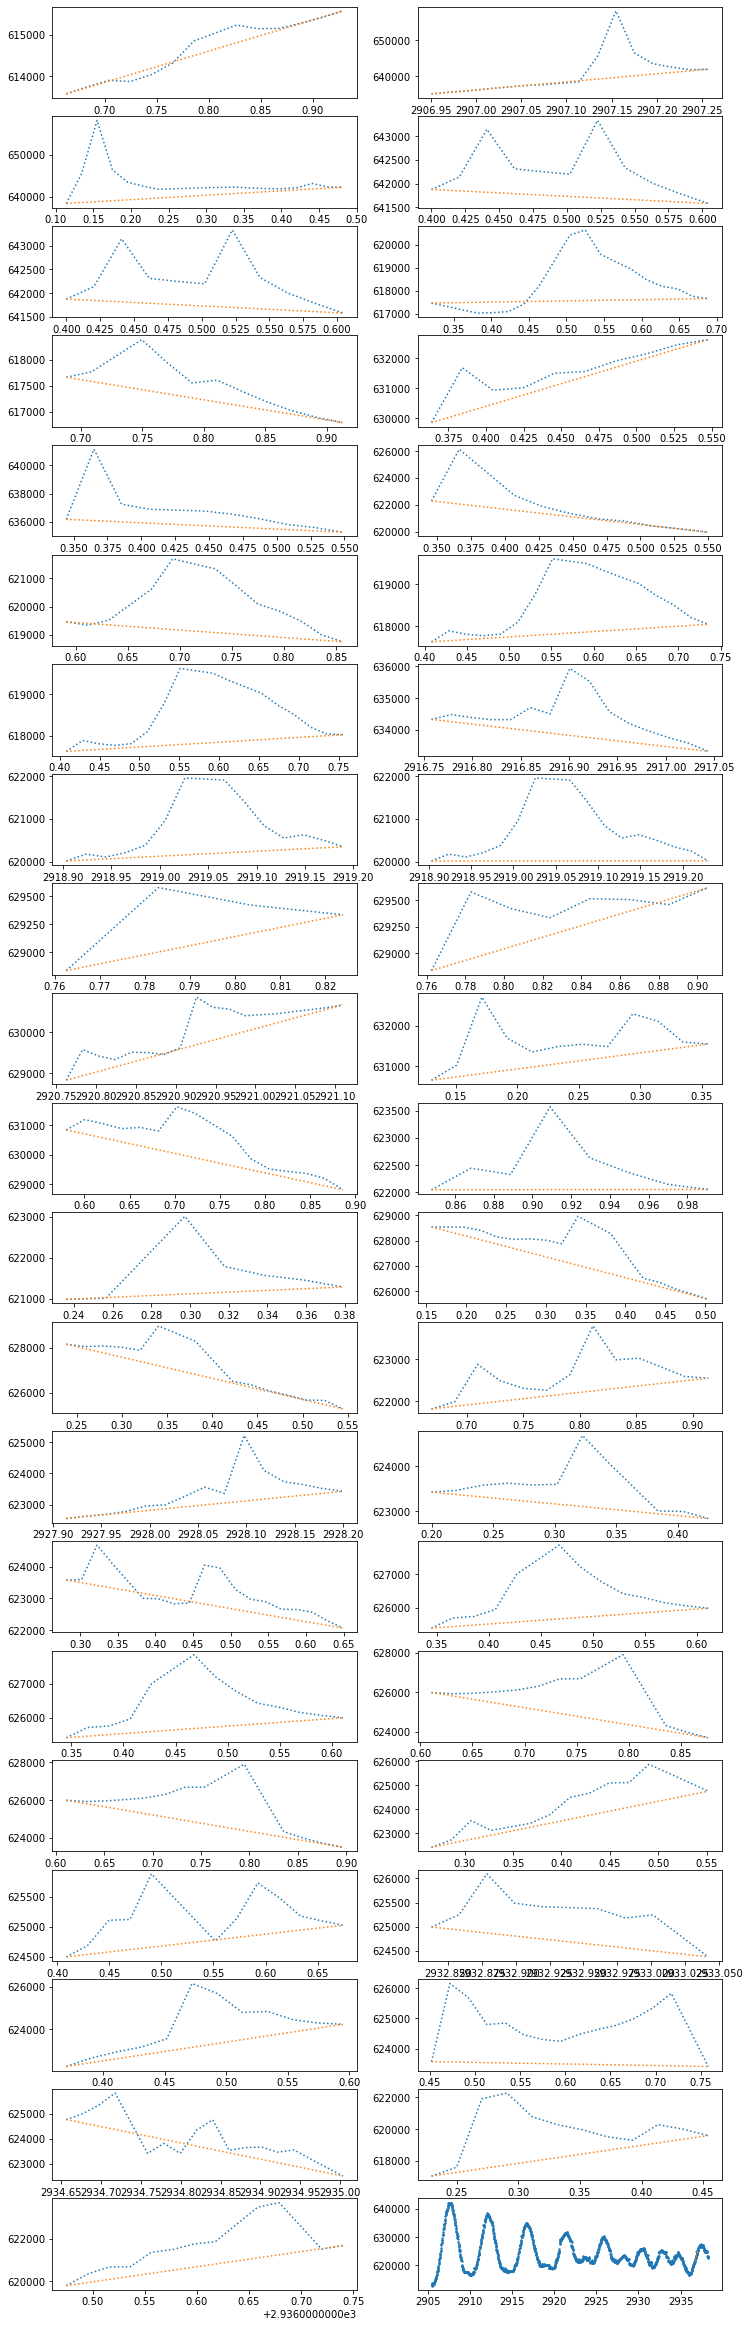

In [46]:
pre2 = copy.deepcopy(pre)

fig, axes = plt.subplots(ncols=2, nrows=np.ceil(len(out_pre_fixed)/2).astype(int), figsize=[12,len(out_pre_fixed)])
axes = axes.flatten()

pre2['flux_flare_subtracted'] = pre2.PDCSAP_FLUX

for i, j in enumerate(out_pre_fixed.tpeak):
    left = out_pre_fixed.iloc[i].left_bases
    right = out_pre_fixed.iloc[i].right_bases
    left_y = list(pre.loc[pre.TIME == left].PDCSAP_FLUX)[0]
    right_y = list(pre.loc[pre.TIME == right].PDCSAP_FLUX)[0]    

    slope = (right_y - left_y)/(right-left)
    temp = pre.loc[(pre.TIME >= left) & (pre.TIME <= right)]
    temp2 = pre2.loc[(pre2.TIME >= left) & (pre2.TIME <= right)]

    ax = axes[i]
    # plot pre-subtracted for comparison
    ax.plot(temp.TIME, temp.PDCSAP_FLUX, linestyle=':')

    # reassign values to reflect removed flares
    ls = np.zeros(len(temp2.flux_flare_subtracted))
    for k, l in enumerate(temp2.flux_flare_subtracted):
        temp_time = temp2.iloc[k].TIME
        l = left_y + (temp_time-left)*slope
        ls[k] = l
    temp2.flux_flare_subtracted = ls

    # globally reassign subtracted flux values
    #print(pre2.loc[(pre2.TIME >= left) & (pre2.TIME <= right)].flux_flare_subtracted)
    #print(temp2.flux_flare_subtracted)
    pre2.flux_flare_subtracted.update(temp2.flux_flare_subtracted)
    #pre2.loc[(pre2.TIME >= left) & (pre2.TIME <= right)].flux_flare_subtracted = temp2.flux_flare_subtracted
    #print(pre2.loc[(pre2.TIME >= left) & (pre2.TIME <= right)].flux_flare_subtracted)
    
    # plot post-subtracted to confirm
    ax.plot(temp2.TIME, temp2.flux_flare_subtracted, linestyle=':')
    buffer = 0.2
    #ax.set_xlim([left-buffer, right+buffer])

plt.scatter(pre2.TIME, pre2.flux_flare_subtracted, s=2)
plt.show()

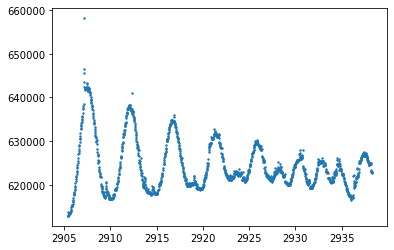

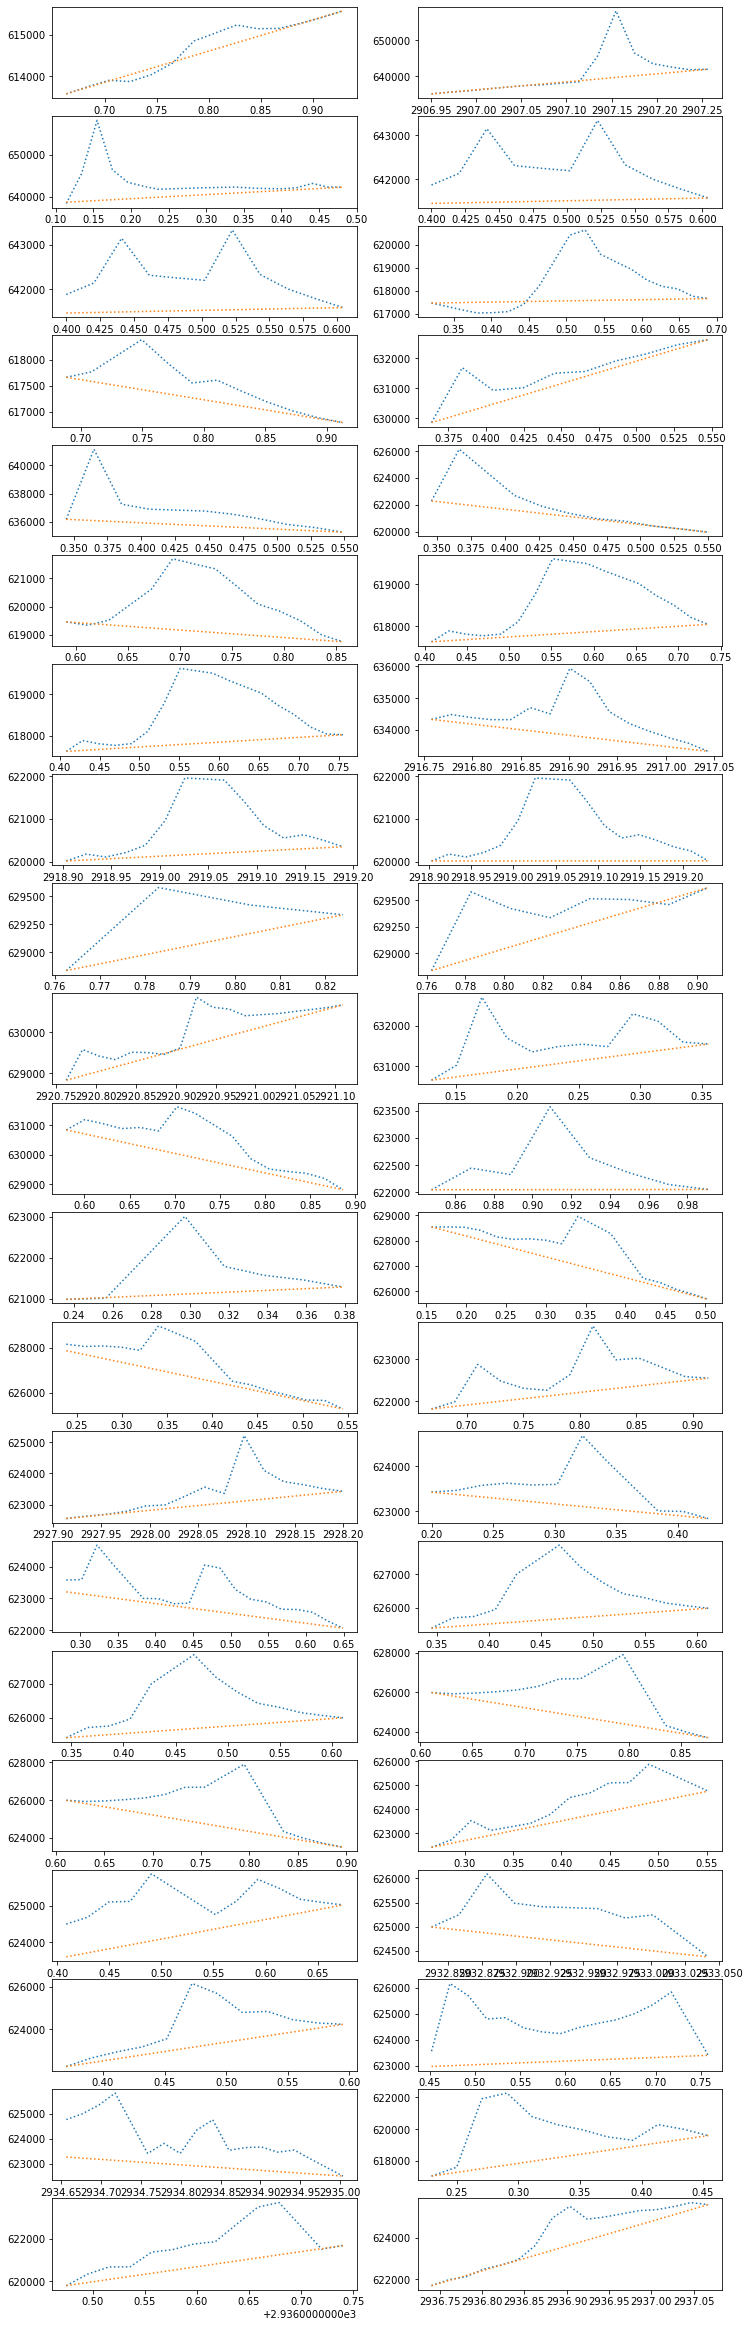

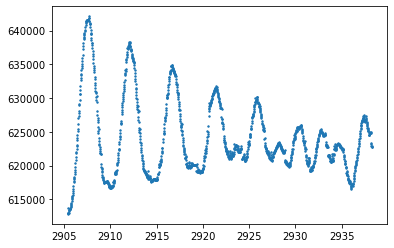

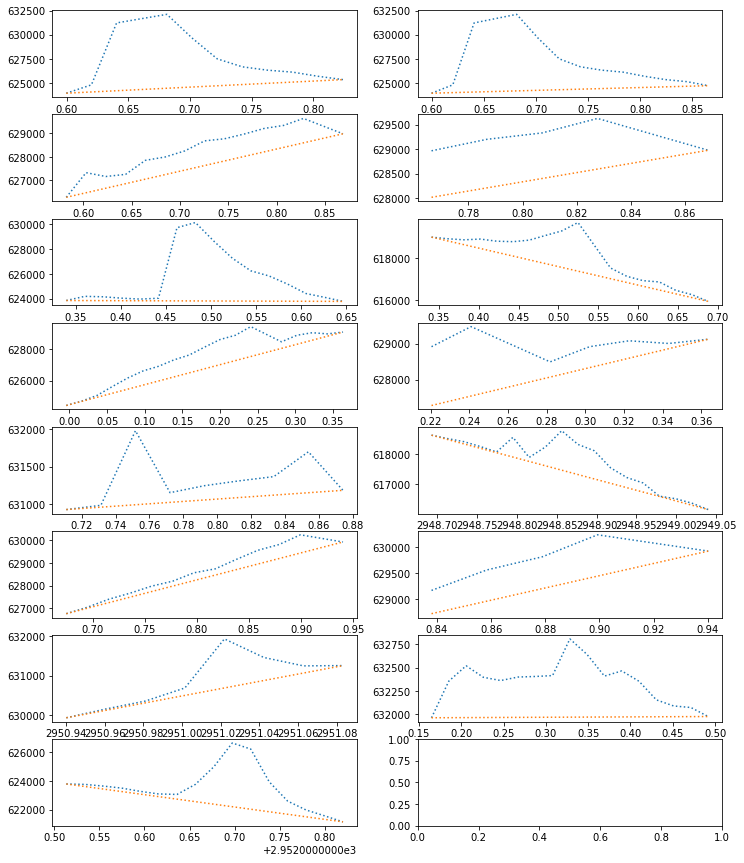

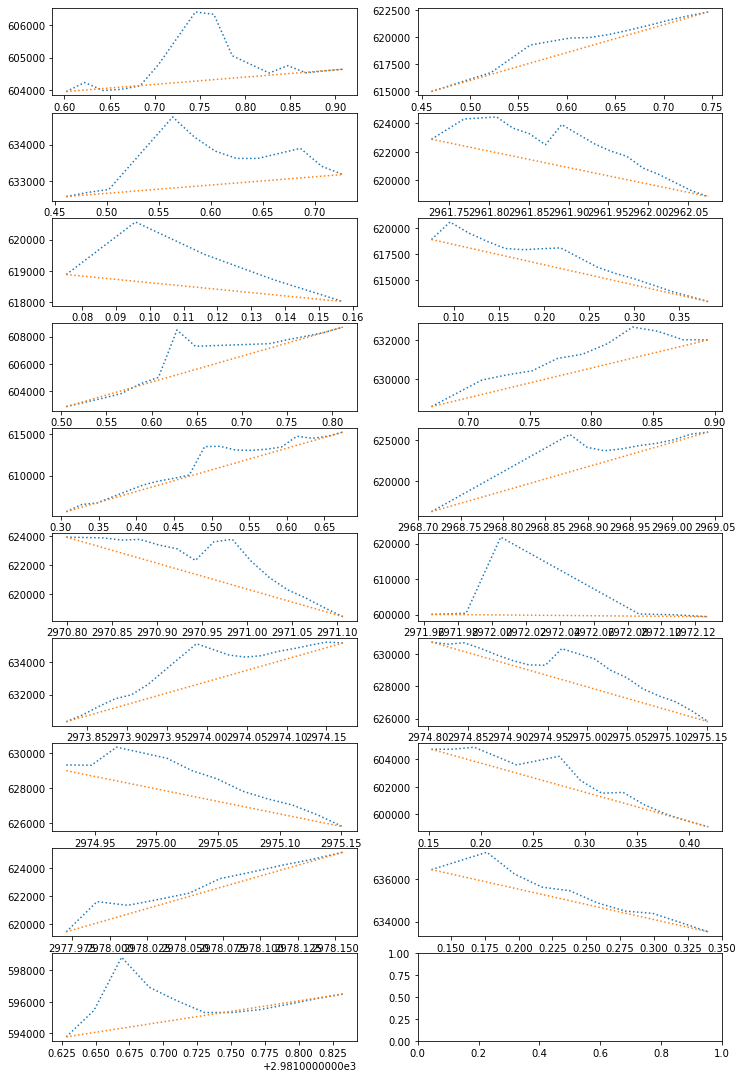

In [47]:
import copy
import warnings
warnings.filterwarnings("ignore")

def subtract_flares(df_sub, out_df_fixed):
    
    df_sub2 = copy.deepcopy(df_sub)
    df_sub2['flux_flare_subtracted'] = df_sub2.PDCSAP_FLUX

    fig, axes = plt.subplots(ncols=2, nrows=np.ceil(len(out_df_fixed)/2).astype(int), figsize=[12,len(out_df_fixed)])
    axes = axes.flatten()

    for i, j in enumerate(out_df_fixed.tpeak):
        left = out_df_fixed.iloc[i].left_bases
        right = out_df_fixed.iloc[i].right_bases
        left_y = list(df_sub2.loc[df_sub2.TIME == left].flux_flare_subtracted)[0]
        right_y = list(df_sub2.loc[df_sub2.TIME == right].flux_flare_subtracted)[0]    

        slope = (right_y - left_y)/(right-left)
        temp = df_sub.loc[(df_sub.TIME >= left) & (df_sub.TIME <= right)]
        temp2 = df_sub2.loc[(df_sub2.TIME >= left) & (df_sub2.TIME <= right)]

        ax = axes[i]
        # plot pre-subtracted for comparison
        ax.plot(temp.TIME, temp.PDCSAP_FLUX, linestyle=':')

        # reassign values to reflect removed flares
        ls = np.zeros(len(temp2.flux_flare_subtracted))
        for k, l in enumerate(temp2.flux_flare_subtracted):
            temp_time = temp2.iloc[k].TIME
            l = left_y + (temp_time-left)*slope
            ls[k] = l
        temp2.flux_flare_subtracted = ls
        
        # globally reassign subtracted flux values
        #df_sub2.loc[(df_sub2.TIME >= left) & (df_sub2.TIME <= right)].flux_flare_subtracted = temp2.flux_flare_subtracted
        df_sub2.flux_flare_subtracted.update(temp2.flux_flare_subtracted)
            
        # plot post-subtracted to confirm
        ax.plot(temp2.TIME, temp2.flux_flare_subtracted, linestyle=':')

    #plt.scatter(pre2.TIME, pre2.PDCSAP_FLUX, s=2)
    plt.show()
    
    return df_sub2
    
plt.scatter(pre.TIME, pre.PDCSAP_FLUX, s=2)
pre_fixed = subtract_flares(pre, out_pre_fixed)
plt.scatter(pre_fixed.TIME, pre_fixed.flux_flare_subtracted, s=2)
plt.show()

post_fixed = subtract_flares(post, out_post_fixed)
postgap_fixed = subtract_flares(postgap, out_postgap_fixed)


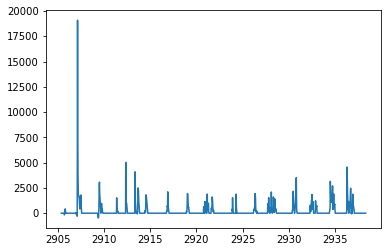

In [48]:
plt.plot(pre.TIME, pre.PDCSAP_FLUX - pre_fixed.flux_flare_subtracted)
plt.show()

### 9. Re-model flare-subtracted light curve with GPs

In [49]:
def alias(df, normalized_flag, method, segment):
    """
    Params:
    - df: Pandas DataFrame representing light curve from MAST
    - normalized_flag: to normalize or not to normalize (Boolean)
    - method: 'gp' or 'savgol'
    - segment: 'pre', 'post', or 'postgap' (really only needed for savgol)
    
    Returns:
    - George-GP-smoothed predicted light curve (list of floats)
    """
    lhs = min(df.TIME)
    rhs = max(df.TIME)
    xobs = np.array(df["TIME"])
    yobs = np.array(df["flux_flare_subtracted"])
    eobs = np.array(df["PDCSAP_FLUX_ERR"])
    
    kernel = np.var(yobs) * ExpSquaredKernel(0.8) # 0.8
    kernel += ExpSine2Kernel(gamma=0.1, log_period=np.log(4.5))
    kernel += 4.0 * Matern32Kernel(metric=4.0)
    
    gp = george.GP(kernel)
    gp.compute(xobs, eobs)

    if normalized_flag==False:
        if method=='gp':
            pred, pred_var = gp.predict(yobs, xobs, return_var=True)
            return pred, pred_var
        elif method=='savgol':
            if segment=='pre':
                pred = savgol_filter(yobs, 109, polyorder=3)
            elif segment=='post':
                pred = savgol_filter(yobs, 129, polyorder=3)
            elif segment=='postgap':
                pred = savgol_filter(yobs, 129, polyorder=3)
            return pred
    
    elif normalized_flag==True:
        yobs_norm = yobs/np.median(yobs) - 1
        pred, pred_var = gp.predict(yobs_norm, xobs, return_var=True)
        if method=='gp':
            pred, pred_var = gp.predict(yobs_norm, xobs, return_var=True)
            return pred, pred_var
        elif method=='savgol':
            if segment=='pre':
                pred = savgol_filter(yobs_norm, 109, polyorder=3)
            elif segment=='post':
                pred = savgol_filter(yobs_norm, 149, polyorder=3)
            elif segment=='postgap':
                pred = savgol_filter(yobs_norm, 129, polyorder=3)
            return pred

pred_pre_fixed, pred_var_pre_fixed = alias(pre_fixed, normalized_flag=True, method='gp', segment='pre')
pred_post_fixed, pred_var_post_fixed = alias(post_fixed, normalized_flag=True, method='gp', segment='post')
#pred_pre_fixed = alias(pre_fixed, normalized_flag=True, method='savgol', segment='pre')
#pred_post_fixed = alias(post_fixed, normalized_flag=True, method='savgol', segment='post')
pred_postgap_fixed, pred_var_postgap_fixed = alias(postgap_fixed, normalized_flag=True, method='gp', segment='postgap')


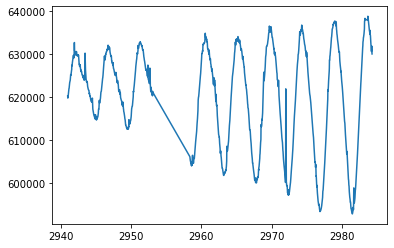

In [50]:
plt.plot(df.iloc[1628:].TIME, df.iloc[1628:].PDCSAP_FLUX)


In [51]:
post.TIME[10:]

1632    2938.722099
1633    2938.742531
1634    2938.762962
1635    2938.783394
1636    2938.803826
           ...     
2332    2953.024187
2333    2953.044618
2334    2953.065050
2335    2953.085481
2336    2953.105913
Name: TIME, Length: 661, dtype: float64

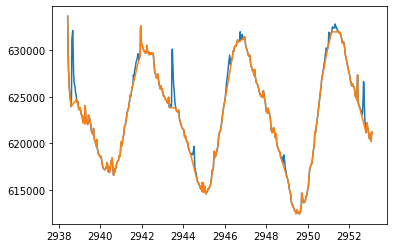

In [52]:
thresh = 0
plt.plot(post.TIME[thresh:], post.PDCSAP_FLUX[thresh:])
plt.plot(post.TIME[thresh:], post_fixed.flux_flare_subtracted[thresh:])
plt.show()

### K2SC

Introduce and actually correct the flux using the output of running K2SC

In [53]:
# compare everything
filename_k2sc = '/Users/chrislam/Desktop/epic-246301900/EPIC_246301900_mast.fits'
hdul_k2sc = fits.open(filename)
#hdul_k2sc.info()
data_k2sc = fits.getdata(filename_k2sc,header=True,ext=1)
df_k2sc = pd.DataFrame(np.array(data_k2sc[0]).byteswap().newbyteorder())

In [54]:
hdul_k2sc[0].header

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2020-02-28'         / file creation date.                            
CREATOR = '1003547 FluxExporter2PipelineModule' / pipeline job and program used 
PROCVER = 'svn+ssh://murzim/repo/soc/tags/release/9.3.109 r63647' / SW version  
FILEVER = '6.1     '           / file format version                            
TIMVERSN= 'OGIP/93-003'     

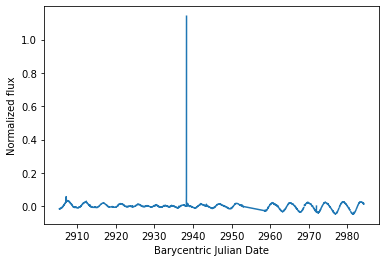

In [55]:
# reference: https://github.com/OxES/k2sc/blob/master/bin/k2mastify
# following https://github.com/OxES/k2sc/issues/9

detrended_k2sc = df_k2sc.flux - df_k2sc.trposi + np.nanmedian(df_k2sc.trposi) - df_k2sc.trtime + np.nanmedian(df_k2sc.trtime)
corrected_k2sc = df_k2sc.flux - df_k2sc.trposi + np.nanmedian(df_k2sc.trposi)
df_k2sc['detrended'] = detrended_k2sc
df_k2sc['corrected'] = corrected_k2sc
df_k2sc['detrended_norm'] = detrended_k2sc/np.nanmedian(detrended_k2sc) - 1
df_k2sc['corrected_norm'] = corrected_k2sc/np.nanmedian(corrected_k2sc) - 1


#detrended_k2sc = df_k2sc.flux - df_k2sc.trposi - df_k2sc.trtime 
#corrected_k2sc = df_k2sc.flux - df_k2sc.trposi
pre_detrended = detrended_k2sc.loc[:1585]
post_detrended = detrended_k2sc.loc[1588:2294]
postgap_detrended = detrended_k2sc.loc[2295:]
pre_corrected = corrected_k2sc.loc[:1585]
post_corrected = corrected_k2sc.loc[1588:2294]
postgap_corrected = corrected_k2sc.loc[2295:]



#plt.scatter(df_k2sc.time, corrected_k2sc, s=2)
#plt.scatter(df_k2sc.time, detrended_k2sc, s=2)
plt.plot(df_k2sc.time, df_k2sc['corrected_norm'], label='K2SC-corrected flux')
#plt.scatter(df.TIME, df.PDCSAP_FLUX/np.nanmedian(df.PDCSAP_FLUX) - 1, label='PDCSAP_FLUX', s=2, color='purple')
plt.ylabel('Normalized flux')
plt.xlabel('Barycentric Julian Date')
#plt.legend()
plt.savefig('fig1.pdf', format='pdf')
plt.show()


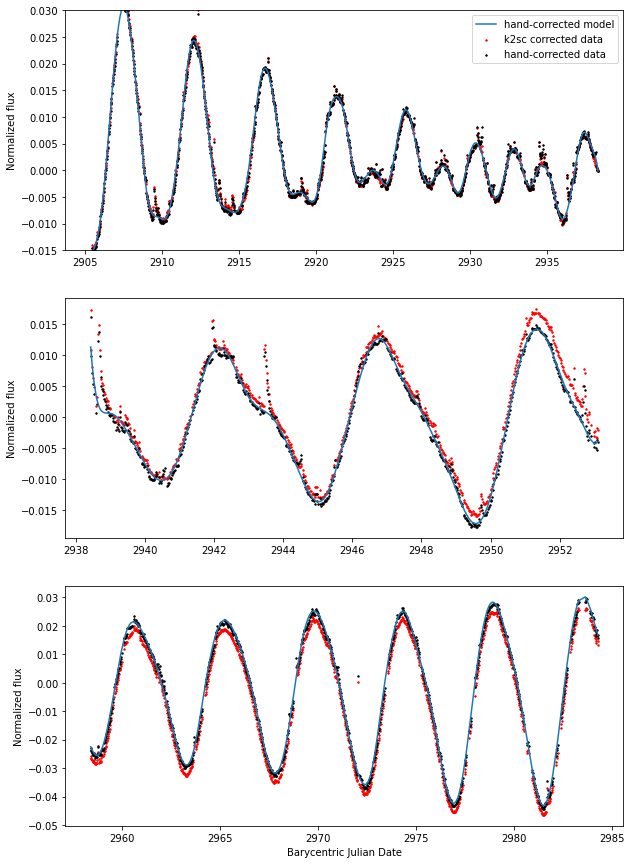

In [56]:
# compare everything

pre_k2sc = df_k2sc.loc[:1585] # next record is the beginning of the flare, so stop here
post_k2sc = df_k2sc.loc[1588:2294] # start from after the flare until beginning of the gap in time series data
postgap_k2sc = df_k2sc.loc[2295:] # start from end of the gap in data until end of time series data
#pre_k2sc = df_k2sc.iloc[pre.index]
norm_flux_pre_k2sc_corrected = pre_corrected/np.nanmedian(pre_corrected) - 1
#post_k2sc = df_k2sc.iloc[post.index]
norm_flux_post_k2sc_corrected = post_corrected/np.nanmedian(post_corrected) - 1
#postgap_k2sc = df_k2sc.iloc[postgap.index]
norm_flux_postgap_k2sc_corrected = postgap_corrected/np.nanmedian(postgap_corrected) - 1
norm_flux_pre_k2sc_detrended = pre_corrected/np.nanmedian(pre_detrended) - 1
norm_flux_post_k2sc_detrended = post_corrected/np.nanmedian(post_detrended) - 1
norm_flux_postgap_k2sc_detrended = postgap_corrected/np.nanmedian(postgap_detrended) - 1

plt.figure(figsize=(10,15))
plt.subplot(311)
#plt.plot(pre.TIME, pred_pre, label='no flare subtraction')
#plt.plot(pre_k2sc.time, , label='k2sc corrected model')
plt.plot(pre_fixed.TIME, pred_pre_fixed, label='hand-corrected model')
plt.scatter(pre_k2sc.time, pre_k2sc.corrected_norm, s=2, c='r', label='k2sc corrected data')
plt.scatter(pre.TIME, norm_flux_pre, s=2, c='k', label='hand-corrected data')
plt.ylim([-0.015, 0.03])
plt.ylabel('Normalized flux')
plt.legend()

plt.subplot(312)
#plt.plot(post.TIME, pred_post, label='no flare subtraction')
plt.plot(post_fixed.TIME, pred_post_fixed, label='hand-corrected model')
plt.scatter(post_k2sc.time, post_k2sc.corrected_norm, s=2, c='r', label='k2sc corrected data')
plt.scatter(post.TIME, norm_flux_post, s=2, c='k', label='hand-corrected data')
plt.ylabel('Normalized flux')
         
plt.subplot(313)
#plt.plot(postgap.TIME, pred_postgap, label='no flare subtraction')
plt.plot(postgap_fixed.TIME, pred_postgap_fixed, label='hand-corrected model')
plt.scatter(postgap_k2sc.time, postgap_k2sc.corrected_norm, s=2, c='r', label='k2sc corrected data')
plt.scatter(postgap.TIME, norm_flux_postgap, s=2, c='k', label='hand-corrected data')
plt.xlabel('Barycentric Julian Date')
plt.ylabel('Normalized flux')
plt.show()

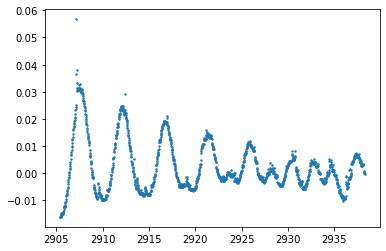

NameError: name 'norm_flux_pre_k2sc' is not defined

In [57]:
plt.scatter(pre.TIME, norm_flux_pre, s=2)
plt.show()

plt.scatter(pre_k2sc.time, norm_flux_pre_k2sc, s=2)
plt.show()


In [58]:
plt.plot(norm_flux_pre_k2sc - norm_flux_pre)
plt.show()

plt.plot(norm_flux_post_k2sc - norm_flux_post)
plt.show()

plt.plot(norm_flux_postgap_k2sc - norm_flux_postgap)
plt.show()

NameError: name 'norm_flux_pre_k2sc' is not defined

Wait, that's not right because, eg. postgap chunks are different lengths. And the times don't match up. So I can only really just plot them on top of each other. 

In [59]:
plt.plot(pre_k2sc.time, norm_flux_pre_k2sc)
plt.plot(pre.TIME, norm_flux_pre)
plt.show()

plt.plot(post_k2sc.time, norm_flux_post_k2sc)
plt.plot(post.TIME, norm_flux_post)
plt.show()

plt.plot(postgap_k2sc.time, norm_flux_postgap_k2sc)
plt.plot(postgap.TIME, norm_flux_postgap)
plt.show()

NameError: name 'norm_flux_pre_k2sc' is not defined

#### Recipe:
- Read in K2SC data and get corrected and detrended flux, as well as normalized corrected and detrended flux. 
- Identify flares (first pass). Here, I've gone against Tom's method by taking matches to flux > N1, rather than the inverse of non-matches. For some reason, they give different results. I've also removed the consecutiveness check, especially since I will later (in pruning_k2sc()) use scipy.peak_prominences() to identify left and right bases for the FWHM.
- Subtract flares to get smoothed detrended flux. Specifically, redraw a line from the left base flux to the right base flux. 
- Inject fake flares
- Conduct recovery tests to choose best flare identification parameters (here, I combined find_flares_k2sc() and pruning_k2sc())
- Re-identify flares using those parameters
- Subtract once again to then do rotation period analysis, a la https://gallery.exoplanet.codes/tutorials/stellar-variability/
- Model flares. Have ampls be the detrended_norm column in the k2sc_fixed DFs, and have fwhms be in days rather than seconds.
- Make FFD

##### b. First-pass flare identification for K2SC detrended light curve

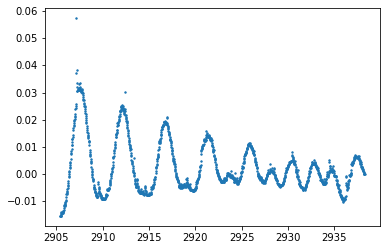

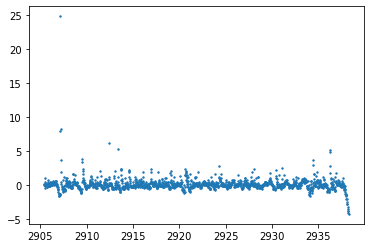

In [60]:
plt.scatter(pre_k2sc.time, pre_k2sc.corrected_norm, s=2)
plt.show()

plt.scatter(pre_k2sc.time, pre_k2sc.detrended_norm/np.std(pre_k2sc.detrended_norm), s=2)
plt.show()

[2907.1344051  2907.15483734 2907.17526948 2907.19570182 2909.5249737
 2912.36504131 2913.36621372 2934.4723184  2936.27030402 2936.29073556]


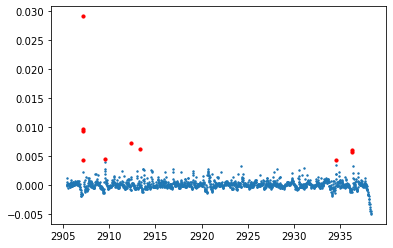

[2938.43605659 2938.4564882  2938.64037271 2938.68123593 2938.70166754
 2941.95029121 2941.97072289 2943.46222768 2943.48265925 2943.50309091
 2943.52352237 2952.69728255 2952.71771406]


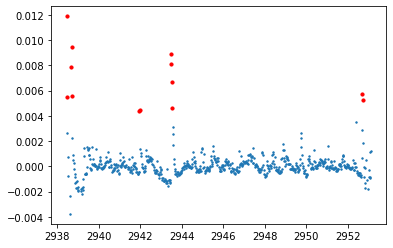

[2963.62813442 2968.87904238 2972.00507432 2981.66924776]


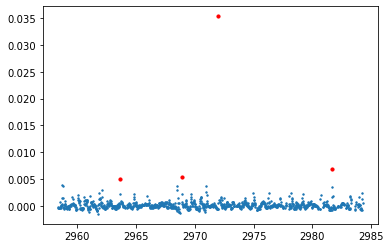

'\nidx_interval = pre.TIME[2] - pre.TIME[1] # time spanned by one index\ntol = 3 # reminiscent of minsep from altaipony        \ntps_pre_k2sc, fps_pre_k2sc, fns_pre_k2sc = analyze_recovery_for_xoflares(tpeaks_pre_k2sc, t0_fake_pre_k2sc, tol=tol*idx_interval)\ntps_post_k2sc, fps_post_k2sc, fns_post_k2sc = analyze_recovery_for_xoflares(tpeaks_post_k2sc, t0_fake_post_k2sc, tol=tol*idx_interval)\ntps_postgap_k2sc, fps_postgap_k2sc, fns_postgap_k2sc = analyze_recovery_for_xoflares(tpeaks_postgap_k2sc, t0_fake_postgap_k2sc, tol=tol*idx_interval)\n\nprint(tps_pre_k2sc, fps_pre_k2sc, fns_pre_k2sc)\nprint(tps_post_k2sc, fps_post_k2sc, fns_post_k2sc)\nprint(tps_postgap_k2sc, fps_postgap_k2sc, fns_postgap_k2sc)\n'

In [61]:
# calculate reference (average) time
def calculate_ref_time(lc):
    return 0.5 * (np.min(lc.time) + np.max(lc.time))

def find_flares_k2sc(lc, flux, N1, N2):
    """
    Adapted from Tom Barclay's xoflares: https://github.com/mrtommyb/xoflares
    Params:
    - lc: DataFrame with PDCSAP_FLUX_ERR, PDCSAP_FLUX, and CADENCENO fields
    - flux:  GP-predicted flux with flares injected
    - N1: int or float (default is 3)
        How many times above sigma is required.
    - N2: int or float (Default is 3)
        How many times above sigma and detrended_flux_err is required
        
    Returns:
    - x: lc.TIME - ref_time
    - y: flux param
    - tpeaks: start time of flares (corresponds to lc.TIME)
    - tpeaks_norm: start time of flares (normalized to correspond to x)
    - ampls: flare amplitudes
    - fwhms: full-width half-maxes of flares
    - npeaks: number of flares identified
    """
    
    # find some flares
    #mflare = flux < N1 * np.sqrt(np.mean(flux**2))
    unnorm_flux = flux # save this for ampls
    flux = flux/np.std(flux) # rewrite flux in standard deviations
    #print(flux)
    #print(lc.error/np.nanmedian(lc.error))
    #print(flux - lc.error/np.nanmedian(lc.error))
    #plt.scatter(lc.time, flux - lc.error/np.nanmedian(lc.error), s=2)
    #plt.show()

    mflare = (flux < N1) & (flux - lc.error/np.nanmedian(lc.error) < N2) # the way Tom wrote it in xoflares
    mflare = flux > N1 
    #print(mflare[mflare==True])
    #asdfadf
    
    # resume flare identification code from xoflares
    cads = lc.cadence - list(lc.cadence)[0] # index CADENCENO at 0
    ref_time = calculate_ref_time(lc)
    x = lc.time - ref_time # subtract time by average time
    y = flux # data with savgol subtracted OR normalized data

    fidx = cads.loc[~mflare][:-1]#[np.diff(cads[~mflare]) < 1] # the way Tom wrote it in xoflares
    fidx = cads.loc[mflare] 
    fidx = list(fidx) # address indexing errors
    #plt.scatter(lc.time, lc.detrended_norm, s=2)
    #plt.scatter(lc.iloc[fidx].time, lc.iloc[fidx].detrended_norm, s=10, color='r')
    #plt.show()

    npts = np.array([])
    i = 0
    n = 1
    """
    while True:
        try:
            if fidx[i + 1] == fidx[i] + n:
                # measure flare: keep track of number of points (fatness) of a flare
                # if I care about consecutive points, this is where I'd deal with it
                fidx = np.delete(fidx, i + 1)
                n += 1
            else:
                # count flare: concatenate to array, advance, and reset count
                npts = np.r_[npts, n+1] 
                i += 1
                n = 1
        except IndexError:
            npts = np.r_[npts, n+1]
            break
    """    
    tpeaks = np.array([lc.time.loc[cads == fidx[i]].values for i in range(len(fidx))]).T[0]
    print(tpeaks)
    plt.scatter(lc.time, lc.detrended_norm, s=2)
    plt.scatter(tpeaks, lc.loc[lc.time.isin(tpeaks)].detrended_norm, s=10, color='r')
    plt.show()

    tpeaks_norm = np.array([x.loc[cads == fidx[i]].values for i in range(len(fidx))]).T[0]
    try: # if flux given is a DataFrame (eg. norm_flux_pre)
        unnorm_ampls = np.array([unnorm_flux.loc[cads == fidx[i]].values for i in range(len(fidx))]).T[0]
        ampls = np.array([flux.loc[cads == fidx[i]].values for i in range(len(fidx))]).T[0]
    except: # if flux given is a np.array (eg. flux_pre)
        unnorm_ampls = np.array([unnorm_flux[cads == fidx[i]] for i in range(len(fidx))]).T[0]
        ampls = np.array([flux[cads == fidx[i]] for i in range(len(fidx))]).T[0]
    fwhms = np.asarray(npts) * (2/1440) 
    npeaks = np.shape(tpeaks)[0]
    #print(tpeaks, ampls, fwhms, npeaks)
    #print(fidx)
    
    """
    ### enter: scipy.signal.find_peaks() for cleanup duty
    height = 1.1
    distance = 10
    wlen = 5
    width_left = None
    width_right = 10
    buffer = 0.1 # essentially the wlen for find_peaks()
    for i in range(npeaks):
        ### take snapshot of time and flux around identified flare
        snapshot_time = lc.time[(lc.time > tpeaks[i]-buffer) & (lc.time < tpeaks[i]+buffer)] 
        snapshot = unnorm_flux[(lc.time > tpeaks[i]-buffer) & (lc.time < tpeaks[i]+buffer)] 
        snapshot_std = flux[(lc.time > tpeaks[i]-buffer) & (lc.time < tpeaks[i]+buffer)] 
        
        ### run scipy.signal.find_peaks() to identify actual peak
        peaks, _ = find_peaks(snapshot_std, height=height, distance=distance, width=(width_left,width_right))
        prominences, left_bases, right_bases = peak_prominences(snapshot_std, peaks)
        #tpeaks = np.array(snapshot_time)[peaks]
        #print(peaks)
    """
    
    return x, y, tpeaks, tpeaks_norm, ampls, unnorm_ampls, fwhms, npeaks

N1 = 3.5
N2 = 3.5
#x, y, tpeaks, tpeaks_norm, ampls, fwhms, npeaks = find_flares(pre, norm_flux_pre, pred_pre, N1, N2)
#_, _, tpeaks_pre, _, _, _, _ = find_flares(pre, flux_pre, pred_pre, N1, N2) 
#_, _, tpeaks_post, _, _, _, _ = find_flares(post, flux_post, pred_post, N1, N2)
x_pre_k2sc, y_pre_k2sc, tpeaks_pre_k2sc, tpeaks_norm_pre_k2sc, ampls_pre_k2sc, unnorm_ampls_pre_k2sc, fwhms_pre_k2sc, npeaks_pre_k2sc = find_flares_k2sc(pre_k2sc, pre_k2sc['detrended_norm'], N1, N2)
x_post_k2sc, y_post_k2sc, tpeaks_post_k2sc, tpeaks_norm_post_k2sc, ampls_post_k2sc, unnorm_ampls_post_k2sc, fwhms_post_k2sc, npeaks_post_k2sc = find_flares_k2sc(post_k2sc, post_k2sc['detrended_norm'], N1, N2)
x_postgap_k2sc, y_postgap_k2sc, tpeaks_postgap_k2sc, tpeaks_norm_postgap_k2sc, ampls_postgap_k2sc, unnorm_ampls_postgap_k2sc, fwhms_postgap_k2sc, npeaks_postgap_k2sc = find_flares_k2sc(postgap_k2sc, postgap_k2sc['detrended_norm'], N1, N2)

"""
idx_interval = pre.TIME[2] - pre.TIME[1] # time spanned by one index
tol = 3 # reminiscent of minsep from altaipony        
tps_pre_k2sc, fps_pre_k2sc, fns_pre_k2sc = analyze_recovery_for_xoflares(tpeaks_pre_k2sc, t0_fake_pre_k2sc, tol=tol*idx_interval)
tps_post_k2sc, fps_post_k2sc, fns_post_k2sc = analyze_recovery_for_xoflares(tpeaks_post_k2sc, t0_fake_post_k2sc, tol=tol*idx_interval)
tps_postgap_k2sc, fps_postgap_k2sc, fns_postgap_k2sc = analyze_recovery_for_xoflares(tpeaks_postgap_k2sc, t0_fake_postgap_k2sc, tol=tol*idx_interval)

print(tps_pre_k2sc, fps_pre_k2sc, fns_pre_k2sc)
print(tps_post_k2sc, fps_post_k2sc, fns_post_k2sc)
print(tps_postgap_k2sc, fps_postgap_k2sc, fns_postgap_k2sc)
"""


In [62]:
out_pre_k2sc = pd.DataFrame({'tpeak': tpeaks_pre_k2sc, 'tpeaks_norm': tpeaks_norm_pre_k2sc, 'ampls': ampls_pre_k2sc, 'unnorm_ampls': unnorm_ampls_pre_k2sc})
out_post_k2sc = pd.DataFrame({'tpeak': tpeaks_post_k2sc, 'tpeaks_norm': tpeaks_norm_post_k2sc, 'ampls': ampls_post_k2sc, 'unnorm_ampls': unnorm_ampls_post_k2sc})
out_postgap_k2sc = pd.DataFrame({'tpeak': tpeaks_postgap_k2sc, 'tpeaks_norm': tpeaks_norm_postgap_k2sc, 'ampls': ampls_postgap_k2sc, 'unnorm_ampls': unnorm_ampls_postgap_k2sc,
                            })
out_k2sc = pd.concat([out_pre_k2sc, out_post_k2sc, out_postgap_k2sc]).reset_index()
print(out_k2sc)
#print(out_k2sc.loc[out_k2sc.ampls>0])
#out_k2sc.to_csv('identified_flares_k2sc.csv', index=False)


    index        tpeak  tpeaks_norm      ampls  unnorm_ampls
0       0  2907.134405   -14.700728   7.950881      0.009329
1       1  2907.154837   -14.680295  24.787808      0.029084
2       2  2907.175269   -14.659863   8.218694      0.009643
3       3  2907.195702   -14.639431   3.675579      0.004313
4       4  2909.524974   -12.310159   3.762918      0.004415
5       5  2912.365041    -9.470091   6.217856      0.007296
6       6  2913.366214    -8.468919   5.260852      0.006173
7       7  2934.472318    12.637186   3.718867      0.004363
8       8  2936.270304    14.435171   4.889051      0.005736
9       9  2936.290736    14.455603   5.051218      0.005927
10      0  2938.436057    -7.294065   9.885522      0.011877
11      1  2938.456488    -7.273633   4.539295      0.005454
12      2  2938.640373    -7.089749   6.566433      0.007890
13      3  2938.681236    -7.048886   7.885306      0.009474
14      4  2938.701668    -7.028454   4.636869      0.005571
15      5  2941.950291  

##### c. Subtract flares

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


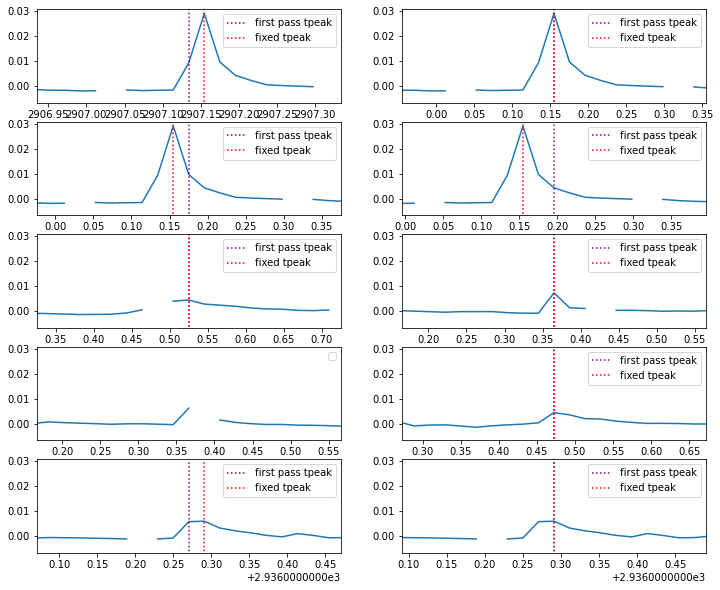

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


         tpeak  tpeaks_norm      ampls  unnorm_ampls  fixed_tpeaks  \
0  2907.134405   -14.700728   7.950881      0.009329   2907.154837   
1  2907.154837   -14.680295  24.787808      0.029084   2907.154837   
2  2907.175269   -14.659863   8.218694      0.009643   2907.154837   
3  2907.195702   -14.639431   3.675579      0.004313   2907.154837   
4  2909.524974   -12.310159   3.762918      0.004415   2909.524974   
5  2912.365041    -9.470091   6.217856      0.007296   2912.365041   
6  2913.366214    -8.468919   5.260852      0.006173           NaN   
7  2934.472318    12.637186   3.718867      0.004363   2934.472318   
8  2936.270304    14.435171   4.889051      0.005736   2936.290736   
9  2936.290736    14.455603   5.051218      0.005927   2936.290736   

   fixed_fwhms   left_bases  right_bases  
0  2692.811752  2907.073108  2907.297863  
1  2692.811752  2907.073108  2907.297863  
2  2692.811752  2907.073108  2907.297863  
3  2692.811752  2907.073108  2907.297863  
4  1146.274105

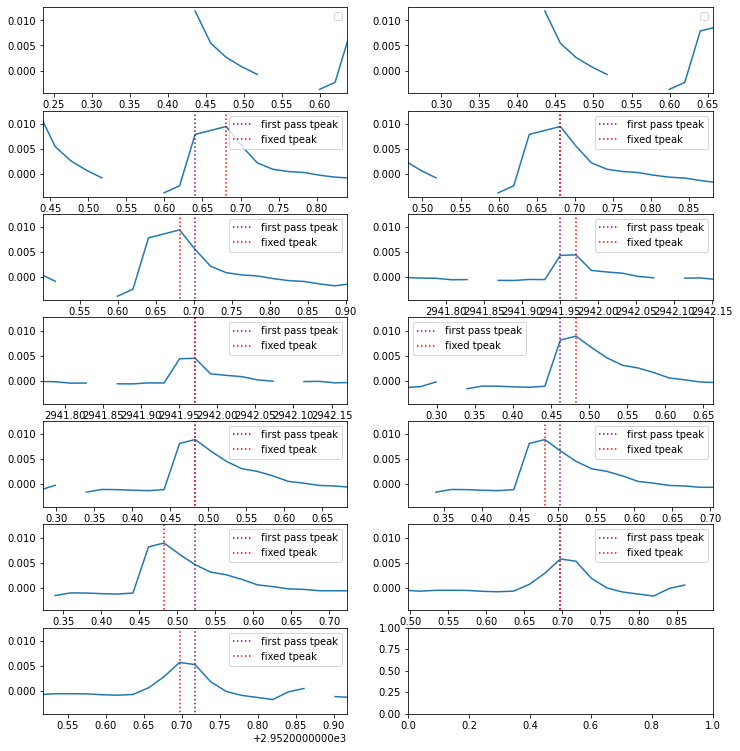

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


          tpeak  tpeaks_norm     ampls  unnorm_ampls  fixed_tpeaks  \
0   2938.436057    -7.294065  9.885522      0.011877           NaN   
1   2938.456488    -7.273633  4.539295      0.005454           NaN   
2   2938.640373    -7.089749  6.566433      0.007890   2938.681236   
3   2938.681236    -7.048886  7.885306      0.009474   2938.681236   
4   2938.701668    -7.028454  4.636869      0.005571   2938.681236   
5   2941.950291    -3.779830  3.660942      0.004399   2941.970723   
6   2941.970723    -3.759399  3.736220      0.004489   2941.970723   
7   2943.462228    -2.267894  6.762153      0.008125   2943.482659   
8   2943.482659    -2.247462  7.417570      0.008912   2943.482659   
9   2943.503091    -2.227031  5.524987      0.006638   2943.482659   
10  2943.523522    -2.206599  3.810399      0.004578   2943.482659   
11  2952.697283     6.967161  4.751424      0.005709   2952.697283   
12  2952.717714     6.987593  4.387337      0.005271   2952.697283   

    fixed_fwhms   l

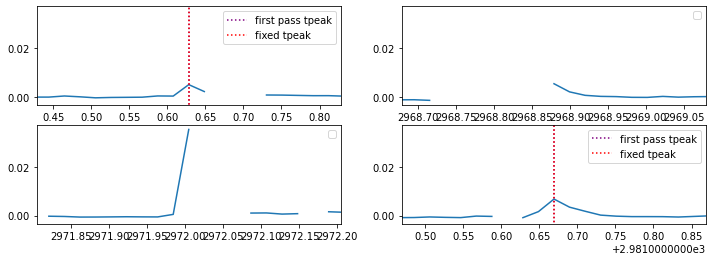

         tpeak  tpeaks_norm      ampls  unnorm_ampls  fixed_tpeaks  \
0  2963.628134    -7.692522   3.946993      0.005057   2963.628134   
1  2968.879042    -2.441614   4.237829      0.005430           NaN   
2  2972.005074     0.684418  27.596418      0.035357           NaN   
3  2981.669248    10.348591   5.287361      0.006774   2981.669248   

   fixed_fwhms   left_bases  right_bases  
0  1444.303532  2963.505545  2963.648566  
1          NaN          NaN          NaN  
2          NaN          NaN          NaN  
3  3472.846028  2981.628384  2981.832702  
before:  4
after:  2
    index        tpeak  tpeaks_norm      ampls  unnorm_ampls  fixed_tpeaks  \
0       0  2907.134405   -14.700728   7.950881      0.009329   2907.154837   
1       1  2907.154837   -14.680295  24.787808      0.029084   2907.154837   
2       2  2907.175269   -14.659863   8.218694      0.009643   2907.154837   
3       3  2907.195702   -14.639431   3.675579      0.004313   2907.154837   
4       4  2909.524974 

In [63]:
def pruning_k2sc(df, norm_flux, out):
    """
    ### Parameters
    df: original data chunk dataframe, eg. pre
    norm_flux: flux/median - 1, eg. norm_flux_pre
    out: output of xoflares flare identification code find_flares(), eg. out_pre
    
    ### Returns
    out_fixed: DataFrame with left and right bases, plus original columns
    """
    
    tpeaks = out.tpeak
    npeaks = len(tpeaks)
    tpeaks_norm = out.tpeaks_norm
    ampls = out.ampls
    unnorm_ampls = out.unnorm_ampls
    #fwhms = out.fwhms
    
    detrended_std = norm_flux/np.std(norm_flux)
    detrended = norm_flux

    height = 1.4
    distance = 5
    wlen = 5
    width_left = None
    width_right = 5
    buffer = 0.2 # essentially the wlen for find_peaks()

    fixed_tpeaks = []
    fixed_fwhms = []
    left_bases_all = []
    right_bases_all = []

    fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
    axes = axes.flatten()
    for i in range(npeaks):
        ### take snapshot of time and flux around identified flare
        snapshot_time = df.time[(df.time > tpeaks[i]-buffer) & (df.time < tpeaks[i]+buffer)] 
        snapshot = detrended[(df.time > tpeaks[i]-buffer) & (df.time < tpeaks[i]+buffer)] 
        snapshot_std = detrended_std[(df.time > tpeaks[i]-buffer) & (df.time < tpeaks[i]+buffer)] 

        ### run scipy.signal.find_peaks() to identify actual peak
        peaks, _ = find_peaks(snapshot_std, height=height, distance=distance, width=(width_left,width_right))
        prominences, left_bases, right_bases = peak_prominences(snapshot_std, peaks)
        widths = peak_widths(snapshot_std, peaks, prominence_data=(prominences, left_bases, right_bases))[0]
        #print(np.array(snapshot_time)[peaks], tpeaks_pre[i])
        
        ### plot
        ax = axes[i]
        ax.plot(df.time, detrended) # norm_flux_pre
        if len(peaks)>0:
            ax.axvline(tpeaks[i], -1, 1, color='purple', linestyle=':', label='first pass tpeak')
            ax.axvline(np.array(snapshot_time)[peaks][0], -1, 1, color='r', linestyle=':', label='fixed tpeak')
            fixed_tpeaks.append(np.array(snapshot_time)[peaks][0])
            fixed_fwhm = widths*30*60
            fixed_fwhms.append(fixed_fwhm[0])
            left_bases_all.append(np.array(snapshot_time)[left_bases][0])
            right_bases_all.append(np.array(snapshot_time)[right_bases][0])
        else:
            fixed_tpeaks.append(np.nan) # for dropping later
            fixed_fwhms.append(np.nan)
            left_bases_all.append(np.nan)
            right_bases_all.append(np.nan)

        ax.set_xlim(tpeaks[i]-buffer, tpeaks[i]+buffer)
        ax.legend()
        #ax.set_ylim(min(snapshot), max(snapshot))

    plt.show()

    # attach fixed tpeaks and fwhm columns to xoflares flare identification dataframe, then drop nans
    out['fixed_tpeaks'] = fixed_tpeaks
    out['fixed_fwhms'] = fixed_fwhms
    out['left_bases'] = left_bases_all
    out['right_bases'] = right_bases_all
    print(out)
    print("before: ", len(out))
    out = out.dropna()
    print("after: ", len(out))
    
    return out

out_pre_fixed_k2sc = pruning_k2sc(pre_k2sc, pre_k2sc['detrended_norm'], out_pre_k2sc) # norm_flux_pre_k2sc
out_post_fixed_k2sc = pruning_k2sc(post_k2sc, post_k2sc['detrended_norm'], out_post_k2sc)
out_postgap_fixed_k2sc = pruning_k2sc(postgap_k2sc, postgap_k2sc['detrended_norm'], out_postgap_k2sc)
out_fixed_k2sc = pd.concat([out_pre_fixed_k2sc, out_post_fixed_k2sc, out_postgap_fixed_k2sc]).reset_index()
print(out_fixed_k2sc)
#out_fixed_k2sc.to_csv('identified_flares_k2sc.csv', index=False)


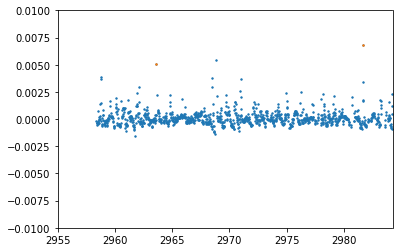

In [64]:
plt.scatter(df_k2sc.time, df_k2sc.detrended_norm, s=2)
plt.scatter(out_fixed_k2sc.tpeak, out_fixed_k2sc.unnorm_ampls, s=2)
plt.xlim([2955, max(df_k2sc.time)])
plt.ylim([-0.01, 0.01])
plt.show()

In [65]:
out_fixed_k2sc

index        tpeak  tpeaks_norm      ampls  unnorm_ampls  fixed_tpeaks  \
0       0  2907.134405   -14.700728   7.950881      0.009329   2907.154837   
1       1  2907.154837   -14.680295  24.787808      0.029084   2907.154837   
2       2  2907.175269   -14.659863   8.218694      0.009643   2907.154837   
3       3  2907.195702   -14.639431   3.675579      0.004313   2907.154837   
4       4  2909.524974   -12.310159   3.762918      0.004415   2909.524974   
5       5  2912.365041    -9.470091   6.217856      0.007296   2912.365041   
6       7  2934.472318    12.637186   3.718867      0.004363   2934.472318   
7       8  2936.270304    14.435171   4.889051      0.005736   2936.290736   
8       9  2936.290736    14.455603   5.051218      0.005927   2936.290736   
9       2  2938.640373    -7.089749   6.566433      0.007890   2938.681236   
10      3  2938.681236    -7.048886   7.885306      0.009474   2938.681236   
11      4  2938.701668    -7.028454   4.636869      0.005571   2938.681236   
12      5  2941.950291    -3.779830   3.660942      0.004399   2941.970723   
13      6  2941.970723    -3.759399   3.736220      0.004489   2941.970723   
14      7  2943.462228    -2.267894   6.762153      0.008125   2943.482659   
15      8  2943.482659    -2.247462   7.417570      0.008912   2943.482659   
16      9  2943.503091    -2.227031   5.524987      0.006638   2943.482659   
17     10  2943.523522    -2.206599   3.810399      0.004578   2943.482659   
18     11  2952.697283     6.967161   4.751424      0.005709   2952.697283   
19     12  2952.717714     6.987593   4.387337      0.005271   2952.697283   
20      0  2963.628134    -7.692522   3.946993      0.005057   2963.628134   
21      3  2981.669248    10.348591   5.287361      0.006774   2981.669248   

    fixed_fwhms   left_bases  right_bases  
0   2692.811752  2907.073108  2907.297863  
1   2692.811752  2907.073108  2907.297863  
2   2692.811752  2907.073108  2907.297863  
3   2692.811752  2907.073108  2907.297863  
4   1146.274105  2909.504541  2909.688431  
5   1637.353247  2912.344609  2912.405905  
6   4427.983674  2934.370160  2934.656203  
7   5372.381109  2936.229441  2936.454189  
8   5372.381109  2936.229441  2936.454189  
9   4827.878955  2938.599509  2938.824257  
10  5061.870589  2938.599509  2938.865120  
11  5201.293301  2938.599509  2938.885552  
12  3941.252569  2941.888996  2942.072881  
13  3941.252569  2941.888996  2942.072881  
14  6441.519970  2943.339638  2943.646112  
15  6518.908955  2943.339638  2943.666543  
16  6702.525765  2943.339638  2943.686975  
17  6702.525765  2943.339638  2943.686975  
18  5425.868484  2952.615556  2952.819872  
19  5425.868484  2952.615556  2952.819872  
20  1444.303532  2963.505545  2963.648566  
21  3472.846028  2981.628384  2981.832702

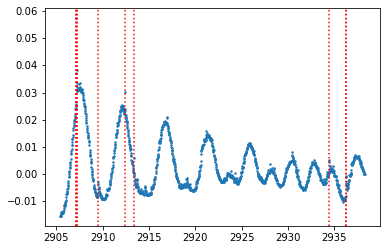

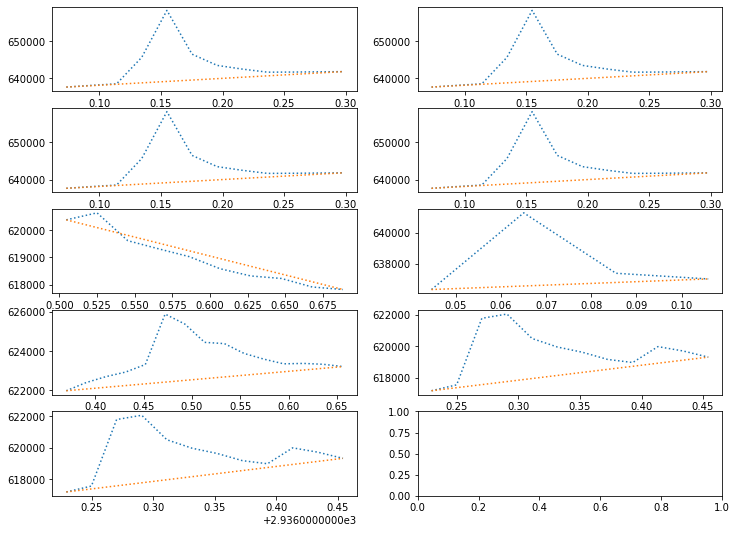

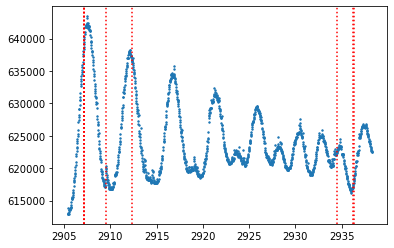

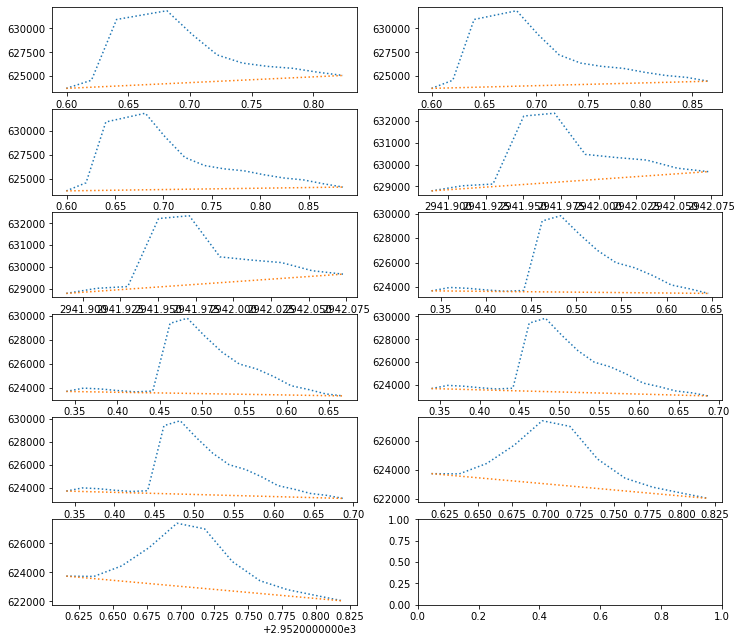

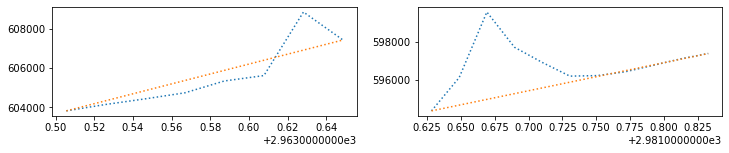

In [66]:
def subtract_flares_k2sc(df_sub, out_df_fixed):
    
    df_sub2 = copy.deepcopy(df_sub)
    df_sub2['flux_flare_subtracted'] = df_sub2.corrected

    fig, axes = plt.subplots(ncols=2, nrows=np.ceil(len(out_df_fixed)/2).astype(int), figsize=[12,len(out_df_fixed)])
    axes = axes.flatten()

    for i, j in enumerate(out_df_fixed.tpeak):
        left = out_df_fixed.iloc[i].left_bases
        right = out_df_fixed.iloc[i].right_bases
        left_y = list(df_sub2.loc[df_sub2.time == left].flux_flare_subtracted)[0]
        right_y = list(df_sub2.loc[df_sub2.time == right].flux_flare_subtracted)[0]    

        slope = (right_y - left_y)/(right-left)
        temp = df_sub.loc[(df_sub.time >= left) & (df_sub.time <= right)]
        temp2 = df_sub2.loc[(df_sub2.time >= left) & (df_sub2.time <= right)]

        ax = axes[i]
        # plot pre-subtracted for comparison
        ax.plot(temp.time, temp.corrected, linestyle=':')

        # reassign values to reflect removed flares
        ls = np.zeros(len(temp2.flux_flare_subtracted))
        for k, l in enumerate(temp2.flux_flare_subtracted):
            temp_time = temp2.iloc[k].time
            l = left_y + (temp_time-left)*slope
            ls[k] = l
        temp2.flux_flare_subtracted = ls
        
        # globally reassign subtracted flux values
        #df_sub2.loc[(df_sub2.TIME >= left) & (df_sub2.TIME <= right)].flux_flare_subtracted = temp2.flux_flare_subtracted
        df_sub2.flux_flare_subtracted.update(temp2.flux_flare_subtracted)
            
        # plot post-subtracted to confirm
        ax.plot(temp2.time, temp2.flux_flare_subtracted, linestyle=':')

    #plt.scatter(pre2.TIME, pre2.PDCSAP_FLUX, s=2)
    plt.show()
    
    return df_sub2
    
plt.scatter(pre_k2sc.time, pre_k2sc.corrected_norm, s=2)
for tpeak in out_pre_k2sc.tpeak:
    plt.axvline(tpeak, 0, 670000, color='red', linestyle=':') # did the fixed_tpeaks remove any correctly guessed OG tpeaks?
    
pre_k2sc = subtract_flares_k2sc(pre_k2sc, out_pre_fixed_k2sc)

plt.scatter(pre_k2sc.time, pre_k2sc.flux_flare_subtracted, s=2)
for tpeak in out_pre_fixed_k2sc.tpeak:
    plt.axvline(tpeak, 0, 670000, color='red', linestyle=':') # did the fixed_tpeaks remove any correctly guessed OG tpeaks?
#plt.xlim([min(pre_k2sc.time), max(pre_k2sc.time)])
plt.show()

post_k2sc = subtract_flares_k2sc(post_k2sc, out_post_fixed_k2sc)
postgap_k2sc = subtract_flares_k2sc(postgap_k2sc, out_postgap_fixed_k2sc)


Use GPs to make a smoother model upon which to inject fake flares

In [67]:
def alias_k2sc(df, normalized_flag, method, segment):
    """
    Params:
    - df: Pandas DataFrame representing light curve from MAST
    - normalized_flag: to normalize or not to normalize (Boolean)
    - method: 'gp' or 'savgol'
    - segment: 'pre', 'post', or 'postgap' (really only needed for savgol)
    
    Returns:
    - George-GP-smoothed predicted light curve (list of floats)
    """
    lhs = min(df.time)
    rhs = max(df.time)
    df = df.dropna(subset=['time', 'flux_flare_subtracted', 'error'])
    xobs = np.array(df["time"])
    yobs = np.array(df["flux_flare_subtracted"])
    eobs = np.array(df["error"])
    
    #eobs[np.isnan(eobs)] = 22 # most error values are around 22; need to be no nans
    """
    print(np.argwhere(np.isinf(xobs)))
    print(np.argwhere(np.isinf(eobs)))
    print(np.argwhere(np.isnan(xobs)))
    print(np.argwhere(np.isnan(eobs)))
    print(np.argwhere(np.isnan(yobs)))
    print(yobs)
    """
    
    kernel = np.var(yobs) * ExpSquaredKernel(0.8) # 0.8
    kernel += ExpSine2Kernel(gamma=0.1, log_period=np.log(4.5))
    kernel += 4.0 * Matern32Kernel(metric=4.0)
    
    gp = george.GP(kernel)
    gp.compute(xobs, eobs)

    if normalized_flag==False:
        if method=='gp':
            pred, pred_var = gp.predict(yobs, xobs, return_var=True)
            return pred, pred_var
        elif method=='savgol':
            if segment=='pre':
                pred = savgol_filter(yobs, 109, polyorder=3)
            elif segment=='post':
                pred = savgol_filter(yobs, 129, polyorder=3)
            elif segment=='postgap':
                pred = savgol_filter(yobs, 129, polyorder=3)
            return pred
    
    elif normalized_flag==True:
        yobs_norm = yobs/np.median(yobs) - 1
        pred, pred_var = gp.predict(yobs_norm, xobs, return_var=True)
        if method=='gp':
            pred, pred_var = gp.predict(yobs_norm, xobs, return_var=True)
            return pred, pred_var
        elif method=='savgol':
            if segment=='pre':
                pred = savgol_filter(yobs_norm, 109, polyorder=3)
            elif segment=='post':
                pred = savgol_filter(yobs_norm, 149, polyorder=3)
            elif segment=='postgap':
                pred = savgol_filter(yobs_norm, 129, polyorder=3)
            return pred

pred_pre_fixed_k2sc, pred_var_pre_fixed_k2sc = alias_k2sc(pre_k2sc, normalized_flag=True, method='gp', segment='pre')
pred_post_fixed_k2sc, pred_var_post_fixed_k2sc = alias_k2sc(post_k2sc, normalized_flag=True, method='gp', segment='post')
#pred_pre_fixed = alias(pre_fixed, normalized_flag=True, method='savgol', segment='pre')
#pred_post_fixed = alias(post_fixed, normalized_flag=True, method='savgol', segment='post')
pred_postgap_fixed_k2sc, pred_var_postgap_fixed_k2sc = alias_k2sc(postgap_k2sc, normalized_flag=True, method='gp', segment='postgap')

pre_k2sc_fixed = pre_k2sc.dropna(subset=['time', 'flux_flare_subtracted', 'error'])
post_k2sc_fixed = post_k2sc.dropna(subset=['time', 'flux_flare_subtracted', 'error'])
postgap_k2sc_fixed = postgap_k2sc.dropna(subset=['time', 'flux_flare_subtracted', 'error'])

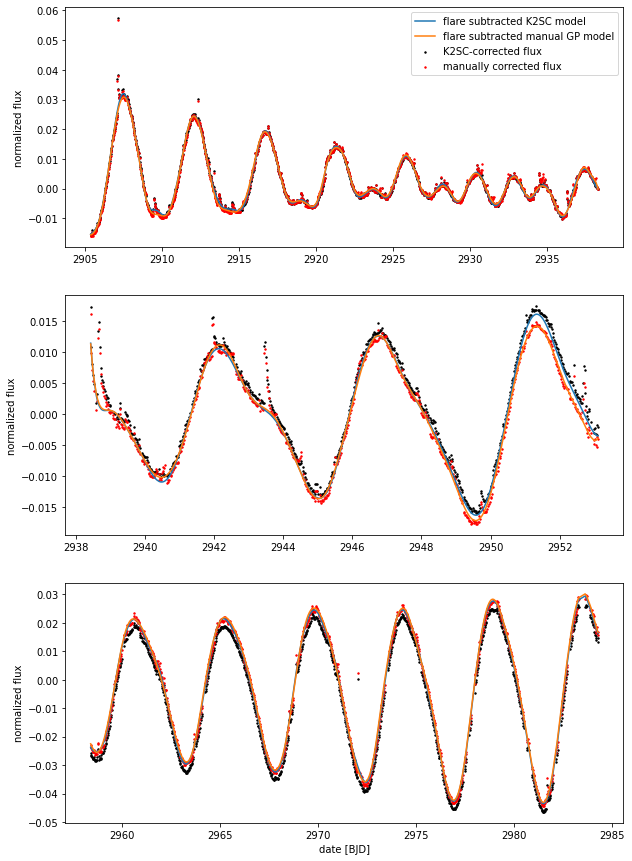

In [68]:
plt.figure(figsize=(10,15))
plt.subplot(311)
plt.plot(pre_k2sc_fixed.time, pred_pre_fixed_k2sc, label='flare subtracted K2SC model')
#plt.plot(pre.TIME, pred_pre, label='manual GP')
plt.plot(pre.TIME, pred_pre_fixed, label='flare subtracted manual GP model')
plt.scatter(pre_k2sc.time, pre_k2sc.corrected_norm, s=2, color='k', label='K2SC-corrected flux') 
plt.scatter(pre.TIME, norm_flux_pre, s=2, color='r', label='manually corrected flux') 
plt.ylabel('normalized flux')
plt.legend()

plt.subplot(312)
plt.plot(post_k2sc_fixed.time, pred_post_fixed_k2sc, label='flare subtracted K2SC model')
#plt.plot(post.TIME, pred_post, label='manual GP')
plt.plot(post.TIME, pred_post_fixed, label='flare subtracted manual GP model')
plt.scatter(post_k2sc.time, post_k2sc.corrected_norm, s=2, color='k', label='K2SC-corrected flux') 
plt.scatter(post.TIME, norm_flux_post, s=2, color='r', label='manually corrected flux') 
plt.ylabel('normalized flux')
#plt.legend()

plt.subplot(313)
plt.plot(postgap_k2sc_fixed.time, pred_postgap_fixed_k2sc, label='flare subtracted K2SC model')
#plt.plot(postgap.TIME, pred_postgap, label='manual GP')
plt.plot(postgap.TIME, pred_postgap_fixed, label='flare subtracted manual GP model')
plt.scatter(postgap_k2sc.time, postgap_k2sc.corrected_norm, s=2, color='k', label='K2SC-corrected flux') 
plt.scatter(postgap.TIME, norm_flux_postgap, s=2, color='r', label='manually corrected flux') 
plt.ylabel('normalized flux')
plt.xlabel('date [BJD]')
#plt.legend()
plt.savefig('k2sc_vs_manual_data.pdf', format='pdf')
plt.show()

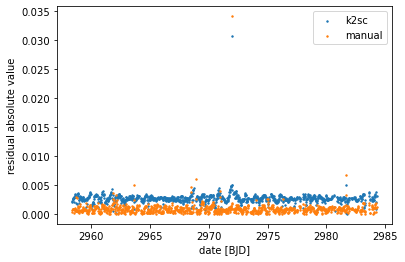

In [69]:
plt.scatter(postgap_k2sc_fixed.time, np.abs(pred_postgap_fixed_k2sc-postgap_k2sc_fixed.corrected_norm), label='k2sc', s=2)
plt.scatter(postgap.TIME, np.abs(pred_postgap_fixed-norm_flux_postgap), label='manual', s=2)
plt.legend()
plt.xlabel('date [BJD]')
plt.ylabel('residual absolute value')
plt.show()


Hmm, it's not fair that I assess the k2sc corrections applied over the whole light curve vs manual corrections done piecemeal. 

So let's break k2sc into parts as well and re-run k2sc on them. Then, let's put them back together.

In [70]:
# hmm, it's not fair that I assess the k2sc corrections applied over the whole light curve vs manual corrections done piecemeal. 
# so let's break k2sc into parts as well and re-run k2sc on them. Then, let's put them back together.
pre_k2sc[['time', 'cadence', 'quality', 'x', 'y', 'flux', 'error', 'mflags']].to_csv('pre_k2sc.csv', index=False)
post_k2sc[['time', 'cadence', 'quality', 'x', 'y', 'flux', 'error', 'mflags']].to_csv('post_k2sc.csv', index=False)
postgap_k2sc[['time', 'cadence', 'quality', 'x', 'y', 'flux', 'error', 'mflags']].to_csv('postgap_k2sc.csv', index=False)


In [113]:
hdu_prek2sc=fits.BinTableHDU([pre_k2sc])
hdul_prek2sc=fits.HDUList([hdu_prek2sc])

TypeError: Table data has incorrect type.

In [112]:
hdul_k2sc[1]

In [81]:
hdu_prek2sc.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                   14                                                  
NAXIS2  =                 1586                                                  
NAXIS3  =                    1                                                  
EXTEND  =                    T                                                  

In [ ]:
hdu_prek2sc[0].header = hdul_k2sc[0].header

In [101]:
hdul_prek2sc.writeto('pre_k2sc.fits')

In [108]:
# compare everything
filename_prek2sc = '/Users/chrislam/Desktop/epic-246301900/injection-recovery/pre_k2sc.fits'
hdul_prek2sc = fits.open(filename_prek2sc)
#hdul_prek2sc.info()
data_prek2sc = fits.getdata(filename_prek2sc,header=True)
df_prek2sc = pd.DataFrame(np.array(data_prek2sc).byteswap().newbyteorder())
df_prek2sc

0
0  [[[2905.37723009599, 136855.0, 524288.0, -0.07...
1  [SIMPLE, BITPIX, NAXIS, NAXIS1, NAXIS2, NAXIS3...

Resume analysis

In [71]:
pre_k2sc_fixed['smoothed'] = pred_pre_fixed_k2sc # based off of corrected_norm
post_k2sc_fixed['smoothed'] = pred_post_fixed_k2sc
postgap_k2sc_fixed['smoothed'] = pred_postgap_fixed_k2sc

In [72]:
pred_df = pd.concat([pre_k2sc_fixed['smoothed'], post_k2sc_fixed['smoothed'], postgap_k2sc_fixed['smoothed']])
print(pred_df)
pred_df.to_csv('preds_k2sc.csv',index=False)

1      -0.015385
2      -0.015276
3      -0.015171
4      -0.015070
5      -0.014972
          ...   
3520    0.018189
3521    0.017780
3523    0.017040
3524    0.016714
3525    0.016421
Name: smoothed, Length: 3246, dtype: float64


##### d. Inject fake flares

In [101]:
from altaipony.fakeflares import generate_fake_flare_distribution, mod_random, aflare

def inject_fakes(flux, df, num_flares):
    
    def _equivalent_duration(time, flux):
            '''
            Compute the Equivalent Duration of a fake flare.
            This is the area under the flare, in relative flux units.
            Parameters:
            -------------
            time : numpy array
                units of DAYS
            flux : numpy array
                relative flux units
            Return:
            ------------
            p : float
                equivalent duration of a single event in units of seconds
            '''
            x = time * 60.0 * 60.0 * 24.0
            integral = np.sum(np.diff(x) * flux[:-1])
            return integral
        
    # Init arrays for the synthetic flare parameters
    nfake = num_flares # 20 flares per time chunk for a total of 60 fake flares
    t0_fake = np.zeros(nfake, dtype='float') # peak times
    ed_fake = np.zeros(nfake, dtype='float') # ED
    #dur_fake = np.zeros(nfake, dtype='float') # duration
    #ampl_fake = np.zeros(nfake, dtype='float') # amplitude

    # Init the synthetic flare counter to allow to point to the right
    # places in the arrays above (XXX_fake etc.)
    ckm = 0

    # Pick flux, time, and flux error arrays 
    #error = error # pred_var_pre
    flux = flux # pred_pre
    try:
        time = np.array(df.time)
    except:
        time = np.array(df.TIME)
    #print(np.array(time))
    #print(download.time.value)
    
    # generate the time constraints for the flares you want to inject
    mintime, maxtime = np.min(time), np.max(time)
    dtime = maxtime - mintime

    # generate a distribution of durations and amplitudes
    d = False
    seed = 23 # mashed keyboard idk
    #default: ampl=[1e-4, 5], dur=[0.005, 0.012]
    distribution  = generate_fake_flare_distribution(nfake, d=d,
                                            seed=seed, ampl=[1e-4, 5]) # [1e-4, 6e-2]
    dur_fake = distribution[0]
    ampl_fake = distribution[1]    
    print(ampl_fake)
    
    for k in range(nfake):
        # add the peak time to the list and note the index
        t0 = (mod_random(1, d=d) * dtime + mintime)[0]
        t0_fake[k] = t0
    
        # generate the flare flux from the Davenport 2014 model
        fl_flux = aflare(time, t0, dur_fake[k], ampl_fake[k])
        
        # calculate the injected ED
        ed_fake[k] = _equivalent_duration(time, fl_flux)
        
        # inject flare into light curve by adding the flare flux
        flux = flux + fl_flux
        #fake_lc[typ].value[le:ri] = (fake_lc[typ][le:ri].value +
        #                            fl_flux * fake_lc.it_med[le:ri].value)
    
    return dur_fake, ampl_fake, t0_fake, ed_fake, flux

### here are my fake flares, injected into the normalized K2SC-corrected light curve
dur_fake_pre_k2sc, ampl_fake_pre_k2sc, t0_fake_pre_k2sc, ed_fake_pre_k2sc, flux_pre_k2sc = inject_fakes(pre_k2sc_fixed['smoothed'], pre_k2sc_fixed, num_flares=20)
dur_fake_post_k2sc, ampl_fake_post_k2sc, t0_fake_post_k2sc, ed_fake_post_k2sc, flux_post_k2sc = inject_fakes(post_k2sc_fixed['smoothed'], post_k2sc_fixed, num_flares=10)
dur_fake_postgap_k2sc, ampl_fake_postgap_k2sc, t0_fake_postgap_k2sc, ed_fake_postgap_k2sc, flux_postgap_k2sc = inject_fakes(postgap_k2sc_fixed['smoothed'] , postgap_k2sc_fixed, num_flares=20)


[3.53053916 1.99310418 1.84603824 3.87703691 0.72690037 1.83660985
 2.83470151 1.29155847 3.85333704 2.27853787 3.80098363 2.66941982
 4.85564622 1.69341825 0.81456651 4.28210245 1.8332688  2.7746099
 0.7270464  4.43392251]
[0.18396695 0.94566066 4.31203872 4.15843363 0.09751103 2.90862187
 2.16087746 2.00202862 4.76331317 2.71672281]
[4.05145579 0.77960422 4.32820942 4.63549922 3.37674037 1.69616041
 3.9006868  2.57892434 3.54995432 2.89394384 1.96118352 0.09653508
 2.19902129 2.37059977 4.67726426 0.22067246 2.10373856 3.44395289
 1.96572758 2.91357785]


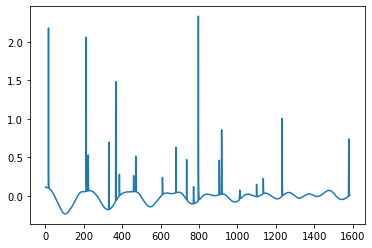

In [102]:
plt.plot(flux_pre_k2sc-pre_k2sc_fixed.smoothed/np.std(flux_pre_k2sc-pre_k2sc_fixed.smoothed))

##### e. Recovery tests

[2905.72457902 2909.77015977 2909.9949135  2912.20158437 2912.93713988
 2915.1029387  2919.49581564 2920.66043536 2921.92721305 2924.17471765
 2924.41989966 2930.95806758 2938.19087722 2938.21130883]


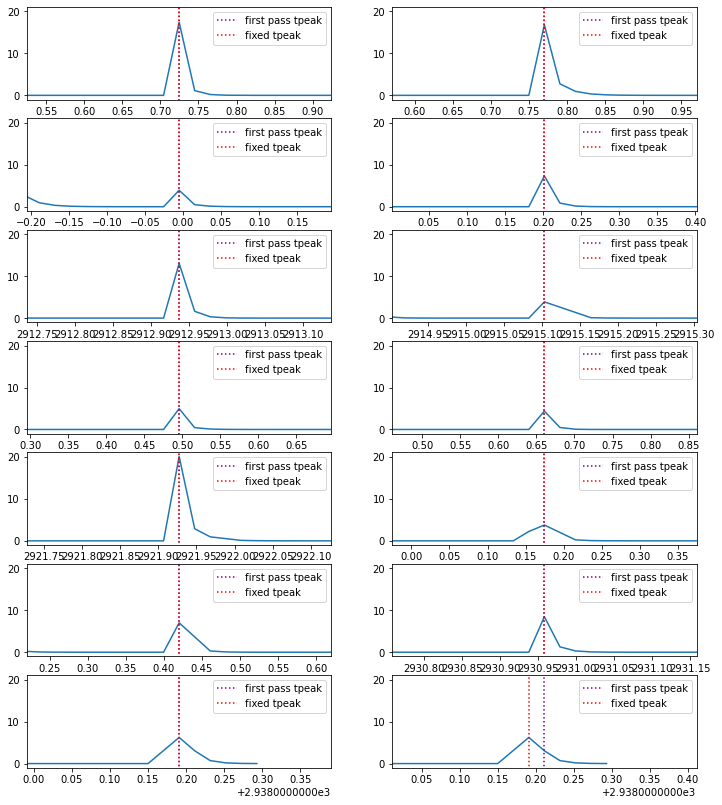

before:  14
after:  14
[2939.31461585 2942.76755433 2943.68697487 2944.34078495 2946.01617216
 2947.32379101 2950.44981517 2952.59512488]


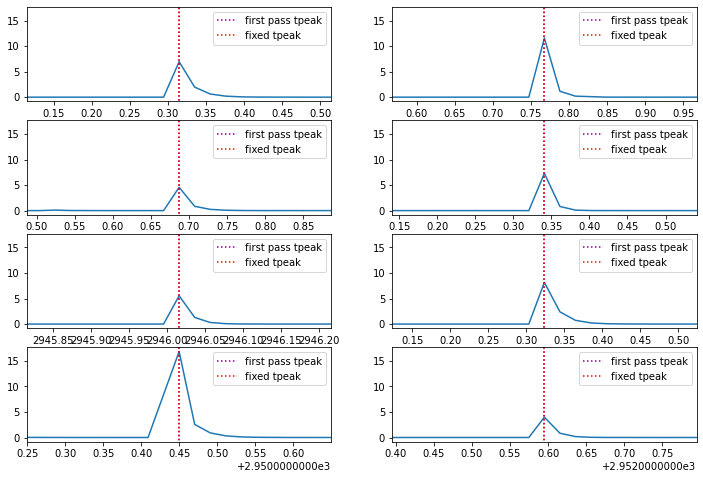

before:  8
after:  8
[2959.1331993  2962.54526337 2963.17864072 2968.22523226 2974.43643602
 2975.1311113  2978.13456405 2978.15499572 2981.73054302]


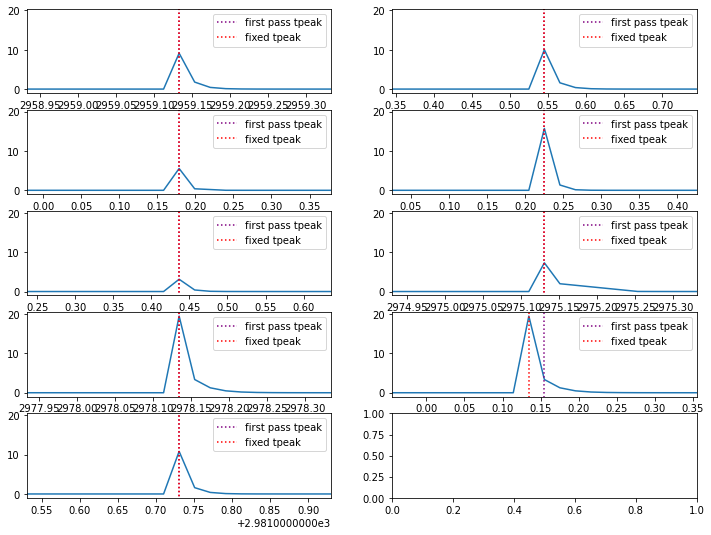

before:  9
after:  9
14 0 6
8 0 2
9 0 11


In [127]:
import warnings
warnings.filterwarnings("ignore")

def find_flares_k2sc(lc, flux, N1, N2):
    """
    Adapted from Tom Barclay's xoflares: https://github.com/mrtommyb/xoflares
    Params:
    - lc: DataFrame with PDCSAP_FLUX_ERR, PDCSAP_FLUX, and CADENCENO fields
    - flux:  GP-predicted flux with flares injected
    - N1: int or float (default is 3)
        How many times above sigma is required.
    - N2: int or float (Default is 3)
        How many times above sigma and detrended_flux_err is required
        
    Returns:
    - x: lc.TIME - ref_time
    - y: flux param
    - tpeaks: start time of flares (corresponds to lc.TIME)
    - tpeaks_norm: start time of flares (normalized to correspond to x)
    - ampls: flare amplitudes
    - fwhms: full-width half-maxes of flares
    - npeaks: number of flares identified
    """
    
    # find some flares
    #mflare = flux < N1 * np.sqrt(np.mean(flux**2))
    unnorm_flux = flux # save this for ampls
    detrended_flux = flux - lc.smoothed # detrend
    flux = detrended_flux/np.std(detrended_flux) # rewrite flux in standard deviations
    #print(flux)
    #print(lc.error/np.nanmedian(lc.error))
    #print(flux - lc.error/np.nanmedian(lc.error))
    #plt.scatter(lc.time, flux - lc.error/np.nanmedian(lc.error), s=2)
    #plt.show()

    mflare = (flux < N1) & (flux - lc.error/np.nanmedian(lc.error) < N2) # the way Tom wrote it in xoflares
    mflare = flux > N1 
    #print(mflare[mflare==True])
    #asdfadf
    
    # resume flare identification code from xoflares
    cads = lc.cadence - list(lc.cadence)[0] # index CADENCENO at 0
    ref_time = calculate_ref_time(lc)
    x = lc.time - ref_time # subtract time by average time
    y = flux # data with savgol subtracted OR normalized data

    fidx = cads.loc[~mflare][:-1]#[np.diff(cads[~mflare]) < 1] # the way Tom wrote it in xoflares
    fidx = cads.loc[mflare] 
    fidx = list(fidx) # address indexing errors
    #plt.scatter(lc.time, lc.detrended_norm, s=2)
    #plt.scatter(lc.iloc[fidx].time, lc.iloc[fidx].detrended_norm, s=10, color='r')
    #plt.show()

    npts = np.array([])
    i = 0
    n = 1
    """
    while True:
        try:
            if fidx[i + 1] == fidx[i] + n:
                # measure flare: keep track of number of points (fatness) of a flare
                # if I care about consecutive points, this is where I'd deal with it
                fidx = np.delete(fidx, i + 1)
                n += 1
            else:
                # count flare: concatenate to array, advance, and reset count
                npts = np.r_[npts, n+1] 
                i += 1
                n = 1
        except IndexError:
            npts = np.r_[npts, n+1]
            break
    """    
    tpeaks = np.array([lc.time.loc[cads == fidx[i]].values for i in range(len(fidx))]).T[0]
    print(tpeaks)
    #plt.scatter(lc.time, flux, s=2)
    #plt.scatter(tpeaks, lc.loc[lc.time.isin(tpeaks)].detrended_norm, s=10, color='r')
    #plt.show()

    tpeaks_norm = np.array([x.loc[cads == fidx[i]].values for i in range(len(fidx))]).T[0]
    try: # if flux given is a DataFrame (eg. norm_flux_pre)
        unnorm_ampls = np.array([unnorm_flux.loc[cads == fidx[i]].values for i in range(len(fidx))]).T[0]
        ampls = np.array([detrended_flux.loc[cads == fidx[i]].values for i in range(len(fidx))]).T[0]
    except: # if flux given is a np.array (eg. flux_pre)
        unnorm_ampls = np.array([unnorm_flux[cads == fidx[i]] for i in range(len(fidx))]).T[0]
        ampls = np.array([detrended_flux[cads == fidx[i]] for i in range(len(fidx))]).T[0]
    fwhms = np.asarray(npts) * (2/1440) 
    npeaks = np.shape(tpeaks)[0]
    #print(tpeaks, ampls, fwhms, npeaks)
    #print(fidx)
    

    height = 1.4
    distance = 5
    wlen = 5
    width_left = None
    width_right = 5
    buffer = 0.2 # essentially the wlen for find_peaks()

    fixed_tpeaks = []
    fixed_fwhms = []
    left_bases_all = []
    right_bases_all = []

    fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
    axes = axes.flatten()
    for i in range(npeaks):
        ### take snapshot of time and flux around identified flare
        snapshot_time = lc.time[(lc.time > tpeaks[i]-buffer) & (lc.time < tpeaks[i]+buffer)] 
        #snapshot = detrended[(lc.time > tpeaks[i]-buffer) & (lc.time < tpeaks[i]+buffer)] 
        snapshot_std = flux[(lc.time > tpeaks[i]-buffer) & (lc.time < tpeaks[i]+buffer)] 

        ### run scipy.signal.find_peaks() to identify actual peak
        peaks, _ = find_peaks(snapshot_std, height=height, distance=distance, width=(width_left,width_right))
        prominences, left_bases, right_bases = peak_prominences(snapshot_std, peaks)
        widths = peak_widths(snapshot_std, peaks, prominence_data=(prominences, left_bases, right_bases))[0]
        #print(np.array(snapshot_time)[peaks], tpeaks_pre[i])
        
        ### plot
        ax = axes[i]
        ax.plot(lc.time, flux) # norm_flux_pre
        if len(peaks)>0:
            ax.axvline(tpeaks[i], -1, 1, color='purple', linestyle=':', label='first pass tpeak')
            ax.axvline(np.array(snapshot_time)[peaks][0], -1, 1, color='r', linestyle=':', label='fixed tpeak')
            fixed_tpeaks.append(np.array(snapshot_time)[peaks][0])
            fixed_fwhm = widths*30*60
            fixed_fwhms.append(fixed_fwhm[0])
            left_bases_all.append(np.array(snapshot_time)[left_bases][0])
            right_bases_all.append(np.array(snapshot_time)[right_bases][0])
        else:
            fixed_tpeaks.append(np.nan) # for dropping later
            fixed_fwhms.append(np.nan)
            left_bases_all.append(np.nan)
            right_bases_all.append(np.nan)

        ax.set_xlim(tpeaks[i]-buffer, tpeaks[i]+buffer)
        ax.legend()
        #ax.set_ylim(min(snapshot), max(snapshot))

    plt.show()

    out = pd.DataFrame({'tpeak': tpeaks, 'tpeaks_norm': tpeaks_norm, 'ampls': ampls, 'unnorm_ampls': unnorm_ampls})

    # attach fixed tpeaks and fwhm columns to xoflares flare identification dataframe, then drop nans
    out['fixed_tpeaks'] = fixed_tpeaks
    out['fixed_fwhms'] = fixed_fwhms
    out['left_bases'] = left_bases_all
    out['right_bases'] = right_bases_all
    print("before: ", len(out))
    out = out.dropna()
    print("after: ", len(out))
    
    tpeaks_norm = out.fixed_tpeaks
    
    """
    ### enter: scipy.signal.find_peaks() for cleanup duty
    height = 1.1
    distance = 10
    wlen = 5
    width_left = None
    width_right = 10
    buffer = 0.1 # essentially the wlen for find_peaks()
    for i in range(npeaks):
        ### take snapshot of time and flux around identified flare
        snapshot_time = lc.time[(lc.time > tpeaks[i]-buffer) & (lc.time < tpeaks[i]+buffer)] 
        snapshot = unnorm_flux[(lc.time > tpeaks[i]-buffer) & (lc.time < tpeaks[i]+buffer)] 
        snapshot_std = flux[(lc.time > tpeaks[i]-buffer) & (lc.time < tpeaks[i]+buffer)] 
        
        ### run scipy.signal.find_peaks() to identify actual peak
        peaks, _ = find_peaks(snapshot_std, height=height, distance=distance, width=(width_left,width_right))
        prominences, left_bases, right_bases = peak_prominences(snapshot_std, peaks)
        #tpeaks = np.array(snapshot_time)[peaks]
        #print(peaks)
    """
    
    return x, y, tpeaks, tpeaks_norm, ampls, unnorm_ampls, fwhms, npeaks, out

def analyze_recovery_for_xoflares(tpeaks, t0_fake, tol):
    # analyze_recovery(pre, t0_fake_pre, istart_gap_pre, istop_gap_pre)
    """
    Calculate TPs, FPs, and FNs
    Params: 
    - tpeaks: recovered tpeaks (so not really start times, but we'll use a tolerance to get around that
    - t0_fake: one of the outputs of inject_fakes(); all of the ground truth flare start times
    - tol: tolerance [days]
    Returns:
    - TPs: true positives (int)
    - FPs: false positives (int)
    - FNs: false negatives (int)
    """
    tps = 0
    #print(len(tpeaks))
    """
    for i in t0_fake:
        if (np.abs(i - tpeaks) < tol).any():
            tps += 1
    """
    
    # this way, I can't accidentally have TPs > number of predictions
    for i in tpeaks:
        if (np.abs(i - t0_fake) < tol).any():
            tps += 1
            
    fps = np.abs(len(tpeaks) - tps)    
    fns = len(t0_fake) - fps - tps
    
    return tps, fps, fns

N1 = 3
N2 = 3

#x, y, tpeaks, tpeaks_norm, ampls, fwhms, npeaks = find_flares(pre, norm_flux_pre, pred_pre, N1, N2)
#_, _, tpeaks_pre, _, _, _, _ = find_flares(pre, flux_pre, pred_pre, N1, N2) 
#_, _, tpeaks_post, _, _, _, _ = find_flares(post, flux_post, pred_post, N1, N2)
x_pre_k2sc_fixed, y_pre_k2sc_fixed, tpeaks_pre_k2sc_fixed, tpeaks_norm_pre_k2sc_fixed, ampls_pre_k2sc_fixed, unnorm_ampls_pre_k2sc_fixed, fwhms_pre_k2sc_fixed, npeaks_pre_k2sc_fixed, out_pre_k2sc_fixed = find_flares_k2sc(pre_k2sc_fixed, flux_pre_k2sc, N1, N2)
x_post_k2sc_fixed, y_post_k2sc_fixed, tpeaks_post_k2sc_fixed, tpeaks_norm_post_k2sc_fixed, ampls_post_k2sc_fixed, unnorm_ampls_post_k2sc_fixed, fwhms_post_k2sc_fixed, npeaks_post_k2sc_fixed, out_post_k2sc_fixed = find_flares_k2sc(post_k2sc_fixed, flux_post_k2sc, N1, N2)
x_postgap_k2sc_fixed, y_postgap_k2sc_fixed, tpeaks_postgap_k2sc_fixed, tpeaks_norm_postgap_k2sc_fixed, ampls_postgap_k2sc_fixed, unnorm_ampls_postgap_k2sc_fixed, fwhms_postgap_k2sc_fixed, npeaks_postgap_k2sc_fixed, out_postgap_k2sc_fixed = find_flares_k2sc(postgap_k2sc_fixed, flux_postgap_k2sc, N1, N2)

idx_interval = pre_k2sc_fixed.time[2] - pre_k2sc_fixed.time[1] # time spanned by one index
tol = 3 # reminiscent of minsep from altaipony        
tps_pre_k2sc, fps_pre_k2sc, fns_pre_k2sc = analyze_recovery_for_xoflares(tpeaks_pre_k2sc_fixed, t0_fake_pre_k2sc, tol=tol*idx_interval)
tps_post_k2sc, fps_post_k2sc, fns_post_k2sc = analyze_recovery_for_xoflares(tpeaks_post_k2sc_fixed, t0_fake_post_k2sc, tol=tol*idx_interval)
tps_postgap_k2sc, fps_postgap_k2sc, fns_postgap_k2sc = analyze_recovery_for_xoflares(tpeaks_postgap_k2sc_fixed, t0_fake_postgap_k2sc, tol=tol*idx_interval)

print(tps_pre_k2sc, fps_pre_k2sc, fns_pre_k2sc)
print(tps_post_k2sc, fps_post_k2sc, fns_post_k2sc)
print(tps_postgap_k2sc, fps_postgap_k2sc, fns_postgap_k2sc)


N1 = 2: FN = 9

N1 = 2.5: FN = 14

N1 = 3: FN = 19

##### f. Identify flares in the normalized detrended K2SC light curve using new parameters. ie. just be less strict, and now I know exactly how much less strict.

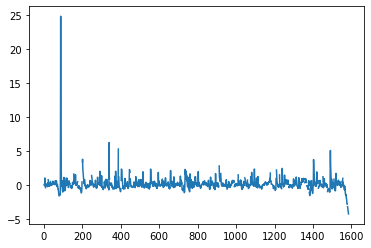

In [128]:
plt.plot(pre_k2sc['detrended_norm']/np.std(pre_k2sc['detrended_norm']))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[2907.1344051  2907.15483734 2907.17526948 2907.19570182 2909.50454142
 2909.5249737  2912.36504131 2913.36621372 2934.4723184  2936.27030402
 2936.29073556]


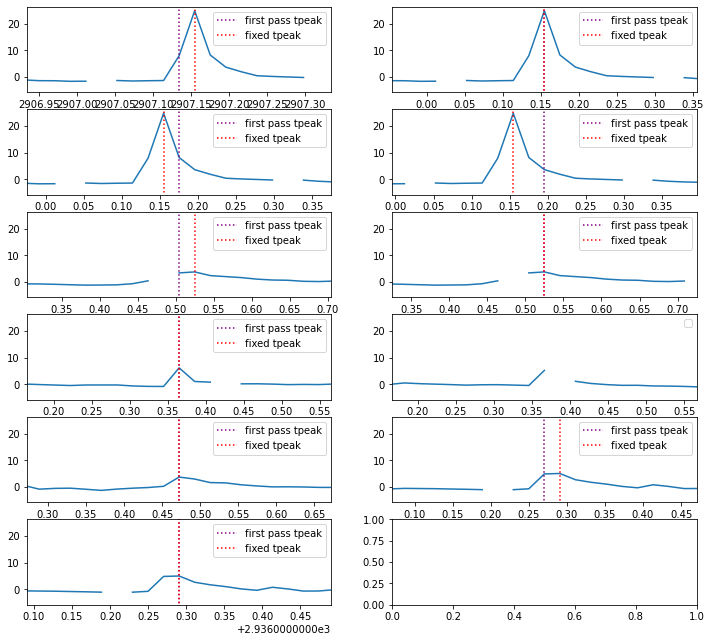

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


before:  11
after:  10
[2938.43605659 2938.4564882  2938.64037271 2938.68123593 2938.70166754
 2941.95029121 2941.97072289 2943.46222768 2943.48265925 2943.50309091
 2943.52352237 2952.69728255 2952.71771406]


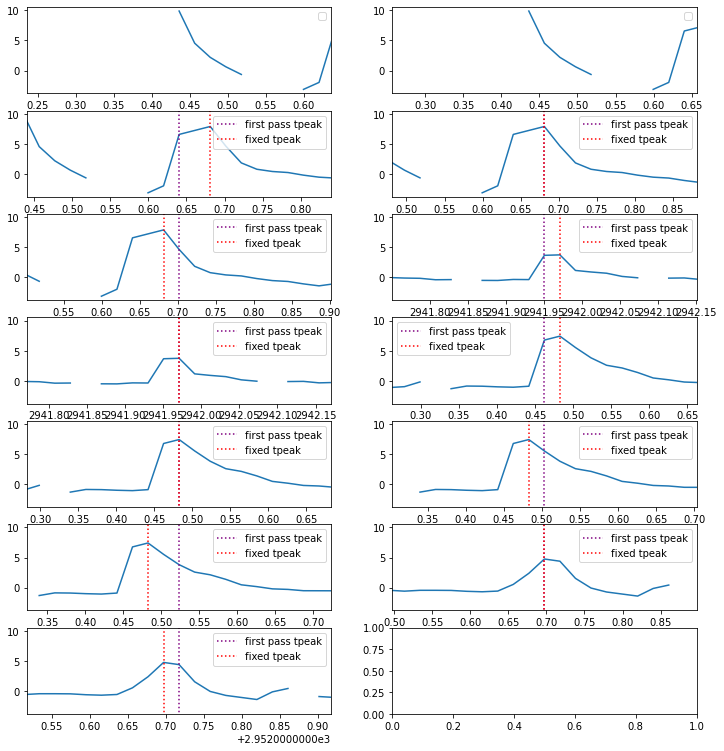

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


before:  13
after:  11
[2958.74500057 2963.62813442 2968.87904238 2972.00507432 2981.66924776]


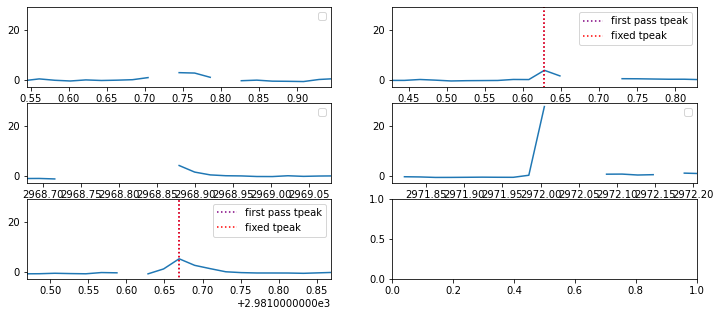

before:  5
after:  2
23
    index        tpeak  tpeaks_norm  std_ampls     ampls  fixed_tpeaks  \
0       0  2907.134405   -14.700728   7.950881  0.009329   2907.154837   
1       1  2907.154837   -14.680295  24.787808  0.029084   2907.154837   
2       2  2907.175269   -14.659863   8.218694  0.009643   2907.154837   
3       3  2907.195702   -14.639431   3.675579  0.004313   2907.154837   
4       4  2909.504541   -12.330591   3.386597  0.003974   2909.524974   
5       5  2909.524974   -12.310159   3.762918  0.004415   2909.524974   
6       6  2912.365041    -9.470091   6.217856  0.007296   2912.365041   
7       8  2934.472318    12.637186   3.718867  0.004363   2934.472318   
8       9  2936.270304    14.435171   4.889051  0.005736   2936.290736   
9      10  2936.290736    14.455603   5.051218  0.005927   2936.290736   
10      2  2938.640373    -7.089749   6.566433  0.007890   2938.681236   
11      3  2938.681236    -7.048886   7.885306  0.009474   2938.681236   
12      4  293

In [129]:
def find_flares_k2sc(lc, flux, N1, N2):
    """
    Adapted from Tom Barclay's xoflares: https://github.com/mrtommyb/xoflares
    Params:
    - lc: DataFrame with PDCSAP_FLUX_ERR, PDCSAP_FLUX, and CADENCENO fields
    - flux:  GP-predicted flux with flares injected
    - N1: int or float (default is 3)
        How many times above sigma is required.
    - N2: int or float (Default is 3)
        How many times above sigma and detrended_flux_err is required
        
    Returns:
    - x: lc.TIME - ref_time
    - y: flux param
    - tpeaks: start time of flares (corresponds to lc.TIME)
    - tpeaks_norm: start time of flares (normalized to correspond to x)
    - ampls: flare amplitudes
    - fwhms: full-width half-maxes of flares
    - npeaks: number of flares identified
    """
    
    # find some flares
    #mflare = flux < N1 * np.sqrt(np.mean(flux**2))
    unnorm_flux = flux # save this for ampls
    flux = flux/np.std(flux) # rewrite flux in standard deviations
    #print(flux)
    #print(lc.error/np.nanmedian(lc.error))
    #print(flux - lc.error/np.nanmedian(lc.error))
    #plt.scatter(lc.time, flux - lc.error/np.nanmedian(lc.error), s=2)
    #plt.show()

    mflare = (flux < N1) & (flux - lc.error/np.nanmedian(lc.error) < N2) # the way Tom wrote it in xoflares
    mflare = flux > N1 
    #print(mflare[mflare==True])
    #asdfadf
    
    # resume flare identification code from xoflares
    cads = lc.cadence - list(lc.cadence)[0] # index CADENCENO at 0
    ref_time = calculate_ref_time(lc)
    x = lc.time - ref_time # subtract time by average time
    y = flux # data with savgol subtracted OR normalized data

    fidx = cads.loc[~mflare][:-1]#[np.diff(cads[~mflare]) < 1] # the way Tom wrote it in xoflares
    fidx = cads.loc[mflare] 
    fidx = list(fidx) # address indexing errors
    #plt.scatter(lc.time, lc.detrended_norm, s=2)
    #plt.scatter(lc.iloc[fidx].time, lc.iloc[fidx].detrended_norm, s=10, color='r')
    #plt.show()

    npts = np.array([])
    i = 0
    n = 1
    """
    while True:
        try:
            if fidx[i + 1] == fidx[i] + n:
                # measure flare: keep track of number of points (fatness) of a flare
                # if I care about consecutive points, this is where I'd deal with it
                fidx = np.delete(fidx, i + 1)
                n += 1
            else:
                # count flare: concatenate to array, advance, and reset count
                npts = np.r_[npts, n+1] 
                i += 1
                n = 1
        except IndexError:
            npts = np.r_[npts, n+1]
            break
    """    
    tpeaks = np.array([lc.time.loc[cads == fidx[i]].values for i in range(len(fidx))]).T[0]
    print(tpeaks)
    #plt.scatter(lc.time, flux, s=2)
    #plt.scatter(tpeaks, lc.loc[lc.time.isin(tpeaks)].detrended_norm, s=10, color='r')
    #plt.show()

    tpeaks_norm = np.array([x.loc[cads == fidx[i]].values for i in range(len(fidx))]).T[0]
    try: # if flux given is a DataFrame (eg. norm_flux_pre)
        unnorm_ampls = np.array([unnorm_flux.loc[cads == fidx[i]].values for i in range(len(fidx))]).T[0]
        ampls = np.array([flux.loc[cads == fidx[i]].values for i in range(len(fidx))]).T[0]
    except: # if flux given is a np.array (eg. flux_pre)
        unnorm_ampls = np.array([unnorm_flux[cads == fidx[i]] for i in range(len(fidx))]).T[0]
        ampls = np.array([flux[cads == fidx[i]] for i in range(len(fidx))]).T[0]
    fwhms = np.asarray(npts) * (2/1440) 
    npeaks = np.shape(tpeaks)[0]
    #print(tpeaks, ampls, fwhms, npeaks)
    #print(fidx)
    

    height = 1.4
    distance = 5
    wlen = 5
    width_left = None
    width_right = 5
    buffer = 0.2 # essentially the wlen for find_peaks()

    fixed_tpeaks = []
    fixed_fwhms = []
    left_bases_all = []
    right_bases_all = []

    fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
    axes = axes.flatten()
    for i in range(npeaks):
        ### take snapshot of time and flux around identified flare
        snapshot_time = lc.time[(lc.time > tpeaks[i]-buffer) & (lc.time < tpeaks[i]+buffer)] 
        #snapshot = detrended[(lc.time > tpeaks[i]-buffer) & (lc.time < tpeaks[i]+buffer)] 
        snapshot_std = flux[(lc.time > tpeaks[i]-buffer) & (lc.time < tpeaks[i]+buffer)] 

        ### run scipy.signal.find_peaks() to identify actual peak
        peaks, _ = find_peaks(snapshot_std, height=height, distance=distance, width=(width_left,width_right))
        prominences, left_bases, right_bases = peak_prominences(snapshot_std, peaks)
        widths = peak_widths(snapshot_std, peaks, prominence_data=(prominences, left_bases, right_bases))[0]
        #print(np.array(snapshot_time)[peaks], tpeaks_pre[i])
        
        ### plot
        ax = axes[i]
        ax.plot(lc.time, flux) # norm_flux_pre
        if len(peaks)>0:
            ax.axvline(tpeaks[i], -1, 1, color='purple', linestyle=':', label='first pass tpeak')
            ax.axvline(np.array(snapshot_time)[peaks][0], -1, 1, color='r', linestyle=':', label='fixed tpeak')
            fixed_tpeaks.append(np.array(snapshot_time)[peaks][0])
            fixed_fwhm = widths*30*60
            fixed_fwhms.append(fixed_fwhm[0])
            left_bases_all.append(np.array(snapshot_time)[left_bases][0])
            right_bases_all.append(np.array(snapshot_time)[right_bases][0])
        else:
            fixed_tpeaks.append(np.nan) # for dropping later
            fixed_fwhms.append(np.nan)
            left_bases_all.append(np.nan)
            right_bases_all.append(np.nan)

        ax.set_xlim(tpeaks[i]-buffer, tpeaks[i]+buffer)
        ax.legend()
        #ax.set_ylim(min(snapshot), max(snapshot))

    plt.show()

    out = pd.DataFrame({'tpeak': tpeaks, 'tpeaks_norm': tpeaks_norm, 'std_ampls': ampls, 'ampls': unnorm_ampls})

    # attach fixed tpeaks and fwhm columns to xoflares flare identification dataframe, then drop nans
    out['fixed_tpeaks'] = fixed_tpeaks
    out['fixed_fwhms'] = fixed_fwhms
    out['left_bases'] = left_bases_all
    out['right_bases'] = right_bases_all
    print("before: ", len(out))
    out = out.dropna()
    print("after: ", len(out))
    
    tpeaks_norm = out.fixed_tpeaks
    
    """
    ### enter: scipy.signal.find_peaks() for cleanup duty
    height = 1.1
    distance = 10
    wlen = 5
    width_left = None
    width_right = 10
    buffer = 0.1 # essentially the wlen for find_peaks()
    for i in range(npeaks):
        ### take snapshot of time and flux around identified flare
        snapshot_time = lc.time[(lc.time > tpeaks[i]-buffer) & (lc.time < tpeaks[i]+buffer)] 
        snapshot = unnorm_flux[(lc.time > tpeaks[i]-buffer) & (lc.time < tpeaks[i]+buffer)] 
        snapshot_std = flux[(lc.time > tpeaks[i]-buffer) & (lc.time < tpeaks[i]+buffer)] 
        
        ### run scipy.signal.find_peaks() to identify actual peak
        peaks, _ = find_peaks(snapshot_std, height=height, distance=distance, width=(width_left,width_right))
        prominences, left_bases, right_bases = peak_prominences(snapshot_std, peaks)
        #tpeaks = np.array(snapshot_time)[peaks]
        #print(peaks)
    """
    
    return x, y, tpeaks, tpeaks_norm, ampls, unnorm_ampls, fwhms, npeaks, out

N1 = 3 #2.5 # 1.7
N2 = 3 #2.5
x_pre_k2sc, y_pre_k2sc, tpeaks_pre_k2sc, tpeaks_norm_pre_k2sc, ampls_pre_k2sc, unnorm_ampls_pre_k2sc, fwhms_pre_k2sc, npeaks_pre_k2sc, out_pre_k2sc = find_flares_k2sc(pre_k2sc, pre_k2sc['detrended_norm'], N1, N2)
x_post_k2sc, y_post_k2sc, tpeaks_post_k2sc, tpeaks_norm_post_k2sc, ampls_post_k2sc, unnorm_ampls_post_k2sc, fwhms_post_k2sc, npeaks_post_k2sc, out_post_k2sc = find_flares_k2sc(post_k2sc, post_k2sc['detrended_norm'], N1, N2)
x_postgap_k2sc, y_postgap_k2sc, tpeaks_postgap_k2sc, tpeaks_norm_postgap_k2sc, ampls_postgap_k2sc, unnorm_ampls_postgap_k2sc, fwhms_postgap_k2sc, npeaks_postgap_k2sc, out_postgap_k2sc = find_flares_k2sc(postgap_k2sc, postgap_k2sc['detrended_norm'], N1, N2)
print(len(out_pre_k2sc)+len(out_post_k2sc)+len(out_postgap_k2sc))

"""
out = pd.DataFrame({'tpeak': tpeaks, 'tpeaks_norm': tpeaks_norm, 'ampls': ampls, 'unnorm_ampls': unnorm_ampls})

# attach fixed tpeaks and fwhm columns to xoflares flare identification dataframe, then drop nans
out['fixed_tpeaks'] = fixed_tpeaks
out['fixed_fwhms'] = fixed_fwhms
out['left_bases'] = left_bases_all
out['right_bases'] = right_bases_all
print("before: ", len(out))
out = out.dropna()
print("after: ", len(out))

out_pre_fixed_k2sc = pruning_k2sc(pre_k2sc, pre_k2sc['detrended_norm'], out_pre_k2sc) # norm_flux_pre_k2sc
out_post_fixed_k2sc = pruning_k2sc(post_k2sc, post_k2sc['detrended_norm'], out_post_k2sc)
out_postgap_fixed_k2sc = pruning_k2sc(postgap_k2sc, postgap_k2sc['detrended_norm'], out_postgap_k2sc)
"""

out_k2sc = pd.concat([out_pre_k2sc, out_post_k2sc, out_postgap_k2sc]).reset_index()
print(out_k2sc)
out_k2sc.to_csv('identified_flares_k2sc.csv', index=False)


##### g. Subtract flares 

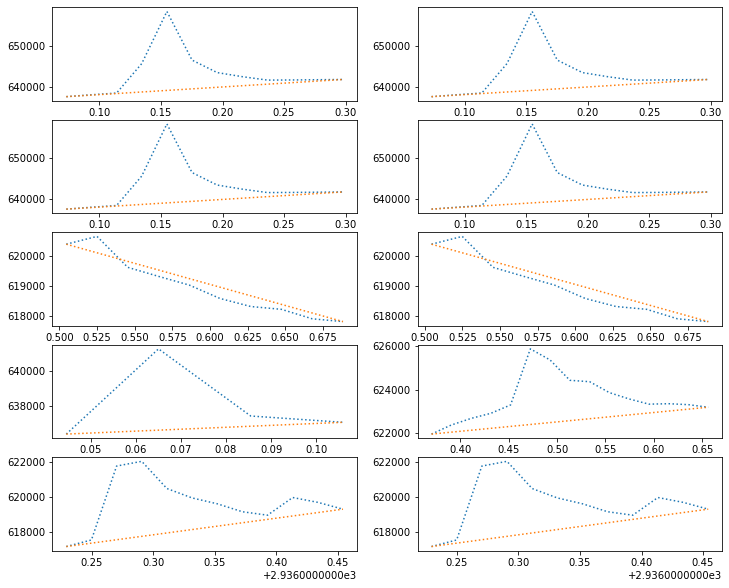

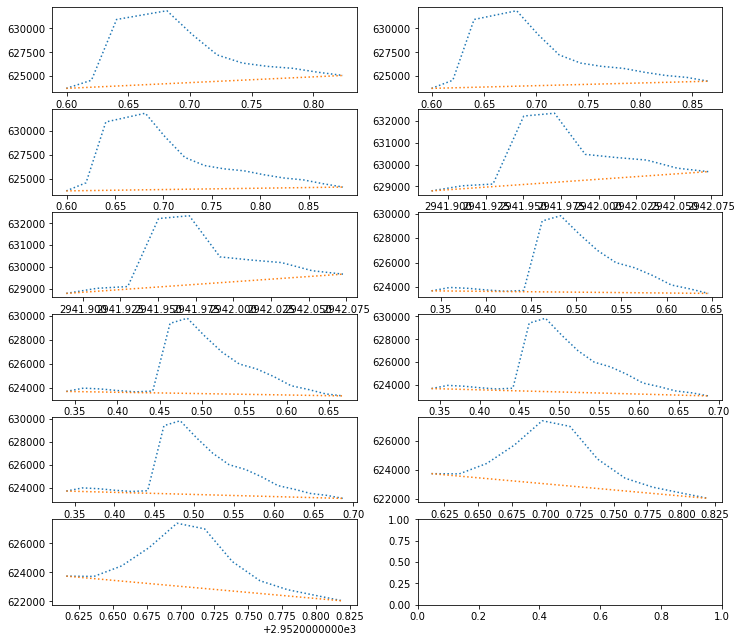

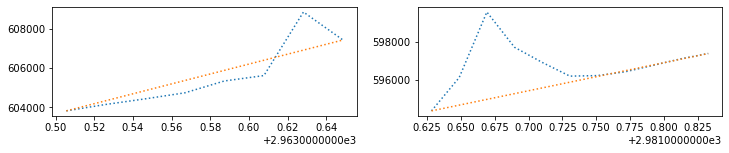

In [130]:
pre_k2sc = subtract_flares_k2sc(pre_k2sc, out_pre_k2sc)
post_k2sc = subtract_flares_k2sc(post_k2sc, out_post_k2sc)
postgap_k2sc = subtract_flares_k2sc(postgap_k2sc, out_postgap_k2sc)


In [131]:
pred_pre_fixed_k2sc, pred_var_pre_fixed_k2sc = alias_k2sc(pre_k2sc, normalized_flag=True, method='gp', segment='pre')
pred_post_fixed_k2sc, pred_var_post_fixed_k2sc = alias_k2sc(post_k2sc, normalized_flag=True, method='gp', segment='post')
pred_postgap_fixed_k2sc, pred_var_postgap_fixed_k2sc = alias_k2sc(postgap_k2sc, normalized_flag=True, method='gp', segment='postgap')
pre_k2sc_fixed['gp_flare_subtracted'] = pred_pre_fixed_k2sc
post_k2sc_fixed['gp_flare_subtracted'] = pred_post_fixed_k2sc
postgap_k2sc_fixed['gp_flare_subtracted'] = pred_postgap_fixed_k2sc

In [132]:
pred_df = pd.concat([pre_k2sc_fixed['gp_flare_subtracted'], post_k2sc_fixed['gp_flare_subtracted'], postgap_k2sc_fixed['gp_flare_subtracted']])
print(pred_df)
pred_df.to_csv('preds_k2sc_flare_subtracted.csv',index=False)

1      -0.015385
2      -0.015276
3      -0.015171
4      -0.015070
5      -0.014972
          ...   
3520    0.018189
3521    0.017780
3523    0.017040
3524    0.016714
3525    0.016421
Name: gp_flare_subtracted, Length: 3246, dtype: float64


##### h. Rotation period analysis, a la https://gallery.exoplanet.codes/tutorials/stellar-variability/

In [871]:
import exoplanet as xo

results = xo.estimators.lomb_scargle_estimator(
    pre_k2sc.time, pre_k2sc.flux_flare_subtracted, max_peaks=1, min_period=0.1, max_period=10.0, samples_per_peak=50
)

peak = results["peaks"][0]
freq, power = results["periodogram"]
plt.plot(1 / freq, power, "k")
plt.axvline(peak["period"], color="k", lw=4, alpha=0.3)
plt.xlim((1 / freq).min(), (1 / freq).max())
plt.yticks([])
plt.xlabel("period [days]")
_ = plt.ylabel("power")

IndexError: list index out of range

In [872]:
results

{'periodogram': (array([0.1       , 0.10060761, 0.10121522, ..., 9.99858814, 9.99919575,
         9.99980336]),
  array([nan, nan, nan, ..., nan, nan, nan])),
 'peaks': [],
 'ls': <astropy.timeseries.periodograms.lombscargle.core.LombScargle at 0x1ba6f57f0>}

In [635]:
df_k2sc_fixed = df_k2sc.dropna(subset=['time', 'corrected_norm', 'error'])
#print(df_k2sc_fixed)

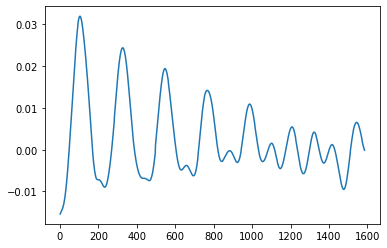

In [664]:
plt.plot(pre_k2sc_fixed.smoothed)

In [669]:
list(pre_k2sc_fixed.smoothed)

AttributeError: 'list' object has no attribute 'shape'

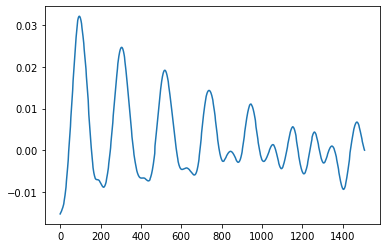

(array([-1.52442583e-02, -1.51334369e-02, -1.50281112e-02, ...,
        3.03300203e-04,  1.62204607e-04,  2.68898293e-05]), array([176.80405442, 115.89297156,  79.45120211, ...,  85.14070139,
       123.42721588, 187.13348024]))


ValueError: Can only convert xarray dataarray, xarray dataset, dict, netcdf filename, numpy array, pystan fit, pymc3 trace, emcee fit, pyro mcmc fit, numpyro mcmc fit, cmdstan fit csv filename, cmdstanpy fit to InferenceData, not tuple

In [739]:
def alias_pymc3(df, normalized_flag, method, segment):
    
    with pm.Model() as model:   

        lhs = min(df.time)
        rhs = max(df.time)
        df = df.dropna(subset=['time', 'flux_flare_subtracted', 'error'])
        xobs = np.array(df["time"])
        yobs = np.array(df["flux_flare_subtracted"])
        eobs = np.array(df["error"])

        #eobs[np.isnan(eobs)] = 22 # most error values are around 22; need to be no nans    
        kernel = np.var(yobs) * ExpSquaredKernel(0.8) # 0.8
        kernel += ExpSine2Kernel(gamma=0.1, log_period=np.log(4.5))
        kernel += 4.0 * Matern32Kernel(metric=4.0)

        gp = george.GP(kernel)
        gp.compute(xobs, eobs)

        if normalized_flag==False:
            if method=='gp':
                pred, pred_var = gp.predict(yobs, xobs, return_var=True)
                return pred, pred_var
            elif method=='savgol':
                if segment=='pre':
                    pred = savgol_filter(yobs, 109, polyorder=3)
                elif segment=='post':
                    pred = savgol_filter(yobs, 129, polyorder=3)
                elif segment=='postgap':
                    pred = savgol_filter(yobs, 129, polyorder=3)
                #return pred

        elif normalized_flag==True:
            yobs_norm = yobs/np.median(yobs) - 1
            pred, pred_var = gp.predict(yobs_norm, xobs, return_var=True)
            if method=='gp':
                pred, pred_var = gp.predict(yobs_norm, xobs, return_var=True)
                return pred, pred_var
            elif method=='savgol':
                if segment=='pre':
                    pred = savgol_filter(yobs_norm, 109, polyorder=3)
                elif segment=='post':
                    pred = savgol_filter(yobs_norm, 149, polyorder=3)
                elif segment=='postgap':
                    pred = savgol_filter(yobs_norm, 129, polyorder=3)
                #return pred
        
        # Compute the mean model prediction for plotting purposes
        pm.Deterministic("pred", pred)
        
        # Optimize to find the maximum a posteriori parameters
        map_soln = pmx.optimize()
    
    with model:
        trace = pmx.sample(
            tune=1000,
            draws=1000,
            start=map_soln,
            cores=2,
            chains=2,
            target_accept=0.9,
            return_inferencedata=True,
            random_seed=[10863087, 10863088],
        )
        
    print(trace)

    return trace

"""
with pm.Model() as model:   
    kernel_pre = np.var(yobs_pre) * ExpSquaredKernel(0.8)
    
    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", pre_k2sc_fixed.smoothed)
    
    # Optimize to find the maximum a posteriori parameters
    map_soln = pmx.optimize()
"""

plt.plot(pre_map_soln[0])
plt.show()

pre_trace = alias_pymc3(pre_k2sc, normalized_flag=True, method='gp', segment='pre')
print(pre_trace)

import arviz as az
az.summary(
    pre_trace,
)

period_samples = np.asarray(pre_trace.posterior["period"]).flatten()
plt.hist(period_samples, 25, histtype="step", color="k", density=True)
plt.yticks([])
plt.xlabel("rotation period [days]")
_ = plt.ylabel("posterior density")
plt.show()

fasdfdf

print(pre_map_soln[0].shape, pre_map_soln[1].shape)
pre_map_soln_dict = {'pred': pre_map_soln[0], 'log_jitter': pre_map_soln[1]}
pre_map_soln_dict = {'pred': pre_map_soln[0]}
#pre_map_soln_dict = dict(enumerate(pre_map_soln.flatten(), 1))

In [716]:
with model:
    trace = pmx.sample(
        tune=1000,
        draws=1000,
        start=pre_map_soln_dict,
        cores=2,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True,
        random_seed=[10863087, 10863088],
    )


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'pred': array([-1.52442583e-02, -1.51334369e-02, -1.50281112e-02, ...,
        3.03300203e-04,  1.62204607e-04,  2.68898293e-05]), 'mean': array(0.), 'log_jitter': array(1.7900729e+08), 'sigma_log__': array(0.5556663), 'rho_log__': array(-0.18800334), 'sigma_rot_log__': array(0.5556663), 'log_period': array(1.49514877), 'log_Q0_log__': array(0.46735583), 'log_dQ': array(0.), 'f_interval__': array(2.22044605e-16)}

Initial evaluation results:
mean              -0.92
log_jitter        -1.61
sigma_log__        0.11
rho_log__          0.27
sigma_rot_log__    0.11
log_period        -1.61
log_Q0_log__      -0.77
log_dQ            -1.61
f_interval__      -1.39
gp                  NaN
Name: Log-probability of test_point, dtype: float64

In [744]:
df_k2sc['time'].isnull().values.any()

False

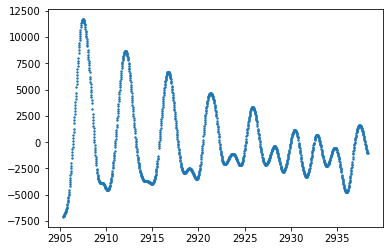

TypeError: __init__() missing 4 required keyword-only arguments: 'sigma', 'Q0', 'dQ', and 'f'

In [756]:
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess

yerr = pre_k2sc_fixed.error/np.nanmedian(pre_k2sc_fixed.error) - 1
yerr = postgap_k2sc_fixed.error
x = postgap_k2sc_fixed.time
y = postgap_k2sc_fixed.flux_flare_subtracted # corrected_norm
y = y/np.nanmedian(y) - 1
#y = pre_k2sc_fixed.corrected
yerr = yerr/np.nanmedian(y)
yerr = np.array(yerr)
y = np.array(y)
x = np.array(x)

y = np.ascontiguousarray(pre_k2sc_fixed.smoothed, dtype=np.float64)
x = np.ascontiguousarray(pre_k2sc_fixed.time, dtype=np.float64)
yerr = np.ascontiguousarray(pre_k2sc_fixed.error, dtype=np.float64)
mu = np.mean(y)
y = (y / mu - 1) * 1e3
yerr = yerr * 1e3 / mu

plt.scatter(x, y, s=2)
plt.show()

with pm.Model() as model:

    # The mean flux of the time series
    mean = pm.Normal("mean", mu=np.nanmean(y), sigma=100.0)

    # A jitter term describing excess white noise
    #log_jitter = pm.Normal("log_jitter", mu=np.log(yerr), sigma=2.0)
    log_jitter = pm.Normal("log_jitter", mu=np.var(y), sigma=2.0)

    """
    # A term to describe the non-periodic variability
    sigma = pm.InverseGamma(
        "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
    )
    rho = pm.InverseGamma(
        "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 2.0)
    )
    """
    
    # The parameters of the RotationTerm kernel
    #sigma_rot = pm.InverseGamma(
    #    "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
    #)
    log_period = pm.Normal("log_period", mu=np.log(4.46), sigma=2.0)
    period = pm.Deterministic("period", tt.exp(log_period))
    #log_Q0 = pm.HalfNormal("log_Q0", sigma=2.0)
    #log_dQ = pm.Normal("log_dQ", mu=0.0, sigma=2.0)
    #f = pm.Uniform("f", lower=0.1, upper=1.0)

    # Set up the Gaussian Process model
    #kernel = terms.SHOTerm(sigma=sigma, rho=rho, Q=1 / 3.0)
    
    kernel = terms.RotationTerm(
        period=period,
    )
    gp = GaussianProcess(
        kernel,
        t=x,
        diag=yerr**2 + tt.exp(2 * log_jitter),
        mean=mean,
        quiet=True,
    )

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    gp.marginal("gp", observed=y)

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict(y))

    # Optimize to find the maximum a posteriori parameters
    map_soln = pmx.optimize()

In [ ]:
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess

yerr = pre_k2sc_fixed.error/np.nanmedian(pre_k2sc_fixed.error) - 1
yerr = postgap_k2sc_fixed.error
x = postgap_k2sc_fixed.time
y = postgap_k2sc_fixed.flux_flare_subtracted # corrected_norm
y = y/np.nanmedian(y) - 1
#y = pre_k2sc_fixed.corrected
yerr = yerr/np.nanmedian(y)
yerr = np.array(yerr)
y = np.array(y)
x = np.array(x)

y = np.ascontiguousarray(pre_k2sc_fixed.smoothed, dtype=np.float64)
x = np.ascontiguousarray(pre_k2sc_fixed.time, dtype=np.float64)
yerr = np.ascontiguousarray(pre_k2sc_fixed.error, dtype=np.float64)
mu = np.mean(y)
y = (y / mu - 1) * 1e3
yerr = yerr * 1e3 / mu

plt.scatter(x, y, s=2)
plt.show()

with pm.Model() as model:

    # The mean flux of the time series
    mean = pm.Normal("mean", mu=np.nanmean(y), sigma=1.0)

    # A jitter term describing excess white noise
    #log_jitter = pm.Normal("log_jitter", mu=np.log(yerr), sigma=2.0)
    log_jitter = pm.Normal("log_jitter", mu=np.var(y), sigma=2.0)

    # A term to describe the non-periodic variability
    sigma = pm.InverseGamma(
        "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
    )
    rho = pm.InverseGamma(
        "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 2.0)
    )

    # The parameters of the RotationTerm kernel
    sigma_rot = pm.InverseGamma(
        "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
    )
    log_period = pm.Normal("log_period", mu=np.log(4.46), sigma=2.0)
    period = pm.Deterministic("period", tt.exp(log_period))
    log_Q0 = pm.HalfNormal("log_Q0", sigma=2.0)
    log_dQ = pm.Normal("log_dQ", mu=0.0, sigma=2.0)
    f = pm.Uniform("f", lower=0.1, upper=1.0)

    # Set up the Gaussian Process model
    kernel = terms.SHOTerm(sigma=sigma, rho=rho, Q=1 / 3.0)
    
    kernel += terms.RotationTerm(
        sigma=sigma_rot,
        period=period,
        Q0=tt.exp(log_Q0),
        dQ=tt.exp(log_dQ),
        f=f,
    )
    gp = GaussianProcess(
        kernel,
        t=x,
        diag=yerr**2 + tt.exp(2 * log_jitter),
        mean=mean,
        quiet=True,
    )

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    gp.marginal("gp", observed=y)

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict(y))

    # Optimize to find the maximum a posteriori parameters
    map_soln = pmx.optimize()

Text(0, 0.5, 'relative flux [ppt]')

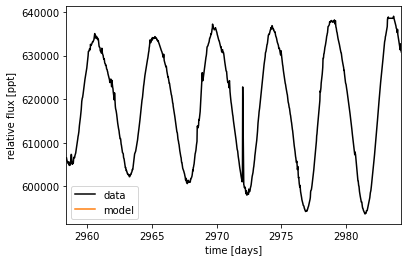

In [722]:
plt.plot(x, y, "k", label="data")
plt.plot(x, map_soln["pred"], color="C1", label="model")
plt.xlim(x.min(), x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")

In [723]:
map_soln['pred'] = pre_k2sc_fixed.smoothed

In [728]:
with model:
    trace = pmx.sample(
        tune=1000,
        draws=1000,
        start=map_soln,
        #start={'mean': np.array([0.]), 'tau': np.array([0.]), 'sigma_c': np.array([0.]), 'sigma_t': np.array([0.])},
        cores=2,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True,
        random_seed=[10863087, 10863088],
    )

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'mean': array(-0.00355014), 'log_jitter': array(0.00046425), 'sigma_log__': array(0.5556663), 'rho_log__': array(-0.18800334), 'sigma_rot_log__': array(0.5556663), 'log_period': array(1.49514877), 'log_Q0_log__': array(0.46735583), 'log_dQ': array(0.), 'f_interval__': array(2.22044605e-16), 'sigma': array(1.74310202), 'rho': array(0.82861194), 'sigma_rot': array(1.74310202), 'period': array(4.46), 'log_Q0': array(1.59576912), 'f': array(0.55), 'pred': array([nan, nan, nan, ..., nan, nan, nan])}

Initial evaluation results:
mean              -0.92
log_jitter        -1.61
sigma_log__        0.11
rho_log__          0.27
sigma_rot_log__    0.11
log_period        -1.61
log_Q0_log__      -0.77
log_dQ            -1.61
f_interval__      -1.39
gp                  NaN
Name: Log-probability of test_point, dtype: float64

14% (16095/113535) of the cadences will be ignored due to the quality mask (quality_bitmask=8191).
14% (16095/113535) of the cadences will be ignored due to the quality mask (quality_bitmask=8191).
12% (2296/18921) of the cadences will be ignored due to the quality mask (quality_bitmask=8191).
12% (2296/18921) of the cadences will be ignored due to the quality mask (quality_bitmask=8191).


0.2885337416867352
[1.76442847 1.77044365 1.76456746 ... 1.78034421 1.78391416 1.78541974]


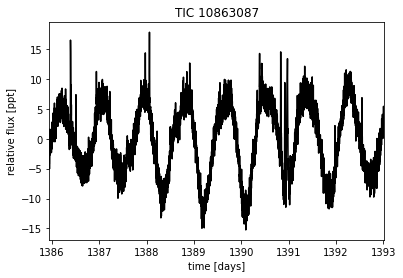

3.13691221306122
[499.67539721 500.2690633  500.79231028 ... 566.7485094  565.65644654
 565.11076471]


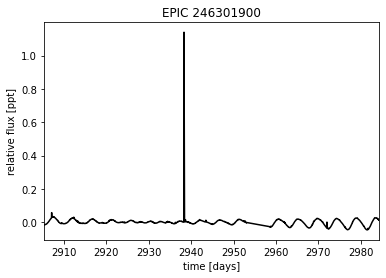

In [822]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt

lcf = lk.search_lightcurve(
    "TIC 10863087", mission="TESS", author="SPOC"
).download_all(quality_bitmask="hardest", flux_column="pdcsap_flux")
lc = lcf.stitch().remove_nans().remove_outliers()
lc = lc[:5000]
#print(lc.flatten())
_, mask = lc.remove_outliers(sigma=3.0, return_mask=True)
lc = lc[~mask]

x = np.ascontiguousarray(lc.time.value, dtype=np.float64)
y = np.ascontiguousarray(lc.flux, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err, dtype=np.float64)
mu = np.mean(y)
y = (y / mu - 1) * 1e3
yerr = yerr * 1e3 / mu
print(np.log(np.mean(yerr)))
print(yerr**2)

plt.plot(x, y, "k")
plt.xlim(x.min(), x.max())
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.title("TIC 10863087")
plt.show()

x = np.array(df_k2sc_fixed.time)
y = np.array(df_k2sc_fixed.corrected_norm)
#y = y/np.std(y)
yerr = np.array(df_k2sc_fixed.error)
#yerr = yerr/np.nanmedian(y)
print(np.log(np.mean(yerr)))
print(yerr**2)

plt.plot(x, y, "k")
plt.xlim(x.min(), x.max())
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.title("EPIC 246301900")
plt.show()


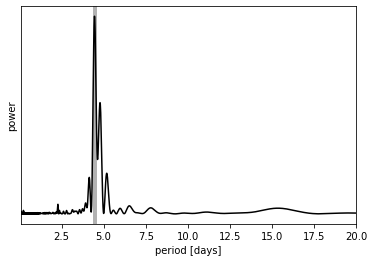

In [823]:
import exoplanet as xo

results = xo.estimators.lomb_scargle_estimator(
    x, y, max_peaks=1, min_period=0.1, max_period=20.0, samples_per_peak=50
)

peak = results["peaks"][0]
freq, power = results["periodogram"]
plt.plot(1 / freq, power, "k")
plt.axvline(peak["period"], color="k", lw=4, alpha=0.3)
plt.xlim((1 / freq).min(), (1 / freq).max())
plt.yticks([])
plt.xlabel("period [days]")
_ = plt.ylabel("power")

In [812]:
#print(yerr**2 + tt.exp(2 * log_jitter).eval())

In [824]:
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess

with pm.Model() as model:

    # The mean flux of the time series
    mean = pm.Normal("mean", mu=0.0, sigma=10.0)

    # A jitter term describing excess white noise
    log_jitter = pm.Normal("log_jitter", mu=np.log(np.mean(yerr)), sigma=2.0)
    #log_jitter = pm.Normal("log_jitter", mu=np.log(np.var(y)), sigma=2.0)
    #log_jitter = pm.Normal("log_jitter", mu=0.29, sigma=2.0)
    
    # A term to describe the non-periodic variability
    sigma = pm.InverseGamma(
        "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
    )
    rho = pm.InverseGamma(
        "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 2.0)
    )

    # The parameters of the RotationTerm kernel
    sigma_rot = pm.InverseGamma(
        "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
    )
    log_period = pm.Normal("log_period", mu=np.log(peak["period"]), sigma=2.0)
    period = pm.Deterministic("period", tt.exp(log_period))
    log_Q0 = pm.HalfNormal("log_Q0", sigma=2.0)
    log_dQ = pm.Normal("log_dQ", mu=0.0, sigma=2.0)
    f = pm.Uniform("f", lower=0.1, upper=1.0)

    # Set up the Gaussian Process model
    kernel = terms.SHOTerm(sigma=sigma, rho=rho, Q=1 / 3.0)
    kernel += terms.RotationTerm(
        sigma=sigma_rot,
        period=period,
        Q0=tt.exp(log_Q0),
        dQ=tt.exp(log_dQ),
        f=f,
    )
    gp = GaussianProcess(
        kernel,
        t=x,
        diag=yerr**2 + tt.exp(2 * log_jitter),
        mean=mean,
        quiet=True,
    )

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    gp.marginal("gp", observed=y)

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict(y))

    # Optimize to find the maximum a posteriori parameters
    map_soln = pmx.optimize()

optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Optimization terminated successfully.
logp: -14317.227620889518 -> -13194.851031389235


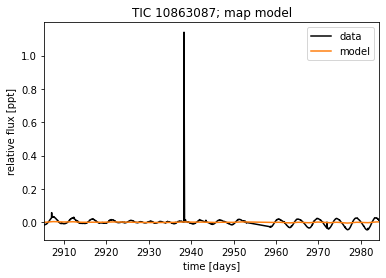

In [825]:
plt.plot(x, y, "k", label="data")
plt.plot(x, map_soln["pred"], color="C1", label="model")
plt.xlim(x.min(), x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.title("TIC 10863087; map model")

In [826]:
with model:
    trace = pmx.sample(
        tune=100,
        draws=100,
        start=map_soln,
        cores=2,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True,
        random_seed=[10863087, 10863088],
    )

Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 10 seconds.


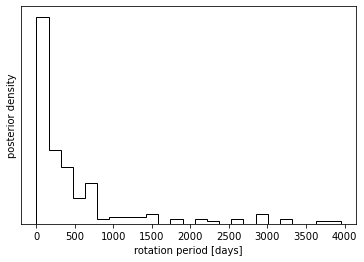

In [827]:
period_samples = np.asarray(trace.posterior["period"]).flatten()
plt.hist(period_samples, 25, histtype="step", color="k", density=True)
plt.yticks([])
plt.xlabel("rotation period [days]")
_ = plt.ylabel("posterior density")

In [774]:
print(x, y, yerr)
print(len(x))
print(np.array(pre_k2sc_fixed.time), np.array(pre_k2sc_fixed.smoothed), np.array(pre_k2sc_fixed.error))
print(len(pre_k2sc_fixed.time))

[1385.94260092 1385.94398985 1385.94537878 ... 1393.01221958 1393.0136085
 1393.01499741] [-4.11665903 -2.34166871 -5.04448403 ...  2.24358375  4.31758763
  2.5443871 ] [1.32831791 1.33058019 1.32837023 ... 1.3342954  1.33563249 1.336196  ]
4988
[2905.39766238 2905.41809467 2905.43852696 ... 2938.25217206 2938.27260368
 2938.29303539] [-1.53854092e-02 -1.52756360e-02 -1.51709842e-02 ...  1.31198893e-04
  3.85977801e-06 -1.09489397e-04] [22.35342026 22.3666954  22.37838936 ... 22.93784523 22.94063759
 22.94995308]
1510


In [384]:
out_fixed

index        tpeak  tpeaks_norm     ampls  unnorm_ampls     fwhms  \
0       0  2905.785876   -16.059473  1.227784      0.001811  0.002778   
1       1  2905.826740   -16.018609  1.458995      0.002152  0.004167   
2       2  2907.134405   -14.710944  6.983271      0.010299  0.011111   
3       5  2907.440889   -14.404460  1.451282      0.002140  0.002778   
4       8  2909.504541   -12.340807  3.145568      0.004639  0.012500   
..    ...          ...          ...       ...           ...       ...   
62     21  2975.008522     3.687865  1.603894      0.002026  0.002778   
63     22  2976.275283     4.954627  2.286708      0.002888  0.002778   
64     23  2977.991542     6.670886  1.682145      0.002124  0.002778   
65     25  2979.176580     7.855923  1.439159      0.001818  0.002778   
66     28  2981.669248    10.348591  4.987364      0.006299  0.004167   

    fixed_tpeaks  fixed_fwhms  
0    2905.826740  3517.035456  
1    2905.826740  4933.966329  
2    2907.154837  2434.243103  
3    2907.440889  2043.730221  
4    2909.524974  3474.035794  
..           ...          ...  
62   2974.967658  5446.430118  
63   2976.275283  1979.571448  
64   2977.991542  2206.931874  
65   2979.176580  2317.622511  
66   2981.669248  3319.357666  

[67 rows x 8 columns]

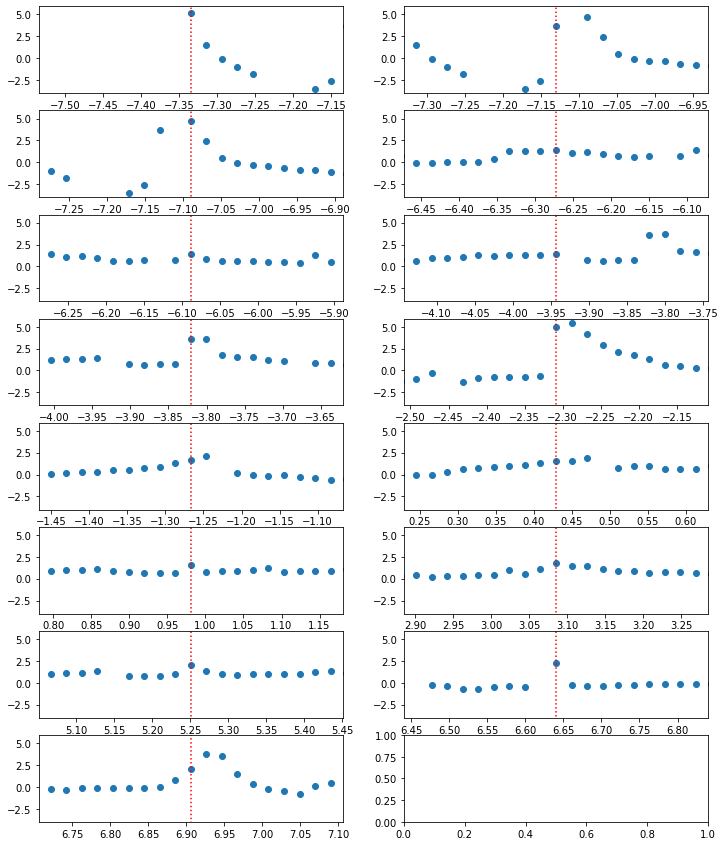

In [144]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks_post/2).astype(int), figsize=[12,npeaks_post])
axes = axes.flatten()
for i in range(npeaks_post):
    ax = axes[i]
    ax.scatter(x_post, y_post)
    #ax.axvline(tpeaks[i], np.min(y), np.max(y), color='r', linestyle=':')
    ax.axvline(tpeaks_norm_post[i], -1, 1, color='r', linestyle=':')
    ax.set_xlim(tpeaks_norm_post[i]-0.2, tpeaks_norm_post[i]+0.2)
    #ax.set_ylim(np.min(y), np.max(ampls[i]+3))

We can throw away the first identified flare because that's just the downslope of the super-flare. We can also combine the second and third identified flares because they're the same event. Why did they get double-counted, though?

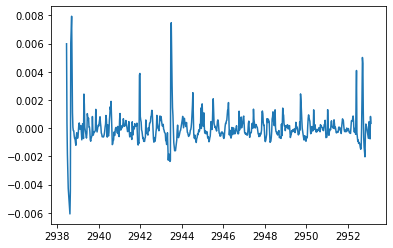

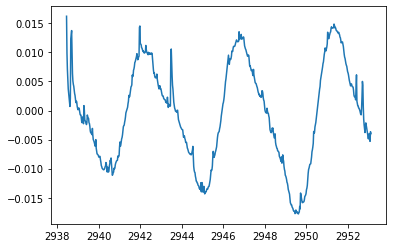

In [132]:
plt.plot(post.TIME, norm_flux_post - pred_post)
plt.show()

plt.plot(post.TIME, norm_flux_post)
plt.show()

In [149]:
print(tpeaks_post)
print(post.loc[(post.TIME < 2938.75) & (post.TIME > 2938.5)].TIME)

[2938.43605659 2938.64037271 2938.68123593 2939.49850037 2939.68238477
 2941.82770175 2941.95029121 2943.46222768 2944.5042374  2946.20005625
 2946.75170786 2948.85615609 2951.02189782 2952.41124125 2952.67685103]
1622    2938.517783
1626    2938.599509
1627    2938.619941
1628    2938.640373
1630    2938.681236
1631    2938.701668
1632    2938.722099
1633    2938.742531
Name: TIME, dtype: float64


Okay, I *think* it's because there's a gap in the data between index 1628 and 1630, and so the code that concatenates threshold events into the same event thinks they're not consecutive (and therefore belonging to the same event) after all.

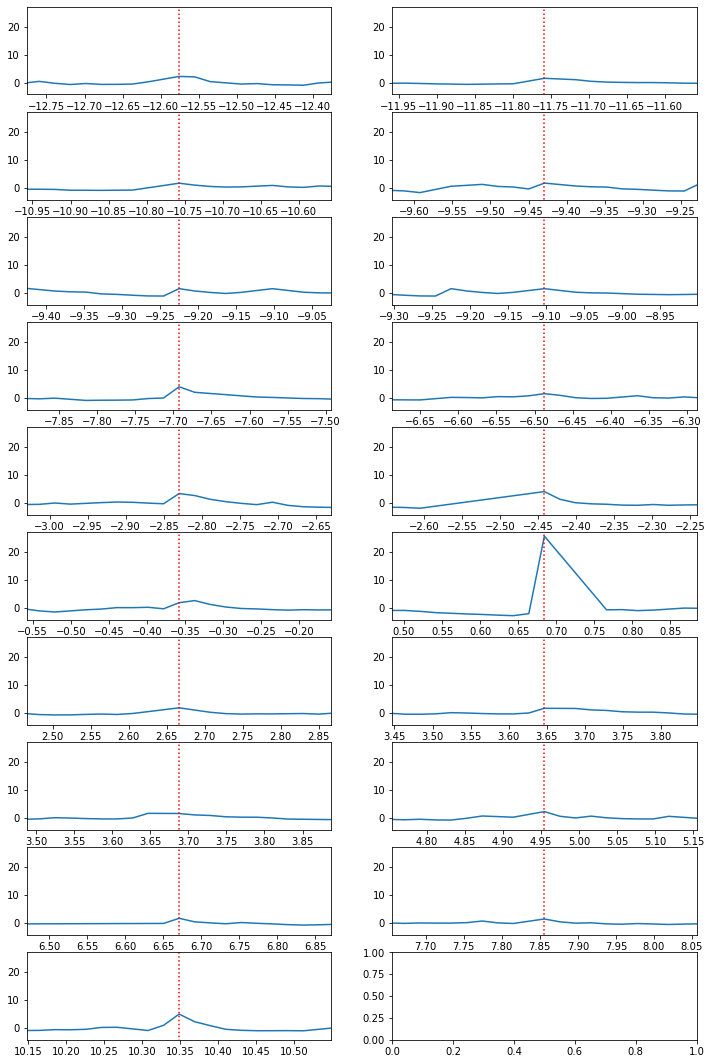

In [130]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks_postgap/2).astype(int), figsize=[12,npeaks_postgap])
axes = axes.flatten()
for i in range(npeaks_postgap):
    ax = axes[i]
    ax.plot(x_postgap, y_postgap)
    #ax.axvline(tpeaks[i], np.min(y), np.max(y), color='r', linestyle=':')
    ax.axvline(tpeaks_norm_postgap[i], -1, 1, color='r', linestyle=':')
    ax.set_xlim(tpeaks_norm_postgap[i]-0.2, tpeaks_norm_postgap[i]+0.2)
    #ax.set_ylim(np.min(y), np.max(ampls[i]+3))

### 8) Flare analysis: xoflares

I've output find_flares() to a csv and will read that in for flare energy and frequency distribution analysis in flare_analysis.ipynb.

### 9) Ancillary plots

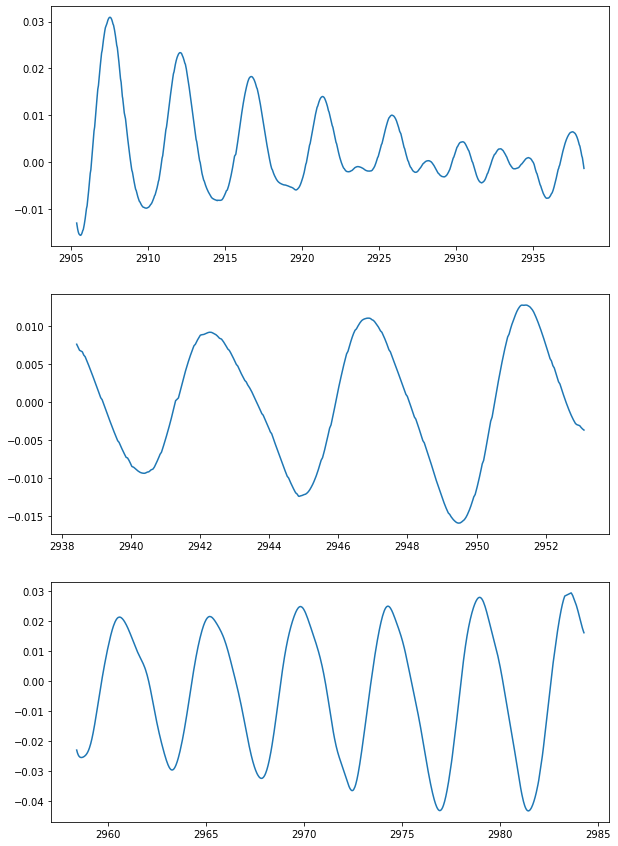

In [172]:
plt.figure(figsize=(10,15))
plt.subplot(311)
plt.plot(pre.TIME, savgol_pre)

plt.subplot(312)
plt.plot(post.TIME, savgol_post)

plt.subplot(313)
plt.plot(postgap.TIME, pred_postgap)
plt.show()

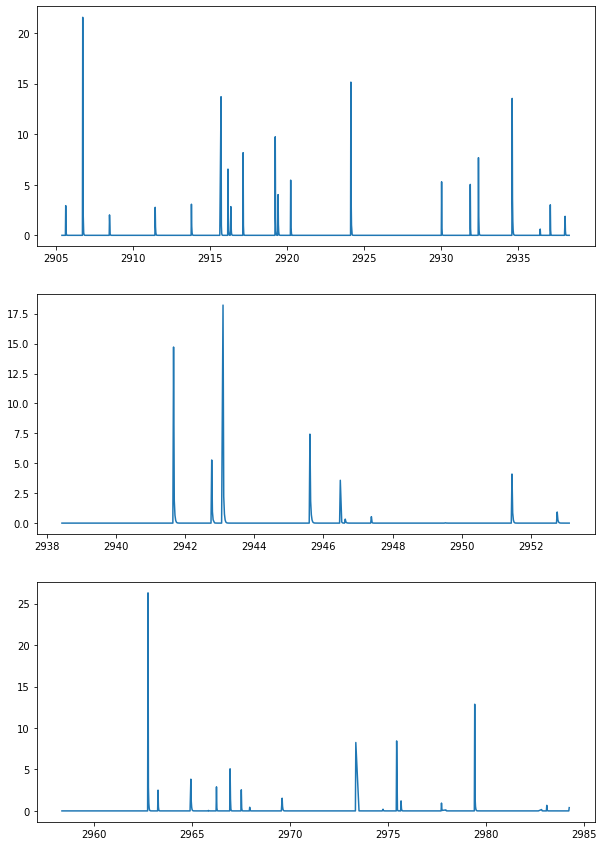

In [173]:
plt.figure(figsize=(10,15))
plt.subplot(311)
plt.plot(pre.TIME, (flux_pre-pred_pre-pre.PDCSAP_FLUX_ERR/np.median(pre.PDCSAP_FLUX))/np.std(flux_pre-pred_pre-pre.PDCSAP_FLUX_ERR/np.median(pre.PDCSAP_FLUX)))

plt.subplot(312)
plt.plot(post.TIME, (flux_post-pred_post-post.PDCSAP_FLUX_ERR/np.median(post.PDCSAP_FLUX))/np.std(flux_post-pred_post-post.PDCSAP_FLUX_ERR/np.median(post.PDCSAP_FLUX)))

plt.subplot(313)
plt.plot(postgap.TIME, (flux_postgap-pred_postgap-postgap.PDCSAP_FLUX_ERR/np.median(postgap.PDCSAP_FLUX))/np.std(flux_postgap-pred_postgap-postgap.PDCSAP_FLUX_ERR/np.median(postgap.PDCSAP_FLUX)))
plt.show()